# Init

In [ ]:
!pip install stanza
!pip install scikit-learn # Install scikit-learn if you haven't already
!pip install gensim
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.5 MB/s eta 0:00:00


In [ ]:
# Data handling
import pandas as pd
import json
import os
import re
import itertools
import time

# Natural Language Processing
import nltk
import stanza
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

# Machine Learning
import numpy as np
import concurrent.futures
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, NMF, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec

# Joblib
from joblib import dump

# Google Colab
from google.colab import files

# Visualization
import matplotlib.pyplot as plt

# Deep Learning
from keras import models, layers
from keras.layers import Dense, Dropout, LSTM, Conv1D, Bidirectional
from keras.utils import to_categorical
from keras.models import Sequential
import tensorflow as tf


In [ ]:
stanza.download('ro')
nlp = stanza.Pipeline('ro')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('romanian'))
print(stop_words)
romanian_alphabet_regex = re.compile(r'[A-Za-zĂăÂâÎîȘșȚț]')

INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: ro (Romanian) ...


INFO:stanza:Downloaded file to /root/stanza_resources/ro/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: ro (Romanian):
| Processor | Package      |
----------------------------
| tokenize  | rrt          |
| pos       | rrt_nocharlm |
| lemma     | rrt_nocharlm |
| depparse  | rrt_nocharlm |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Done loading processors!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


{'nimeni', 'lor', 'iti', 'pic', 'sub', 'desi', 'ni', 'noua', 'fără', 'către', 'nostri', 'anume', 'dintr-', 'deşi', 'am', 'tot', 'dintr', 'as', 'ma', 'pînă', 'nu', 'caruia', 'ala', 'niste', 'multe', 'dar', 'in', 'uneori', 'au', 'tocmai', 'ălea', 'mult', 'multă', 'una', 'incit', 'i', 'mereu', 'deci', 'va', 'poate', 'atat', 'are', 'unul', 'nouă', 'cea', 'fie', 'eşti', 'mâine', 'o', 'oricare', 'prin', 'sau', 'daca', 'care', 'oricît', 'fi', 'acestei', 'putini', 'puţin', 'atitia', 'nimic', 'alea', 'ii', 'tăi', 'chiar', 'aţi', 'nou', 'tine', 'acestui', 'mă', 'decit', 'ca', 'ăla', 'acesta', 'săi', 'uneia', 'câţi', 'mele', 'căror', 'mod', 'ba', 'vom', 'asta', 'acei', 'apoi', 'ceea', 'despre', 'multi', 'aceia', 'lui', 'două', 'avem', 'sai', 'aia', 'mine', 'al', 'sa-mi', 'celor', 'meu', 'patra', 'cui', 'oricât', 'cînd', 'da', 'voştri', 'ta', 'oricînd', 'cîţi', 'cita', 'fiu', 'vă', 'unora', 'altcineva', 'ceilalti', 'din', 'unei', 'nici', 'totul', 'cât', 'atare', 'voastră', 'la', 'ceva', 'se', 'tal

# Prep

In [ ]:
test_data = {}
voc = {}

for i in range(5):
    # Download and load cleaned reviews
    os.system(f'wget -q "https://raw.githubusercontent.com/ACS-SII/proiect-2024-sentiment-analysis-study/refs/heads/main/new_set/cleaned_reviews_rating_{i+1}.json"')
    with open(f"cleaned_reviews_rating_{i+1}.json", "r") as f:
        test_data[i+1] = json.load(f)

    # Download and load vocabulary
    os.system(f'wget -q "https://raw.githubusercontent.com/ACS-SII/proiect-2024-sentiment-analysis-study/refs/heads/main/new_set/voc_rating_{i+1}.json"')
    with open(f"voc_rating_{i+1}.json", "r") as f:
        voc[i+1] = json.load(f)

    # # Optional: print confirmation
    # print(f"Loaded data for rating {i+1}:")
    # print("Sample review data:", test_data[:1])  # Show first entry as a sample
    # print("Sample vocabulary:", dict(list(voc.items())[:5]))  # Show first 5 entries as a sample


In [ ]:
dict_pos = Counter(voc[4]) + Counter(voc[5])  # Positive combined vocabulary
dict_neg = Counter(voc[1]) + Counter(voc[2]) + Counter(voc[2])  # Negative combined vocabulary

In [ ]:
# dict_pos = dict(vocab_pos)
# dict_neg = dict(vocab_neg)

# Merge dictionaries and handle occurrences
merged_dict = {}
for word in set(dict_pos.keys()).union(dict_neg.keys()):
    occurrences_pos = dict_pos.get(word, 0)
    occurrences_neg = dict_neg.get(word, 0)
    merged_dict[word] = (occurrences_pos, occurrences_neg)


# Order the merged dictionary by maximum occurrence
sorted_merged_dict = dict(sorted(merged_dict.items(), key=lambda item: sum(item[1]), reverse=True))

# Display the ordered occurrences
# for word, counts in sorted_merged_dict.items():
#     print(f'{word}: {counts[0]} (positive), {counts[1]} (negative), Max Occurrence: {sum(counts)}')

# # Display the merged occurrences
# for word, counts in merged_dict.items():
#     print(f'{word}: {counts[0]} (positive), {counts[1]} (negative)')



In [ ]:
print(sorted_merged_dict)

{'avea': (12269, 18111), 'de': (12913, 13685), 'fi': (11133, 10959), 'si': (7534, 7377), 'un': (6828, 7431), 'la': (5919, 7829), 'nu': (4935, 8436), 'in': (5513, 6336), 'său': (4782, 6797), 'ca': (3359, 5424), 'produs': (4603, 3773), 'mai': (4268, 3628), 'pe': (3333, 4442), 'cu': (3629, 3705), 'eu': (2947, 3902), 'el': (2866, 3790), 'sine': (2615, 3035), 'pentru': (3114, 2430), 'care': (2599, 2873), 'din': (2116, 2945), 'foarte': (3159, 1600), 'mult': (2073, 1486), 'ce': (1518, 1804), 'tot': (1850, 1286), 'dar': (1485, 1545), 'putea': (1460, 1407), 'pret': (1634, 1177), 'bun': (1999, 779), 'meu': (1340, 1284), 'vrea': (1097, 1516), 'al': (1078, 1319), 's': (736, 1644), 'trebui': (953, 1187), 'acela': (1054, 1034), 'face': (836, 1182), 'după': (470, 1517), 'acesta': (796, 1174), 'mare': (1116, 834), 'personal': (1126, 786), 'și': (1041, 870), 'calitate': (1290, 522), 'acest': (800, 972), 'decathlon': (940, 749), 'în': (755, 932), 'bine': (1231, 437), 'a': (715, 897), 'casă': (473, 1128)

In [ ]:
percentage_difference = {
    word: ((counts[0] - counts[1]) / ((counts[0] + counts[1]) / 2)) * 100
    for word, counts in sorted_merged_dict.items()
}

# Display the first 50 items in the sorted merged dictionary with percentage difference
for i, (word, counts) in enumerate(sorted_merged_dict.items()):
    if i < 50:
        diff_percentage = percentage_difference[word]
        print(f'{word}: {counts[0]} (positive), {counts[1]} (negative), Percentage Difference: {diff_percentage:.2f}%')
    else:
        break

avea: 12269 (positive), 18111 (negative), Percentage Difference: -38.46%
de: 12913 (positive), 13685 (negative), Percentage Difference: -5.80%
fi: 11133 (positive), 10959 (negative), Percentage Difference: 1.58%
si: 7534 (positive), 7377 (negative), Percentage Difference: 2.11%
un: 6828 (positive), 7431 (negative), Percentage Difference: -8.46%
la: 5919 (positive), 7829 (negative), Percentage Difference: -27.79%
nu: 4935 (positive), 8436 (negative), Percentage Difference: -52.37%
in: 5513 (positive), 6336 (negative), Percentage Difference: -13.89%
său: 4782 (positive), 6797 (negative), Percentage Difference: -34.80%
ca: 3359 (positive), 5424 (negative), Percentage Difference: -47.02%
produs: 4603 (positive), 3773 (negative), Percentage Difference: 19.82%
mai: 4268 (positive), 3628 (negative), Percentage Difference: 16.21%
pe: 3333 (positive), 4442 (negative), Percentage Difference: -28.53%
cu: 3629 (positive), 3705 (negative), Percentage Difference: -2.07%
eu: 2947 (positive), 3902 (ne

In [ ]:
# Filter for words with a minimum appearance of 3 and sort by absolute percentage difference
filtered_sorted_percentage_difference = sorted(
    {
        word: diff for word, diff in percentage_difference.items()
        if sum(sorted_merged_dict[word]) >= 3
    }.items(),
    key=lambda item: abs(item[1]),
    reverse=True
)

# Print the filtered and sorted results
print("Word\t\tPercentage Difference")
print("=" * 40)
for word, diff in filtered_sorted_percentage_difference[:50]:
    print(f"{word}\t\t{diff:.2f}%")


Word		Percentage Difference
plăcere		200.00%
felicitare		200.00%
scoata		-200.00%
reprosa		200.00%
optim		200.00%
obiecta		200.00%
convenabil		200.00%
odata		-200.00%
trimisă		-200.00%
comandat		-200.00%
rapiditate		200.00%
rusin		-200.00%
binevenit		200.00%
niman		-200.00%
ghiseu		-200.00%
factura		-200.00%
spună		-200.00%
iubitor		200.00%
brio		200.00%
gasire		200.00%
incorect		-200.00%
totală		-200.00%
furt		-200.00%
probate		200.00%
unghie		-200.00%
maraton		200.00%
crestere		200.00%
cică		-200.00%
superi		200.00%
director		-200.00%
minciună		-200.00%
dorești		200.00%
drăguț		200.00%
saritor		200.00%
atm		-200.00%
inghetată		-200.00%
domyos		200.00%
inconfortabil		-200.00%
nasture		-200.00%
around		-200.00%
returnati		-200.00%
nestrans		-200.00%
shorts		200.00%
campanie		200.00%
introduceti		200.00%
adora		200.00%
relaxare		200.00%
inacceptabil		-200.00%
informata		-200.00%
promtitudine		200.00%


In [ ]:
def remove_vocab(sett,rvocab):
  nset=list()
  for doc in sett:
    tokens = doc.split()
    tokens = [w for w in tokens if w not in rvocab]
    tokens = ' '.join(tokens)
    nset.append(tokens)
  return nset

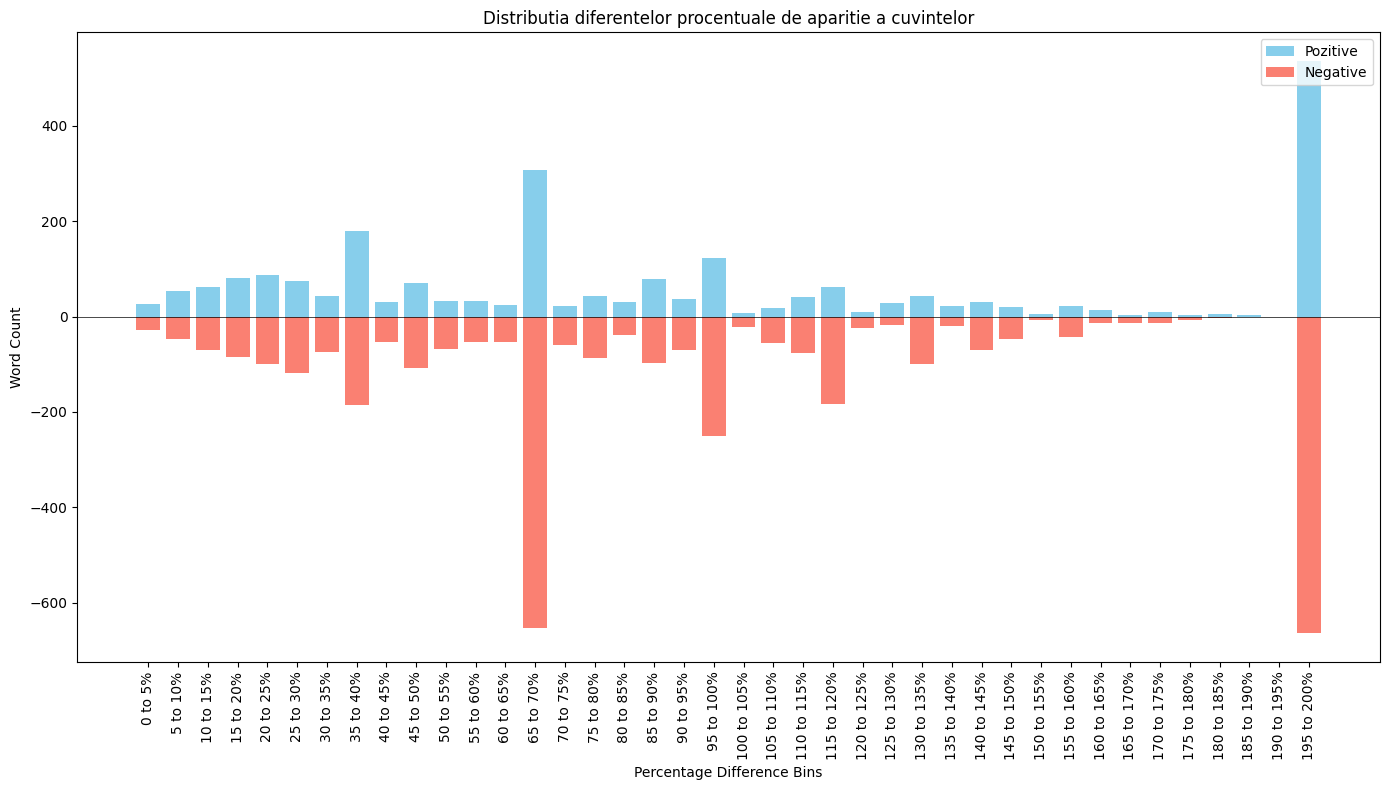

In [ ]:


# Filter percentage_difference to include only words with at least 3 appearances
filtered_percentage_difference = {
    word: diff for word, diff in percentage_difference.items()
    if sum(sorted_merged_dict[word]) >= 3
}

# Define bins from 0 to 200 in 5% intervals
bins = np.arange(0, 205, 5)  # Create bins from 0 to 200 in steps of 5
bin_labels = [f"{bins[i]} to {bins[i+1]}%" for i in range(len(bins)-1)]  # Labels for bins

# Initialize dictionaries to count positive and negative occurrences in each bin
positive_counts = {label: 0 for label in bin_labels}
negative_counts = {label: 0 for label in bin_labels}

# Bin each percentage difference into positive and negative categories
for word, diff in filtered_percentage_difference.items():
    abs_diff = abs(diff)  # Use absolute difference for binning
    bin_index = np.digitize(abs_diff, bins,right=True) - 1  # Find bin index based on absolute value

    if 0 <= bin_index < len(bin_labels):  # Ensure index is within range
        if diff >= 0:
            positive_counts[bin_labels[bin_index]] += 1
        else:
            negative_counts[bin_labels[bin_index]] += 1

# Convert counts to lists for plotting
positive_counts_values = list(positive_counts.values())
negative_counts_values = [-count for count in negative_counts.values()]  # Negative for plotting below axis

# Plot the bar chart with positive and negative counts centered on each x-axis tick
x = np.arange(len(bin_labels))  # x-axis positions for each bin

plt.figure(figsize=(14, 8))
plt.bar(x, positive_counts_values, color='skyblue', label="Pozitive")
plt.bar(x, negative_counts_values, color='salmon', label="Negative")
plt.xticks(x, bin_labels, rotation=90)  # Set x-ticks to bin labels and rotate for readability
plt.axhline(0, color='black', linewidth=0.5)  # Add a baseline at y=0
plt.xlabel("Percentage Difference Bins")
plt.ylabel("Word Count")
plt.title("Distributia diferentelor procentuale de aparitie a cuvintelor")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


In [ ]:
def remove_vocab_one(doc,rvocab):
  tokens = doc.split()
  tokens = [w for w in tokens if w not in rvocab]
  tokens = ' '.join(tokens)
  return tokens

In [ ]:
def rem_words(perc):
  c=0

  wordds=[]

  for word in stop_words:
    lem=nlp(word)
    lem=lem.sentences[0]
    lem=lem.words[0]
    lem=lem.lemma
    if lem in sorted_merged_dict :
      if abs(percentage_difference[lem])<perc and sum(sorted_merged_dict[lem])>2:
        # print(lem+' '+word+ ' '+str(percentage_difference[lem]))
        c+=1;
        wordds.append(word)

  print(c)
  # print(wordds)
  return wordds

In [ ]:
torem=rem_words(5*10)

241


In [ ]:
print(len(dict_pos))
print(len(dict_neg))

11200
9967


In [ ]:
print(dict_pos)

Counter({'de': 12913, 'avea': 12269, 'fi': 11133, 'si': 7534, 'un': 6828, 'la': 5919, 'in': 5513, 'nu': 4935, 'său': 4782, 'produs': 4603, 'mai': 4268, 'cu': 3629, 'ca': 3359, 'pe': 3333, 'foarte': 3159, 'pentru': 3114, 'eu': 2947, 'el': 2866, 'sine': 2615, 'care': 2599, 'din': 2116, 'mult': 2073, 'bun': 1999, 'tot': 1850, 'pret': 1634, 'ce': 1518, 'dar': 1485, 'putea': 1460, 'meu': 1340, 'calitate': 1290, 'bine': 1231, 'personal': 1126, 'mare': 1116, 'vrea': 1097, 'al': 1078, 'acela': 1054, 'și': 1041, 'trebui': 953, 'decathlon': 940, 'copil': 887, 'face': 836, 'recomanda': 827, 'acest': 800, 'acesta': 796, 'ok': 789, 'sau': 772, 'în': 755, 's': 736, 'a': 715, 'tu': 705, 'gasi': 681, 'pt': 664, 'multumi': 659, 'timp': 617, 'plăcea': 586, 'bicicletă': 585, 'stoc': 581, 'usor': 575, 'alt': 573, 'dori': 572, 'client': 561, 'cand': 560, 'articol': 558, 'folosi': 553, 'an': 530, 'dacă': 529, 'doar': 529, 'putin': 526, 'raft': 525, 'mic': 518, 'cel': 503, 'amabil': 501, 'cumpara': 480, 'cas

In [ ]:
vocab_fin=dict_pos+dict_neg

In [ ]:
print(len(vocab_fin))
print(vocab_fin)

15530
Counter({'avea': 30380, 'de': 26598, 'fi': 22092, 'si': 14911, 'un': 14259, 'la': 13748, 'nu': 13371, 'in': 11849, 'său': 11579, 'ca': 8783, 'produs': 8376, 'mai': 7896, 'pe': 7775, 'cu': 7334, 'eu': 6849, 'el': 6656, 'sine': 5650, 'pentru': 5544, 'care': 5472, 'din': 5061, 'foarte': 4759, 'mult': 3559, 'ce': 3322, 'tot': 3136, 'dar': 3030, 'putea': 2867, 'pret': 2811, 'bun': 2778, 'meu': 2624, 'vrea': 2613, 'al': 2397, 's': 2380, 'trebui': 2140, 'acela': 2088, 'face': 2018, 'după': 1987, 'acesta': 1970, 'mare': 1950, 'personal': 1912, 'și': 1911, 'calitate': 1812, 'acest': 1772, 'decathlon': 1689, 'în': 1687, 'bine': 1668, 'a': 1612, 'casă': 1601, 'sau': 1536, 'cand': 1500, 'copil': 1487, 'bicicletă': 1458, 'raft': 1433, 'tu': 1389, 'stoc': 1352, 'timp': 1319, 'nici': 1300, 'pt': 1292, 'doar': 1287, 'iar': 1271, 'alt': 1253, 'recomanda': 1187, 'cumpara': 1182, 'dacă': 1160, 'client': 1158, 'gasi': 1118, 'ok': 1083, 'cel': 1078, 'putin': 1076, 'an': 1073, 'da': 1049, 'angajat': 1

In [ ]:
# Convert `torem` list to a set for efficient lookups
torem_set = set(torem)

# Filter `vocab_fin` to keep words with occurrences >= 3 and not in `torem`
filtered_vocab = {word: count for word, count in vocab_fin.items()
                  if count >= 3 and word not in torem_set}


In [ ]:
print(len(filtered_vocab))

6349


In [ ]:
def filter_vocab(data, voc):
  # Filter each review in `data` by including only words present in `voc`
    filtered_data = []
    for review in data:
        # Split review into words, filter words not in `voc`, and rejoin to form the cleaned review
        filtered_review = " ".join(word for word in review.split() if word in voc)
        filtered_data.append(filtered_review)
    return filtered_data

In [ ]:
data_pos=test_data[4]+test_data[5]
data_neg=test_data[1]+test_data[2]+test_data[3]

data_clean_pos=filter_vocab(data_pos,filtered_vocab)
data_clean_neg=filter_vocab(data_neg,filtered_vocab)

data_len=min(len(data_clean_pos),len(data_clean_neg))
data_clean_pos = data_clean_pos[:data_len]
data_clean_neg = data_clean_neg[:data_len]

# data_clean_pos = data_clean_pos[:10000]
# data_clean_neg = data_clean_neg[:10000]

y_opt = [1] * len(data_clean_pos) + [0] * len(data_clean_neg)
opt_set = data_clean_pos + data_clean_neg

print(len(data_clean_neg))
print(len(data_clean_pos))

train_texts, test_texts, train_labels, test_labels = train_test_split(opt_set, y_opt, test_size=0.2, random_state=42)

10001
10001


# Test

In [ ]:
# opt_set = test_train_neg_clean + test_test_neg_clean + test_test_pos_clean + test_train_pos_clean

# y_opt = np.array([0 for _ in range(7500)] + [1 for _ in range(7500)])

vectorizer = CountVectorizer()
X_opt = vectorizer.fit_transform(opt_set)
print(X_opt.shape)

(20002, 6333)


In [ ]:


# Training and saving the model with DM
def train_and_save_dm_model(tagged_data, model_path):
    model_dm = Doc2Vec(vector_size=300, window=5, min_count=2, workers=4, epochs=20, dm=1)
    model_dm.build_vocab(tagged_data)
    model_dm.train(tagged_data, total_examples=model_dm.corpus_count, epochs=model_dm.epochs)
    model_dm.save(model_path)
    print(f"Doc2Vec DM model saved to {model_path}")

# Training and saving the model with DBOW
def train_and_save_dbow_model(tagged_data, model_path):
    model_dbow = Doc2Vec(vector_size=300, window=5, min_count=2, workers=4, epochs=20, dm=0)
    model_dbow.build_vocab(tagged_data)
    model_dbow.train(tagged_data, total_examples=model_dbow.corpus_count, epochs=model_dbow.epochs)
    model_dbow.save(model_path)
    print(f"Doc2Vec DBOW model saved to {model_path}")



# Prepare tagged documents
tagged_data = [TaggedDocument(words=text.split(), tags=[f'DOC_{i}']) for i, text in enumerate(opt_set)]
# Example usage
train_and_save_dm_model(tagged_data, 'doc2vec_dm.model')
train_and_save_dbow_model(tagged_data, 'doc2vec_dbow.model')

Doc2Vec DM model saved to doc2vec_dm.model
Doc2Vec DBOW model saved to doc2vec_dbow.model


In [ ]:
d2v_model_dm = Doc2Vec.load('doc2vec_dm.model')
print("Doc2Vec DM model loaded successfully.")

# Load the Doc2Vec DBOW model
d2v_model_dbow = Doc2Vec.load('doc2vec_dbow.model')
print("Doc2Vec DBOW model loaded successfully.")

Doc2Vec DM model loaded successfully.
Doc2Vec DBOW model loaded successfully.


In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X_opt_tfidf = tfidf_vectorizer.fit_transform(opt_set)

X_opt_tfidf = X_opt_tfidf.toarray()

tagged_docs = [TaggedDocument(words=doc.split(), tags=[str(i)]) for i, doc in enumerate(opt_set)]

X_opt_dm = np.array([d2v_model_dm.infer_vector(doc.words) for doc in tagged_docs])
X_opt_dbow = np.array([d2v_model_dbow.infer_vector(doc.words) for doc in tagged_docs])


In [ ]:
vectorizer = CountVectorizer()

    # Fit the vectorizer on the documents to get the vocabulary
vectorizer.fit(opt_set)

    # Get the vocabulary
final_vocab = vectorizer.vocabulary_

In [ ]:
print(len(final_vocab))

6333


In [ ]:
#verifica daca vec are elem negative
def pos_vec(X_train,X_test):
  if np.any(X_train < 0) or np.any(X_test < 0):
    offset = np.abs(np.min(X_train)) + 1
    X_train_pos = X_train + offset
    X_test_pos = X_test + offset
  else:
    X_train_pos = X_train
    X_test_pos = X_test
  return X_train_pos, X_test_pos

In [ ]:
# opt_set = test_train_neg_clean + test_test_neg_clean + test_test_pos_clean + test_train_pos_clean

# y_opt = np.array([0 for _ in range(7500)] + [1 for _ in range(7500)])

vectorizer = CountVectorizer()
X_opt = vectorizer.fit_transform(opt_set)
X_opt=X_opt.toarray()

In [ ]:
!head /content/word2vec.model


head: cannot open '/content/word2vec.model' for reading: No such file or directory


In [ ]:
# breq

In [ ]:
from gensim.models import KeyedVectors

# Load binary or text format model
model_path = '/content/word2vec.model'
w2v_model = KeyedVectors.load_word2vec_format(model_path, binary=False)  # Set binary=False if it's a .txt file

# Example usage
print(w2v_model.most_similar('example', topn=5))


FileNotFoundError: [Errno 2] No such file or directory: '/content/word2vec.model'

In [ ]:
def average_document_vectors(docs,dim):
    averaged_docs = []
    count=-1
    for doc in docs:
        count+=1
        # print(doc.shape)
        # doc.tolist()
        # print(len(doc))
        # print(len(doc[0]))
        if doc:  # Check if the document is not empty
            averaged_vector = np.mean(doc, axis=dim)
            averaged_docs.append(averaged_vector)
        else:
            # Handle empty documents (e.g., by skipping or providing default values)
            print("Empty document encountered. Skipping. --"+str(count))
            averaged_docs.append(np.zeros((w2v_model.vector_size), dtype=np.float32))  # Example: Use zero vector for empty document
    return np.array(averaged_docs)

In [ ]:
def average_all_word_vectors(X_w2v,dim):
  # X_w2v shape: (15000, 200, 300)
  # We want to take the average across the last axis (300) to reduce it to (15000, 200)
  X_avg = np.mean(X_w2v, axis=dim)  # Average along the last dimension
  return X_avg

In [ ]:
# Define the filter_words function to use KeyedVectors directly
def filter_words(review):
    return [word for word in review.split() if word in w2v_model]

In [ ]:
results_list=[]

# # import optuna
# import tensorflow as tf
# from tensorflow.keras import layers, models
# from sklearn.metrics import f1_score

train_docs = [filter_words(review) for review in opt_set]

# Convert words to vectors
X_opt_w2v = [[w2v_model[word] for word in review] for review in train_docs]

# X_train = pad_sequences(embedded_reviews, maxlen=200, padding='post', truncating='post').astype('float32')

# X_opt_w2v = pad_sequences(X_opt_w2v, maxlen=200, padding='post')

# X_opt_w2v.tolist()
X_opt_w2v_a = average_document_vectors(X_opt_w2v,0)

# X_opt_w2v_p = pad_sequences(X_opt_w2v, maxlen=50, padding='post', truncating='post').astype('float32')

# X_opt_w2v_a = average_all_word_vectors(X_opt_w2v,1)

print(len(X_opt_w2v))
print(len(X_opt_w2v[0]))
print(len(X_opt_w2v[0][0]))

print(X_opt_w2v_a.shape)
# print(X_opt_w2v_p.shape)

In [ ]:
def run_cml(feat,dim,mod):#,test_train_neg_clean , test_train_pos_clean , test_test_neg_clean , test_test_pos_clean):
  print("run:", feat, ' ', dim ,' ',mod)
  start_time = time.time()

  for n in range(1):
    match feat:
      case "bow":
        X_train, X_test, y_train, y_test = train_test_split(X_opt, y_opt, test_size=0.2, random_state=42)
        nn=0
      case "tfidf":
        X_train, X_test, y_train, y_test = train_test_split(X_opt_tfidf, y_opt, test_size=0.2, random_state=42)
        nn=1
      case "w2v":
        X_train, X_test, y_train, y_test = train_test_split(X_opt_w2v_a, y_opt, test_size=0.2, random_state=42)
        nn=0
      case "d2v_dm":
        X_train, X_test, y_train, y_test = train_test_split(X_opt_dm, y_opt, test_size=0.2, random_state=42)
        nn=1
      case "d2v_dbow":
        X_train, X_test, y_train, y_test = train_test_split(X_opt_dbow, y_opt, test_size=0.2, random_state=42)
        nn=4

    if not isinstance(X_train, np.ndarray):
        X_train.toarray()
    if not isinstance(X_test, np.ndarray):
        X_test.toarray()

    if feat=="bow" or feat=="tfidf":
      comp=500
    else:
      comp=100
    match dim:
      case "pca":
        pca = PCA(n_components=comp)  # Adjust n_components as needed

        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)

      case "nmf":
        # X_train, X_test = pos_vec(X_train,X_test)

        # nmf = NMF(n_components=comp, random_state=42)

        # X_train = nmf.fit_transform(X_train)
        # X_test = nmf.transform(X_test)

        X_train = nmf_reps[nn][1]
        X_test = nmf_reps[nn][2]
        y_train = nmf_reps[nn][3]
        y_test = nmf_reps[nn][4]

      case "lsa":
        lsa = TruncatedSVD(n_components=comp)

        X_train = lsa.fit_transform(X_train)
        X_test = lsa.transform(X_test)

      case "nonee":
        print('none')

    match mod:
      case "mnb":
        X_train, X_test = pos_vec(X_train,X_test)
        model=MultinomialNB(alpha=3.35)
      case "bnb":
        X_train, X_test = pos_vec(X_train,X_test)
        model=BernoulliNB(alpha=0.4058,binarize=0.4769)
      # case "gnb":
      #   model=GaussianNB(var_smoothing=9.8074e-05)
      # case "cnb":
      #   X_train, X_test = pos_vec(X_train,X_test)
      #   model=ComplementNB(alpha=3.3186,norm=False)
      case "lr":
        model=LogisticRegression(
            penalty='l1',
            C=0.5,                 # Regularization strength (reduce for more coefficients)
            solver='saga',         # Required for `l1`
            max_iter=500,
            tol=0.001,
            fit_intercept=True,
            class_weight=None      # Or 'balanced'
        )

        # if feat=="tfidf" and dim=="nonee":
        #   par=0.1
        # else:
        #   par=0.02
        # model = LogisticRegression(
        #     penalty='elasticnet',
        #     C=par,
        #     solver='saga',
        #     max_iter=455,
        #     tol=0.002,
        #     fit_intercept=True,
        #     class_weight=None,
        #     l1_ratio=0.7
        # )
      case "rf":
        model = RandomForestClassifier(
            n_estimators=302,
            min_samples_split=2,
            min_samples_leaf=1,
            max_features='sqrt',
            criterion='gini',
            # random_state=42
        )
      case "svm":
        model = LinearSVC(
            C=0.0271,
            penalty='l2',
            dual=False,
            tol=0.0377,
            max_iter=9550,
            loss='squared_hinge',
            fit_intercept=True,
            intercept_scaling=0.183,
            random_state=42
        )

      case "knn":
        model = KNeighborsClassifier(
            n_neighbors=18,
            weights='uniform',
            algorithm='auto',
            leaf_size=25,
            p=1,
            metric='manhattan'
        )
      # case "wknn":
      #   model=KNeighborsClassifier(n_neighbors=5, weights='distance', metric='euclidean')
      # case _:
      #   print("numere2")
      #   break
      case _:
        print("Invalid feature type:", feat)
        return None, None, None


    model.fit(X_train, y_train)

    # Save the model to a file
    filename=mod+'_'+feat+' '+dim+'_model.joblib'
    dump(model, filename)
    # files.download(filename)


    # Evaluate model
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Get the runtime
    runtime = time.time() - start_time

  return acc, f1, runtime

In [ ]:
def run_dml(feat,dim,mod):#,test_train_neg_clean , test_train_pos_clean , test_test_neg_clean , test_test_pos_clean):
  print("run:", feat, ' ', dim ,' ',mod)
  start_time = time.time()

  for n in range(1):
    match feat:
      case "bow":
        X_train, X_test, y_train, y_test = train_test_split(X_opt, y_opt, test_size=0.2, random_state=42)
      case "tfidf":
        X_train, X_test, y_train, y_test = train_test_split(X_opt_tfidf, y_opt, test_size=0.2, random_state=42)
      case "w2v":
        X_train, X_test, y_train, y_test = train_test_split(X_opt_w2v_a, y_opt, test_size=0.2, random_state=42)
      case "d2v_dm":
        X_train, X_test, y_train, y_test = train_test_split(X_opt_dm, y_opt, test_size=0.2, random_state=42)
      case "d2v_dbow":
        X_train, X_test, y_train, y_test = train_test_split(X_opt_dbow, y_opt, test_size=0.2, random_state=42)

    if not isinstance(X_train, np.ndarray):
        X_train.toarray()
    if not isinstance(X_test, np.ndarray):
        X_test.toarray()

    y_train = np.array(y_train)
    y_test = np.array(y_test)

    if feat=="bow" or feat=="tfidf":
      comp=100
    else:
      comp=50
    match dim:
      case "pca":
        pca = PCA(n_components=comp)  # Adjust n_components as needed

        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)

      case "nmf":
        X_train, X_test = pos_vec(X_train,X_test)

        nmf = NMF(n_components=comp, random_state=42)

        X_train = nmf.fit_transform(X_train)
        X_test = nmf.transform(X_test)

      case "lsa":
        lsa = TruncatedSVD(n_components=comp)

        X_train = lsa.fit_transform(X_train)
        X_test = lsa.transform(X_test)

      case "nonee":
        print('none')

        # Create a Sequential model
    model = models.Sequential()

    # input_shape = X_train.shape[1]
    if mod == "rnn" or mod == "lstm" or mod == "brnn" or mod == "blstm":
      input_dim = X_train.shape[1]
      timestep_size = 1  # Define the number of timesteps
      X_train = X_train.reshape(X_train.shape[0], timestep_size, X_train.shape[1])
      X_test = X_test.reshape(X_test.shape[0], timestep_size, X_test.shape[1])
      model.add(layers.Input(shape=(timestep_size, X_train.shape[2])))
    elif mod == "cnn":
      input_dim = X_train.shape[1]
      model.add(layers.Input(shape=(input_dim, 1)))
    else:
      input_shape = X_train.shape[1]
      model.add(layers.Input(shape=(input_shape,)))

    if feat =="bow" or feat=="tfidf":
      match mod:
        case "dnn":
          # Input layer and first dense layer with dropout
          model.add(Dense(120, activation='relu'))
          model.add(Dropout(0.427))

          # Second dense layer with dropout
          model.add(Dense(60, activation='relu'))
          model.add(Dropout(0.301))

          # Third dense layer without dropout
          model.add(Dense(86, activation='relu'))
        case "cnn":
          # First convolutional layer with dropout
          model.add(Conv1D(102, (3), activation='relu',padding='same'))
          model.add(layers.MaxPooling1D(pool_size=2))
          model.add(Dropout(0.409))

          # Flatten layer
          model.add(layers.Flatten())

          # First dense layer with dropout
          model.add(Dense(153, activation='relu'))
          model.add(Dropout(0.370))
          # Second dense layer without dropout
          model.add(Dense(125, activation='relu'))
        case "rnn":
          # First recurrent layer (SimpleRNN) with dropout
          model.add(layers.SimpleRNN(68, return_sequences=True))
          model.add(Dropout(0.401))

          # Second recurrent layer with dropout
          model.add(layers.SimpleRNN(103, return_sequences=False))
          model.add(Dropout(0.411))

          # First dense layer with dropout
          model.add(Dense(83, activation='relu'))
          model.add(Dropout(0.381))

          # Second dense layer without dropout
          model.add(Dense(211, activation='relu'))
        case "lstm":
          # First LSTM layer with dropout
          model.add(LSTM(122, return_sequences=True))
          model.add(Dropout(0.468))

          # Second LSTM layer without dropout
          model.add(LSTM(99, return_sequences=True))

          # Third LSTM layer with dropout
          model.add(LSTM(95, return_sequences=False))
          model.add(Dropout(0.107))

          # First dense layer with dropout
          model.add(Dense(207, activation='relu'))
          model.add(Dropout(0.385))
        case "brnn":
          # First bidirectional recurrent layer (SimpleRNN) with dropout
          model.add(Bidirectional(layers.SimpleRNN(84, return_sequences=False)))
          model.add(Dropout(0.2873))

          # First dense layer with dropout
          model.add(Dense(65, activation='relu'))
          model.add(Dropout(0.1014))

          # Second dense layer without dropout
          model.add(Dense(256, activation='relu'))
        case "blstm":
          # First bidirectional LSTM layer with dropout
          model.add(Bidirectional(LSTM(82, return_sequences=False)))
          model.add(Dropout(0.4161))

          # First dense layer with dropout
          model.add(Dense(247, activation='relu'))
          model.add(Dropout(0.3119))

          # Second dense layer without dropout
          model.add(Dense(65, activation='relu'))
    else:
      match mod:
        case "dnn":
          # First dense layer without dropout
          model.add(Dense(160, activation='relu'))

          # Second dense layer without dropout
          model.add(Dense(131, activation='relu'))

          # Third dense layer without dropout
          model.add(Dense(219, activation='relu'))

          # Fourth dense layer without dropout
          model.add(Dense(95, activation='relu'))
        case "cnn":
          # First convolutional layer with kernel size 5 and no dropout
          model.add(Conv1D(121, (5), activation='relu',padding='same'))
          model.add(layers.MaxPooling1D(pool_size=2))

          # Second convolutional layer with kernel size 4 and no dropout
          model.add(Conv1D(107, (4), activation='relu',padding='same'))
          model.add(layers.MaxPooling1D(pool_size=2))

          # Flatten layer
          model.add(layers.Flatten())

          # First dense layer without dropout
          model.add(Dense(65, activation='relu'))

        case "rnn":
          # First recurrent layer without dropout
          model.add(layers.SimpleRNN(160, return_sequences=True))

          # Second recurrent layer without dropout
          model.add(layers.SimpleRNN(131, return_sequences=True))

          # Third recurrent layer without dropout
          model.add(layers.SimpleRNN(219, return_sequences=True))

          # Fourth recurrent layer without dropout
          model.add(layers.SimpleRNN(110, return_sequences=False))

          # First dense layer without dropout
          model.add(Dense(195, activation='relu'))

          # Apply dropout after the dense layer
          model.add(Dropout(0.224))

        case "lstm":
          # First LSTM layer with dropout
          model.add(LSTM(127, return_sequences=False))
          model.add(Dropout(0.104))

          # First dense layer without dropout
          model.add(Dense(169, activation='relu'))

        case "brnn":
          # First bidirectional recurrent layer without dropout
          model.add(Bidirectional(layers.SimpleRNN(93, return_sequences=True)))

          # Second bidirectional recurrent layer with dropout
          model.add(Bidirectional(layers.SimpleRNN(106, return_sequences=False)))
          model.add(Dropout(0.3646))

          # First dense layer with dropout
          model.add(Dense(144, activation='relu'))
          model.add(Dropout(0.1892))

        case "blstm":
          # First bidirectional LSTM layer without dropout
          model.add(Bidirectional(LSTM(56, return_sequences=False)))

          # First dense layer without dropout
          model.add(Dense(247, activation='relu'))



    model.add(layers.Dense(2, activation='softmax'))  # Assuming binary classification (2 classes)

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        # loss='binary_crossentropy',
        metrics=['accuracy']
        )

    # # Before fitting the model
    # print(f"X_train shape: {X_train.shape}")
    # print(f"y_train shape: {y_train.shape}")
    # print(f"X_test shape: {X_test.shape}")
    # print(f"y_test shape: {y_test.shape}")

    # # model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # # history = model.fit(X_train, y_train, epochs=4, batch_size=32,validation_data=(X_test, y_test))
    # history = model.fit(X_train, y_train,validation_data=(X_test, y_test))

    # results = model.evaluate(X_test, y_test)
    # accuracy = results[1]
    # f1_score = results[2]
    # print(f"Test Accuracy: {accuracy}")

    # # Get the runtime
    # runtime = time.time() - start_time

    # Train the model
    history = model.fit(X_train, y_train, epochs=4, batch_size=32, validation_data=(X_test, y_test))

    # Save the model to a file
    # filename=mod+'_'+feat+' '+dim+'_model.h5'
    # model.save(filename)
    # files.download(filename)

    # Evaluate the model on the training data (or validation split if you want to evaluate on unseen data)
    score = model.evaluate(X_test, y_test, verbose=0)

    # Log accuracy (this will be used for optimization)
    accuracy = score[1]

    # Calculate F1 score x_opt
    y_pred_prob = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    f1 = f1_score(y_test, y_pred)

    # # Get the runtime
    runtime = time.time() - start_time


  return accuracy,f1,runtime

In [ ]:
# List of function calls for all combinations
function_calls = []

# Define all possible combinations of feat, dim, and model
feats = [
        "bow",
        # "tfidf",
        # "d2v_dm",
        #  "d2v_dbow",
        #  "w2v"
         ]

dims = [
        "nonee",
        "pca",
        # "nmf",
        "lsa"
        ]

cmods = [
          # "mnb",
          # "bnb",
          # "gnb",
          # "cnb",
          "lr",
          # "rf",
          # "svm",
          # "knn",
          # "wknn"
          ]


# Function to be used by the executor
def process_combination_cml(combination):
    feat, dim, model_name = combination
    acc, f1, runtime = run_cml(feat, dim, model_name)
    return {
        'feature': feat,
        'dimensionality': dim,
        'model': model_name,
        'accuracy': acc,
        'f1_score': f1,
        'runtime': runtime
    }
def runn_cml():
  # Create a list of all combinations
  combinations = list(itertools.product(feats, dims, cmods))

  results = []

  # # Run the combinations in parallel
  # with concurrent.futures.ThreadPoolExecutor() as executor:
  #     future_to_combination = {executor.submit(process_combination_cml, comb): comb for comb in combinations}
  #     for future in concurrent.futures.as_completed(future_to_combination):
  #         result = future.result()
  #         results.append(result)

  # Run the combinations in parallel
  with concurrent.futures.ThreadPoolExecutor() as executor:
      future_to_combination = {executor.submit(process_combination_cml, comb): comb for comb in combinations}
      for future in concurrent.futures.as_completed(future_to_combination):
          try:
              result = future.result()  # Try to get the result of the task
              results.append(result)   # Append the result to the results list
          except Exception as e:
              comb = future_to_combination[future]
              print(f"Error encountered with combination {comb}: {e}")  # Log the error and continue


  # Print all results
  for result in results:
      print(result)



In [ ]:
# List of function calls for all combinations
function_calls = []

# Define all possible combinations of feat, dim, and model
feats = [
        "bow",
        "tfidf",
         "d2v_dm",
        #  "d2v_dbow",
         "w2v"
         ]

dims = [
        "nonee",
        "pca",
        # "nmf",
        "lsa"
        ]

dmods = [
          "dnn",
          "cnn",
          "rnn",
          "lstm",
          "brnn",
          "blstm"
          ]



# results=[]
# # Iterate over all combinations
# for feat, dim, model_name in itertools.product(feats, dims, models):
#     acc, f1, runtime = run_cml(feat, dim, model_name)
#     if acc is not None and f1 is not None:  # Make sure model ran successfully
#         results.append({
#             'feature': feat,
#             'dimensionality': dim,
#             'model': model_name,
#             'accuracy': acc,
#             'f1_score': f1,
#             'runtime': runtime
#         })


# Function to be used by the executor
def process_combination_dml(combination):
    feat, dim, model_name = combination
    acc, f1, runtime = run_dml(feat, dim, model_name)
    return {
        'feature': feat,
        'dimensionality': dim,
        'model': model_name,
        'accuracy': acc,
        'f1_score': f1,
        'runtime': runtime
    }

results = []


def runn_dml():
  # Create a list of all combinations
  combinations = list(itertools.product(feats, dims, dmods))


  # Run the combinations in parallel
  with concurrent.futures.ThreadPoolExecutor() as executor:
      future_to_combination = {executor.submit(process_combination_dml, comb): comb for comb in combinations}
      for future in concurrent.futures.as_completed(future_to_combination):
          result = future.result()
          results.append(result)

  # # Run the combinations in parallel
  # with concurrent.futures.ThreadPoolExecutor() as executor:
  #     future_to_combination = {executor.submit(process_combination_dml, comb): comb for comb in combinations}
  #     for future in concurrent.futures.as_completed(future_to_combination):
  #         try:
  #             result = future.result()  # Try to get the result of the task
  #             results.append(result)   # Append the result to the results list
  #         except Exception as e:
  #             comb = future_to_combination[future]
  #             print(f"Error encountered with combination {comb}: {e}")  # Log the error and continue




  # Print all results
  for result in results:
      print(result)

# runn_dml()

# Run

In [ ]:
breq

In [ ]:
runn_cml()

In [ ]:
results = []

runn_dml()

In [ ]:
for result in results:
  print(result)

# secventiale

In [ ]:
print(opt_set[3])

bine produs divers sugestie doresti propune exista personal competent oferi eventual informat suplimentar


In [ ]:
from sklearn.model_selection import train_test_split

# Create a character vocabulary with a padding character
char_vocab = list(set(" ".join(opt_set))) + ['#']  # Add '#' as the padding character
char_to_index = {char: idx for idx, char in enumerate(char_vocab)}

# Function to encode and pad a sentence
def encode_and_pad(sentence, max_length=500):
    # Truncate to max_length and encode
    encoded = [char_to_index[char] for char in sentence[:max_length] if char in char_to_index]
    # Pad with the padding index if the sequence is shorter than max_length
    padded = encoded + [char_to_index['#']] * (max_length - len(encoded))
    return padded

# Encode and pad the dataset
X_opt_encoded = [encode_and_pad(str(review)) for review in opt_set]

# Create labels
y_opt = [1] * len(data_clean_pos) + [0] * len(data_clean_neg)
X_opt_encoded_letters = np.array(X_opt_encoded)
y_opt = np.array(y_opt)
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_opt_encoded_letters, y_opt, test_size=0.2, random_state=42)

# Display some statistics and a sample
print(f"Total samples: {len(opt_set)}")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"Character vocabulary size: {len(char_vocab)}")
print(f"Example padded sequence:\n{X_opt_encoded[0]}")
print(f"Example label: {opt_set[0]}")


Total samples: 20002
Training samples: 16001
Testing samples: 4001
Character vocabulary size: 39
Example padded sequence:
[0, 20, 13, 20, 13, 3, 7, 36, 10, 6, 7, 28, 13, 7, 3, 7, 9, 36, 6, 4, 9, 13, 7, 5, 10, 36, 14, 35, 6, 17, 20, 9, 7, 6, 35, 2, 5, 20, 22, 6, 29, 20, 6, 9, 1, 6, 14, 13, 1, 5, 2, 6, 3, 14, 13, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38,

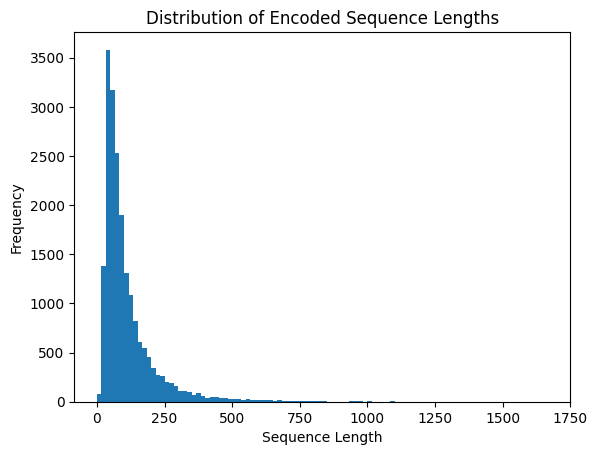

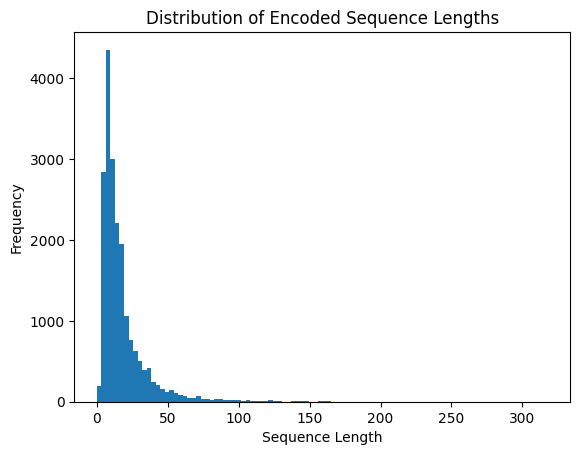

In [ ]:
import matplotlib.pyplot as plt

encoded_sequences = [[char_to_index[char] for char in sentence if char in char_to_index] for sentence in opt_set]
print(opt_set[3].split())
print(len(opt_set[3].split()))
print(encoded_sequences[3])
print(len(encoded_sequences[3]))
splits=[len(seq.split()) for seq in opt_set]
print(splits)
ecnsplits=[len(seq) for seq in encoded_sequences]
print(ecnsplits)

encoded_sequences_lens = [len(seq) for seq in encoded_sequences]

plt.hist(encoded_sequences_lens, bins=100)  # Adjust bins as needed
plt.title('Distribution of Encoded Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

encoded_sequences_lens = [len(seq.split()) for seq in opt_set]

plt.hist(encoded_sequences_lens, bins=100)  # Adjust bins as needed
plt.title('Distribution of Encoded Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Sample corpus (replace this with your actual sentences or opt_set)
sentences = opt_set[:4]

# Build vocabulary from opt_set (flatten the list of sentences)
vocab = list(set(word for sent in opt_set for word in sent.split()))  # Unique words

print(vocab)

print(f"Vocabulary size: {len(vocab)}")

# One-hot encoding
encoder = OneHotEncoder(sparse_output=False)  # Set sparse_output=False to get dense output
one_hot = encoder.fit_transform(np.array(vocab).reshape(-1, 1))

# Create word to vector mapping
word_to_vec = {word: one_hot[i] for i, word in enumerate(vocab)}

# Encode a sentence
try:
    encoded_sentence = [word_to_vec[word] for word in sentences[0]]
    print("One-hot encoded sentence shape:", np.array(encoded_sentence).shape)
except KeyError as e:
    print(f"Word not found in vocabulary: {e}")
    if e in stop_words:
      print ("stop")


['agrement', 'fan', 'romanesc', 'atrasă', 'vaucer', 'cumpăra', 'craiova', 'inpachetat', 'ergonomic', 'spatar', 'aerisire', 'clemă', 'calcul', 'raport', 'iesi', 'transpirație', 'slefuire', 'furat', 'incepand', 'aparut', 'mostru', 'masculin', 'nerabdare', 'absentă', 'formata', 'ridicat', 'gratis', 'criteriu', 'specialitate', 'buletin', 'benefica', 'bicicleta', 'strategie', 'laudat', 'pinie', 'dept', 'larg', 'fits', 'perfectly', 'detine', 'nouă', 'hartă', 'primi', 'curbă', 'scartaia', 'knee', 'complex', 'centrare', 'schimba', 'cusut', 'sabot', 'crăpa', 'audio', 'piată', 'platesti', 'manivelă', 'iepuras', 'electric', 'incolo', 'profesională', 'filet', 'soluție', 'estima', 'procesare', 'securitate', 'aparatoare', 'redirectiona', 'workshop', 'cautare', 'acord', 'sibiu', 'strap', 'baut', 'stati', 'animal', 'proces', 'înoate', 'periodic', 'infractor', 'urî', 'utila', 'dinaintea', 'celălat', 'slabut', 'porti', 'tais', 'afara', 'borcan', 'discret', 'privire', 'cot', 'operatie', 'average', 'arunc

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Step 1: Build vocabulary
vocab = {word: idx + 1 for idx, word in enumerate(set(word for sent in opt_set for word in sent.split()))}
print(f"Vocabulary size: {len(vocab)}")

# Step 2: Encode the dataset
encoded_set = [[vocab[word] for word in sentence.split() if word in vocab] for sentence in opt_set]

# Step 3: Pad sequences to make them uniform
sequence_length = 100 # Define max sequence length
X_opt_encoded_words = pad_sequences(encoded_set, maxlen=sequence_length, padding='post', truncating='post')
y_opt = [1] * len(data_clean_pos) + [0] * len(data_clean_neg)

# Step 4: Split the dataset
# y_opt = [...]  # Provide your labels here
X_train, X_test, y_train, y_test = train_test_split(X_opt_encoded_words, y_opt, test_size=0.2, random_state=42)

# Print shapes to verify
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {len(y_train)}")
print(f"y_test shape: {len(y_test)}")
print(f"Example encoded sequence:\n{X_opt_encoded_words[0]}")
print(opt_set[0])


Vocabulary size: 6349
X_train shape: (16001, 100)
X_test shape: (4001, 100)
y_train shape: 16001
y_test shape: 4001
Example encoded sequence:
[3062 5949 6134  451  408 2247 4023 5995 1698    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
bicicletă excelent începător sine rapid și nu ocupa loc


In [ ]:
X_opt_encoded_words=np.array(X_opt_encoded_words)
X_opt_encoded_letters=np.array(X_opt_encoded_letters)
y_opt=np.array(y_opt)


In [ ]:
X_opt_w2v_p = pad_sequences(X_opt_w2v, maxlen=100, padding='post', truncating='post').astype('float32')
X_opt_w2v_p=np.array(X_opt_w2v_p)

In [ ]:
print(X_opt_w2v_p.shape)

(20002, 100, 300)


In [ ]:
import optuna
from tensorflow.keras import layers, models
from sklearn.metrics import f1_score
import numpy as np

# Variables to keep track of the best trial
best_accuracy = -1
best_params = None
best_f1_score = None

def objective_rnn(trial):
    global best_accuracy, best_params, best_f1_score

    # Define the model architecture
    model = models.Sequential()

    # X_set=X_opt_w2v_p
    # max_len = trial.suggest_int('max_len', 5, 100)
    # len2=300

    # X_set=X_opt_encoded_words
    # max_len = trial.suggest_int('max_len', 5, 100)
    # len2=1

    X_set=X_opt_encoded_letters
    max_len = trial.suggest_int('max_len', 25, 500)
    len2=1

    X_set=[sent[:max_len] for sent in X_set]
    X_set=np.array(X_set)

    X_train, X_test, y_train, y_test = train_test_split(X_set, y_opt, test_size=0.2, random_state=42)


    X_train = np.array(X_train)
    X_test = np.array(X_test)

    max_len = X_train.shape[1]  # Use the actual max_len from padded_set


    # Reshape to (num_samples, timesteps, features=1) since each character is a single feature
    X_train = X_train.reshape(X_train.shape[0], max_len,len2)# X_train.shape[2])  # 150 timesteps, 1 feature per timestep
    X_test = X_test.reshape(X_test.shape[0], max_len,len2)# X_train.shape[2])

    model.add(layers.Input(shape=(max_len,len2)))# X_train.shape[2])))  # 150 timesteps, 1 feature per timestep

    leyerz=trial.suggest_int('num_rnn_layers', 1,3)

    num_rnn_layers = trial.suggest_int("num_rnn_layers", 1, 3)
    for i in range(num_rnn_layers):
        units = trial.suggest_int(f"units_l{i}", 32, 128)
        return_sequences = (i < num_rnn_layers - 1)  # True for all but last layer
        model.add(
            layers.SimpleRNN(
                units, return_sequences=return_sequences, activation="tanh"
            )
        )
        if trial.suggest_categorical(f"dropout_rnn_l{i}", [True, False]):
            model.add(layers.Dropout(rate=trial.suggest_float(f"dropout_rate_rnn_l{i}", 0.1, 0.5)))


    # Add dense layers
    for i in range(trial.suggest_int('num_dense_layers', 1, 2)):
        units = trial.suggest_int(f'units_l_dense{i}', 64, 256)
        model.add(layers.Dense(units, activation='relu'))
        if trial.suggest_categorical(f'dropout_dense_l{i}', [True, False]):
            model.add(layers.Dropout(rate=trial.suggest_float(f'dropout_dense_rate_l{i}', 0.1, 0.5)))

    # Output layer for binary classification
    model.add(layers.Dense(2, activation='softmax'))  # Assuming binary classification (2 classes)

    # Compile the model
    model.compile(
        optimizer=trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']  # Optimizing based on accuracy
    )

    # Train the model
    history = model.fit(X_train, y_train, epochs=trial.suggest_int('epochs', 1, 10), validation_split=0.2, verbose=0)

    # Evaluate the model on the training data (or validation split if you want to evaluate on unseen data)
    score = model.evaluate(X_test, y_test, verbose=0)

    # Log accuracy (this will be used for optimization)
    accuracy = score[1]

    # Calculate F1 score x_opt
    y_pred_prob = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    f1 = f1_score(y_test, y_pred)

    # Check if this trial has the best accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_f1_score = f1
        best_params = trial.params

    return accuracy  # Return accuracy for optimization

def run_opt_rnn(study=None):
    global best_accuracy, best_params, best_f1_score

    # Reinitialize variables for each run
    best_accuracy = -1
    best_params = None
    best_f1_score = None

    if study is None:
        study = optuna.create_study(direction='maximize')
    study.optimize(objective_rnn, n_trials=50, n_jobs=-1)

    results = (study.best_params, study.best_value)
    print("Best parameters found: ", study.best_params)
    print("Best accuracy score: ", study.best_value)
    print("Best F1 score: ", best_f1_score)
    return study

# Print results for multiple runs
results_list = []
for _ in range(5):
    study = run_opt_rnn()
    results_list.append({
        'best_params': best_params,
        'best_accuracy': best_accuracy,
        'best_f1_score': best_f1_score
    })
    torch.cuda.empty_cache()

# Print the final list of results
for i, result in enumerate(results_list):
    print(f"Run {i + 1}: Best parameters: {result['best_params']}, Best accuracy: {result['best_accuracy']}, Best F1 score: {result['best_f1_score']}")


[I 2025-01-09 01:29:30,669] A new study created in memory with name: no-name-437ff80a-dbe0-4fc3-abcc-6b383a8b868e
[I 2025-01-09 01:40:32,782] Trial 2 finished with value: 0.49437639117240906 and parameters: {'max_len': 381, 'num_rnn_layers': 1, 'units_l0': 46, 'dropout_rnn_l0': True, 'dropout_rate_rnn_l0': 0.22926781402821017, 'num_dense_layers': 1, 'units_l_dense0': 192, 'dropout_dense_l0': True, 'dropout_dense_rate_l0': 0.3681400813825103, 'optimizer': 'sgd', 'epochs': 2}. Best is trial 2 with value: 0.49437639117240906.
[I 2025-01-09 01:44:40,051] Trial 8 finished with value: 0.5033741593360901 and parameters: {'max_len': 39, 'num_rnn_layers': 2, 'units_l0': 58, 'dropout_rnn_l0': False, 'units_l1': 122, 'dropout_rnn_l1': False, 'num_dense_layers': 1, 'units_l_dense0': 104, 'dropout_dense_l0': True, 'dropout_dense_rate_l0': 0.22521968563091269, 'optimizer': 'adam', 'epochs': 10}. Best is trial 8 with value: 0.5033741593360901.
[I 2025-01-09 01:52:51,121] Trial 9 finished with value: 

KeyboardInterrupt: 

In [ ]:
import optuna
from tensorflow.keras import layers, models
from sklearn.metrics import f1_score
import numpy as np

# Variables to keep track of the best trial
best_accuracy = -1
best_params = None
best_f1_score = None

def objective_brnn(trial):
    global best_accuracy, best_params, best_f1_score

    # Define the model architecture
    model = models.Sequential()


    # X_set=X_opt_w2v_p
    # max_len = trial.suggest_int('max_len', 5, 100)
    # len2=300

    X_set=X_opt_encoded_words
    max_len = trial.suggest_int('max_len', 5, 100)
    len2=1

    # X_set=X_opt_encoded_letters
    # max_len = trial.suggest_int('max_len', 25, 500)
    #len2=1

    X_set=[sent[:max_len] for sent in X_set]
    X_set=np.array(X_set)

    X_train, X_test, y_train, y_test = train_test_split(X_set, y_opt, test_size=0.2, random_state=42)


    X_train = np.array(X_train)
    X_test = np.array(X_test)

    max_len = X_train.shape[1]  # Use the actual max_len from padded_set


    # Reshape to (num_samples, timesteps, features=1) since each character is a single feature
    X_train = X_train.reshape(X_train.shape[0], max_len,len2)# X_train.shape[2])  # 150 timesteps, 1 feature per timestep
    X_test = X_test.reshape(X_test.shape[0], max_len,len2)# X_train.shape[2])

    model.add(layers.Input(shape=(max_len,len2)))# X_train.shape[2])))  # 150 timesteps, 1 feature per timestep

    leyerz=trial.suggest_int('num_rnn_layers', 1,3)

    num_rnn_layers = trial.suggest_int("num_rnn_layers", 1, 3)
    for i in range(num_rnn_layers):
        units = trial.suggest_int(f"units_l{i}", 32, 128)
        return_sequences = (i < num_rnn_layers - 1)  # True for all but last layer
        model.add(
            layers.Bidirectional(
            layers.SimpleRNN(
                units, return_sequences=return_sequences, activation="tanh"
            )
        ))
        if trial.suggest_categorical(f"dropout_rnn_l{i}", [True, False]):
            model.add(layers.Dropout(rate=trial.suggest_float(f"dropout_rate_rnn_l{i}", 0.1, 0.5)))


    # Add dense layers
    for i in range(trial.suggest_int('num_dense_layers', 1, 2)):
        units = trial.suggest_int(f'units_l_dense{i}', 64, 256)
        model.add(layers.Dense(units, activation='relu'))
        if trial.suggest_categorical(f'dropout_dense_l{i}', [True, False]):
            model.add(layers.Dropout(rate=trial.suggest_float(f'dropout_dense_rate_l{i}', 0.1, 0.5)))

    # Output layer for binary classification
    model.add(layers.Dense(2, activation='softmax'))  # Assuming binary classification (2 classes)

    # Compile the model
    model.compile(
        optimizer=trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']  # Optimizing based on accuracy
    )

    # Train the model
    history = model.fit(X_train, y_train, epochs=trial.suggest_int('epochs', 1, 10), validation_split=0.2, verbose=0)

    # Evaluate the model on the training data (or validation split if you want to evaluate on unseen data)
    score = model.evaluate(X_test, y_test, verbose=0)

    # Log accuracy (this will be used for optimization)
    accuracy = score[1]

    # Calculate F1 score x_opt
    y_pred_prob = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    f1 = f1_score(y_test, y_pred)

    # Check if this trial has the best accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_f1_score = f1
        best_params = trial.params

    return accuracy  # Return accuracy for optimization

def run_opt_brnn(study=None):
    global best_accuracy, best_params, best_f1_score

    # Reinitialize variables for each run
    best_accuracy = -1
    best_params = None
    best_f1_score = None

    if study is None:
        study = optuna.create_study(direction='maximize')
    study.optimize(objective_brnn, n_trials=50, n_jobs=-1)

    results = (study.best_params, study.best_value)
    print("Best parameters found: ", study.best_params)
    print("Best accuracy score: ", study.best_value)
    print("Best F1 score: ", best_f1_score)
    return study

# Print results for multiple runs
results_list = []
for _ in range(5):
    study = run_opt_brnn()
    results_list.append({
        'best_params': best_params,
        'best_accuracy': best_accuracy,
        'best_f1_score': best_f1_score
    })
    torch.cuda.empty_cache()

# Print the final list of results
for i, result in enumerate(results_list):
    print(f"Run {i + 1}: Best parameters: {result['best_params']}, Best accuracy: {result['best_accuracy']}, Best F1 score: {result['best_f1_score']}")


[I 2025-01-09 02:03:14,194] A new study created in memory with name: no-name-83a2ac0d-c99b-4397-be08-69de54cae4c1
[I 2025-01-09 02:06:15,705] Trial 10 finished with value: 0.6105973720550537 and parameters: {'max_len': 22, 'num_rnn_layers': 2, 'units_l0': 35, 'dropout_rnn_l0': True, 'dropout_rate_rnn_l0': 0.4671216014682199, 'units_l1': 107, 'dropout_rnn_l1': True, 'dropout_rate_rnn_l1': 0.27323837348403357, 'num_dense_layers': 1, 'units_l_dense0': 100, 'dropout_dense_l0': False, 'optimizer': 'adam', 'epochs': 1}. Best is trial 10 with value: 0.6105973720550537.
[I 2025-01-09 02:06:39,847] Trial 9 finished with value: 0.6113471388816833 and parameters: {'max_len': 22, 'num_rnn_layers': 3, 'units_l0': 62, 'dropout_rnn_l0': True, 'dropout_rate_rnn_l0': 0.1293872321974474, 'units_l1': 49, 'dropout_rnn_l1': True, 'dropout_rate_rnn_l1': 0.1197898573690026, 'units_l2': 61, 'dropout_rnn_l2': False, 'num_dense_layers': 1, 'units_l_dense0': 224, 'dropout_dense_l0': False, 'optimizer': 'sgd', 'e

Best parameters found:  {'max_len': 28, 'num_rnn_layers': 2, 'units_l0': 49, 'dropout_rnn_l0': False, 'units_l1': 70, 'dropout_rnn_l1': False, 'num_dense_layers': 1, 'units_l_dense0': 96, 'dropout_dense_l0': False, 'optimizer': 'adam', 'epochs': 10}
Best accuracy score:  0.6155961155891418
Best F1 score:  0.6250609458800586


NameError: name 'torch' is not defined

In [ ]:
import optuna
from tensorflow.keras import layers, models
from sklearn.metrics import f1_score
import numpy as np

# Variables to keep track of the best trial
best_accuracy = -1
best_params = None
best_f1_score = None

def objective_lstm(trial):
    global best_accuracy, best_params, best_f1_score

    # Define the model architecture
    model = models.Sequential()

    # X_set=X_opt_w2v_p
    # max_len = trial.suggest_int('max_len', 5, 100)
    # len2=300

    X_set=X_opt_encoded_words
    max_len = trial.suggest_int('max_len', 5, 100)
    len2=1

    # X_set=X_opt_encoded_letters
    # max_len = trial.suggest_int('max_len', 25, 500)
    #len2=1

    # print(max_len)

    X_set=[sent[:max_len] for sent in X_set]
    X_set=np.array(X_set)

    X_train, X_test, y_train, y_test = train_test_split(X_set, y_opt, test_size=0.2, random_state=42)


    X_train = np.array(X_train)
    X_test = np.array(X_test)

    # max_len = X_train.shape[1]  # Use the actual max_len from padded_set

    # print(max_len)
    # Reshape to (num_samples, timesteps, features=1) since each character is a single feature
    X_train = X_train.reshape(X_train.shape[0], max_len,len2)# X_train.shape[2])  # 150 timesteps, 1 feature per timestep
    X_test = X_test.reshape(X_test.shape[0], max_len,len2)# X_train.shape[2])

    model.add(layers.Input(shape=(max_len,len2)))# X_train.shape[2])))  # 150 timesteps, 1 feature per timestep

    leyerz=trial.suggest_int('num_lstm_layers', 1,3)

    # print(shape(X_train))

    num_lstm_layers = trial.suggest_int("num_lstm_layers", 1, 3)
    for i in range(num_lstm_layers):
        units = trial.suggest_int(f"units_l{i}", 32, 128)
        return_sequences = (i < num_lstm_layers - 1)  # True for all but last layer
        model.add(
            layers.LSTM(
                units, return_sequences=return_sequences, activation="tanh"
            )
        )
        if trial.suggest_categorical(f"dropout_lstm_l{i}", [True, False]):
            model.add(layers.Dropout(rate=trial.suggest_float(f"dropout_rate_lstm_l{i}", 0.1, 0.5)))


    # Add dense layers
    for i in range(trial.suggest_int('num_dense_layers', 1, 2)):
        units = trial.suggest_int(f'units_l_dense{i}', 64, 256)
        model.add(layers.Dense(units, activation='relu'))
        if trial.suggest_categorical(f'dropout_dense_l{i}', [True, False]):
            model.add(layers.Dropout(rate=trial.suggest_float(f'dropout_dense_rate_l{i}', 0.1, 0.5)))

    # Output layer for binary classification
    model.add(layers.Dense(2, activation='softmax'))  # Assuming binary classification (2 classes)

    # Compile the model
    model.compile(
        optimizer=trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']  # Optimizing based on accuracy
    )

    # Train the model
    history = model.fit(X_train, y_train, epochs=trial.suggest_int('epochs', 1, 10), validation_split=0.2, verbose=0)

    # Evaluate the model on the training data (or validation split if you want to evaluate on unseen data)
    score = model.evaluate(X_test, y_test, verbose=0)

    # Log accuracy (this will be used for optimization)
    accuracy = score[1]

    # Calculate F1 score x_opt
    y_pred_prob = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    f1 = f1_score(y_test, y_pred)

    # Check if this trial has the best accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_f1_score = f1
        best_params = trial.params

    return accuracy  # Return accuracy for optimization

def run_opt_lstm(study=None):
    global best_accuracy, best_params, best_f1_score

    # Reinitialize variables for each run
    best_accuracy = -1
    best_params = None
    best_f1_score = None

    if study is None:
        study = optuna.create_study(direction='maximize')
    study.optimize(objective_lstm, n_trials=50, n_jobs=-1)

    results = (study.best_params, study.best_value)
    print("Best parameters found: ", study.best_params)
    print("Best accuracy score: ", study.best_value)
    print("Best F1 score: ", best_f1_score)
    return study

# Print results for multiple runs
results_list = []
for _ in range(5):
    study = run_opt_lstm()
    results_list.append({
        'best_params': best_params,
        'best_accuracy': best_accuracy,
        'best_f1_score': best_f1_score
    })
    torch.cuda.empty_cache()

# Print the final list of results
for i, result in enumerate(results_list):
    print(f"Run {i + 1}: Best parameters: {result['best_params']}, Best accuracy: {result['best_accuracy']}, Best F1 score: {result['best_f1_score']}")


[I 2025-01-09 03:24:00,314] A new study created in memory with name: no-name-fa9cf784-5bc3-403f-9869-b561918406c3
[I 2025-01-09 03:24:46,873] Trial 0 finished with value: 0.5363659262657166 and parameters: {'max_len': 89, 'num_lstm_layers': 2, 'units_l0': 33, 'dropout_lstm_l0': False, 'units_l1': 120, 'dropout_lstm_l1': False, 'num_dense_layers': 1, 'units_l_dense0': 191, 'dropout_dense_l0': True, 'dropout_dense_rate_l0': 0.21550412592235452, 'optimizer': 'sgd', 'epochs': 1}. Best is trial 0 with value: 0.5363659262657166.
[I 2025-01-09 03:25:24,643] Trial 2 finished with value: 0.606098473072052 and parameters: {'max_len': 11, 'num_lstm_layers': 1, 'units_l0': 107, 'dropout_lstm_l0': True, 'dropout_rate_lstm_l0': 0.35527804426522425, 'num_dense_layers': 2, 'units_l_dense0': 220, 'dropout_dense_l0': False, 'units_l_dense1': 92, 'dropout_dense_l1': True, 'dropout_dense_rate_l1': 0.4100657453867159, 'optimizer': 'adam', 'epochs': 4}. Best is trial 2 with value: 0.606098473072052.
[I 2025

Best parameters found:  {'max_len': 81, 'num_lstm_layers': 3, 'units_l0': 110, 'dropout_lstm_l0': True, 'dropout_rate_lstm_l0': 0.3152347514312165, 'units_l1': 60, 'dropout_lstm_l1': True, 'dropout_rate_lstm_l1': 0.425299266777837, 'units_l2': 89, 'dropout_lstm_l2': False, 'num_dense_layers': 1, 'units_l_dense0': 75, 'dropout_dense_l0': False, 'optimizer': 'adam', 'epochs': 5}
Best accuracy score:  0.6178455352783203
Best F1 score:  0.6295129634116792


NameError: name 'torch' is not defined

In [ ]:
X_set=X_opt_w2v_p
max_len = 69
len2=300

# X_set=X_opt_encoded_words
# max_len = trial.suggest_int('max_len', 5, 100)
# len2=1

# X_set=X_opt_encoded_letters
# max_len = trial.suggest_int('max_len', 25, 500)
#len2=1

print(max_len)

X_set=[sent[:max_len] for sent in X_set]
X_set=np.array(X_set)

X_train, X_test, y_train, y_test = train_test_split(X_set, y_opt, test_size=0.2, random_state=42)


X_train = np.array(X_train)
X_test = np.array(X_test)

max_len = X_train.shape[1]  # Use the actual max_len from padded_set

print(max_len)

69
69


In [ ]:
w2v lstm
//[I 2025-01-09 00:38:32,024] Trial 6 finished with value: 0.7468132972717285 and parameters: {'max_len': 43, 'num_lstm_layers': 3, 'units_l0': 98, 'dropout_lstm_l0': False, 'units_l1': 125, 'dropout_lstm_l1': True, 'dropout_rate_lstm_l1': 0.44254030486340057, 'units_l2': 41, 'dropout_lstm_l2': False, 'num_dense_layers': 1, 'units_l_dense0': 178, 'dropout_dense_l0': False, 'optimizer': 'adam', 'epochs': 4}. Best is trial 6 with value: 0.7468132972717285.
Best parameters found:  {'num_lstm_layers': 2, 'units_l0': 56, 'dropout_lstm_l0': False, 'units_l1': 108, 'dropout_lstm_l1': True, 'dropout_rate_lstm_l1': 0.22535845372026425, 'num_dense_layers': 2, 'units_l_dense0': 182, 'dropout_dense_l0': True, 'dropout_dense_rate_l0': 0.4989773844346814, 'units_l_dense1': 109, 'dropout_dense_l1': True, 'dropout_dense_rate_l1': 0.4891978274342502, 'optimizer': 'adam', 'epochs': 4}
Best accuracy score:  0.7465633749961853
Best F1 score:  0.7491340920336467


SyntaxError: invalid syntax (<ipython-input-60-935ca6804f45>, line 1)

In [ ]:
import optuna
from tensorflow.keras import layers, models
from sklearn.metrics import f1_score
import numpy as np

# Variables to keep track of the best trial
best_accuracy = -1
best_params = None
best_f1_score = None

def objective_blstm(trial):
    global best_accuracy, best_params, best_f1_score

    # Define the model architecture
    model = models.Sequential()

    # X_set=X_opt_w2v_p
    # max_len = trial.suggest_int('max_len', 5, 100)
    # len2=300

    X_set=X_opt_encoded_words
    max_len = trial.suggest_int('max_len', 5, 100)
    len2=1

    # X_set=X_opt_encoded_letters
    # max_len = trial.suggest_int('max_len', 25, 500)
    #len2=1

    X_set=[sent[:max_len] for sent in X_set]
    X_set=np.array(X_set)

    X_train, X_test, y_train, y_test = train_test_split(X_set, y_opt, test_size=0.2, random_state=42)


    X_train = np.array(X_train)
    X_test = np.array(X_test)

    max_len = X_train.shape[1]  # Use the actual max_len from padded_set


    # Reshape to (num_samples, timesteps, features=1) since each character is a single feature
    X_train = X_train.reshape(X_train.shape[0], max_len,len2)# X_train.shape[2])  # 150 timesteps, 1 feature per timestep
    X_test = X_test.reshape(X_test.shape[0], max_len,len2)# X_train.shape[2])

    model.add(layers.Input(shape=(max_len,len2)))# X_train.shape[2])))  # 150 timesteps, 1 feature per timestep

    leyerz=trial.suggest_int('num_lstm_layers', 1,3)

    num_lstm_layers = trial.suggest_int("num_lstm_layers", 1, 3)
    for i in range(num_lstm_layers):
        units = trial.suggest_int(f"units_l{i}", 32, 128)
        return_sequences = (i < num_lstm_layers - 1)  # True for all but last layer
        model.add(
            layers.Bidirectional(
                layers.LSTM(
                    units, return_sequences=return_sequences, activation="tanh"
                )
            )
        )
        if trial.suggest_categorical(f"dropout_lstm_l{i}", [True, False]):
            model.add(layers.Dropout(rate=trial.suggest_float(f"dropout_rate_lstm_l{i}", 0.1, 0.5)))


    # Add dense layers
    for i in range(trial.suggest_int('num_dense_layers', 1, 2)):
        units = trial.suggest_int(f'units_l_dense{i}', 64, 256)
        model.add(layers.Dense(units, activation='relu'))
        if trial.suggest_categorical(f'dropout_dense_l{i}', [True, False]):
            model.add(layers.Dropout(rate=trial.suggest_float(f'dropout_dense_rate_l{i}', 0.1, 0.5)))

    # Output layer for binary classification
    model.add(layers.Dense(2, activation='softmax'))  # Assuming binary classification (2 classes)

    # Compile the model
    model.compile(
        optimizer=trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']  # Optimizing based on accuracy
    )

    # Train the model
    history = model.fit(X_train, y_train, epochs=trial.suggest_int('epochs', 1, 10), validation_split=0.2, verbose=0)

    # Evaluate the model on the training data (or validation split if you want to evaluate on unseen data)
    score = model.evaluate(X_test, y_test, verbose=0)

    # Log accuracy (this will be used for optimization)
    accuracy = score[1]

    # Calculate F1 score x_opt
    y_pred_prob = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    f1 = f1_score(y_test, y_pred)

    # Check if this trial has the best accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_f1_score = f1
        best_params = trial.params

    return accuracy  # Return accuracy for optimization

def run_opt_blstm(study=None):
    global best_accuracy, best_params, best_f1_score

    # Reinitialize variables for each run
    best_accuracy = -1
    best_params = None
    best_f1_score = None

    if study is None:
        study = optuna.create_study(direction='maximize')
    study.optimize(objective_blstm, n_trials=50, n_jobs=-1)

    results = (study.best_params, study.best_value)
    print("Best parameters found: ", study.best_params)
    print("Best accuracy score: ", study.best_value)
    print("Best F1 score: ", best_f1_score)
    return study

# Print results for multiple runs
results_list = []
for _ in range(5):
    study = run_opt_blstm()
    results_list.append({
        'best_params': best_params,
        'best_accuracy': best_accuracy,
        'best_f1_score': best_f1_score
    })
    torch.cuda.empty_cache()

# Print the final list of results
for i, result in enumerate(results_list):
    print(f"Run {i + 1}: Best parameters: {result['best_params']}, Best accuracy: {result['best_accuracy']}, Best F1 score: {result['best_f1_score']}")


[I 2025-01-09 17:03:59,708] A new study created in memory with name: no-name-6714db76-126b-4f0a-9aca-690a29913b77
[I 2025-01-09 17:04:28,077] Trial 4 finished with value: 0.6038490533828735 and parameters: {'max_len': 50, 'num_lstm_layers': 1, 'units_l0': 125, 'dropout_lstm_l0': True, 'dropout_rate_lstm_l0': 0.31756011011655005, 'num_dense_layers': 2, 'units_l_dense0': 250, 'dropout_dense_l0': False, 'units_l_dense1': 204, 'dropout_dense_l1': True, 'dropout_dense_rate_l1': 0.1146379342642943, 'optimizer': 'sgd', 'epochs': 7}. Best is trial 3 with value: 0.6148462891578674.
[I 2025-01-09 17:05:00,294] Trial 1 finished with value: 0.6118470430374146 and parameters: {'max_len': 52, 'num_lstm_layers': 1, 'units_l0': 63, 'dropout_lstm_l0': False, 'num_dense_layers': 2, 'units_l_dense0': 72, 'dropout_dense_l0': False, 'units_l_dense1': 185, 'dropout_dense_l1': False, 'optimizer': 'sgd', 'epochs': 8}. Best is trial 3 with value: 0.6148462891578674.
[I 2025-01-09 17:05:43,621] Trial 8 finished

Best parameters found:  {'max_len': 60, 'num_lstm_layers': 2, 'units_l0': 35, 'dropout_lstm_l0': False, 'units_l1': 55, 'dropout_lstm_l1': True, 'dropout_rate_lstm_l1': 0.25149683357232877, 'num_dense_layers': 2, 'units_l_dense0': 185, 'dropout_dense_l0': False, 'units_l_dense1': 110, 'dropout_dense_l1': True, 'dropout_dense_rate_l1': 0.22416098475589574, 'optimizer': 'adam', 'epochs': 10}
Best accuracy score:  0.6210947036743164
Best F1 score:  0.6187122736418511


NameError: name 'torch' is not defined

In [ ]:
rez1=[{'rnn':
            {'word':
                    {'Best parameters found':  {'max_len': 41, 'num_rnn_layers': 1, 'units_l0': 59, 'dropout_rnn_l0': False, 'num_dense_layers': 2, 'units_l_dense0': 65, 'dropout_dense_l0': False, 'units_l_dense1': 66, 'dropout_dense_l1': False, 'optimizer': 'sgd', 'epochs': 9},
                    'Best accuracy score':  0.6143463850021362,
                    'Best F1 score':  0.6230149034937699},
                'letter':
                    {'Best parameters found':  {'num_rnn_layers': 1, 'units_l0': 55, 'dropout_rnn_l0': False, 'num_dense_layers': 1, 'units_l_dense0': 165, 'dropout_dense_l0': False, 'optimizer': 'adam', 'epochs': 5},
                    'Best accuracy score':  0.6190952062606812,
                    'Best F1 score':  0.6641692375495813},

            'w2v':
                  {'Best parameters found':  {'max_len': 19, 'num_rnn_layers': 2, 'units_l0': 92, 'dropout_rnn_l0': True, 'dropout_rate_rnn_l0': 0.22061046197228457, 'units_l1': 89, 'dropout_rnn_l1': False, 'num_dense_layers': 2, 'units_l_dense0': 84, 'dropout_dense_l0': True, 'dropout_dense_rate_l0': 0.23539148651840258, 'units_l_dense1': 205, 'dropout_dense_l1': True, 'dropout_dense_rate_l1': 0.105047127749026, 'optimizer': 'adam', 'epochs': 6},
                  'Best accuracy score':  0.7208197712898254,
                  'Best F1 score':  0.7044491525423728}
            }
      }]

In [ ]:
rez2=[{'brnn':
            {'w2v':
                  {'parameters':  {'max_len': 81, 'num_rnn_layers': 3, 'units_l0': 125, 'dropout_rnn_l0': False, 'units_l1': 37, 'dropout_rnn_l1': False, 'units_l2': 64, 'dropout_rnn_l2': False, 'num_dense_layers': 1, 'units_l_dense0': 152, 'dropout_dense_l0': True, 'dropout_dense_rate_l0': 0.28866262381300056, 'optimizer': 'adam', 'epochs': 6},
                  'accuracy':  0.7333166599273682,
                  'F1':  0.7363479120336052},
            'word':
                  {'parameters':  {'max_len': 28, 'num_rnn_layers': 2, 'units_l0': 49, 'dropout_rnn_l0': False, 'units_l1': 70, 'dropout_rnn_l1': False, 'num_dense_layers': 1, 'units_l_dense0': 96, 'dropout_dense_l0': False, 'optimizer': 'adam', 'epochs': 10},
                  'accuracy':  0.6155961155891418,
                  'F1':  0.6250609458800586}
            }
      }]

In [ ]:
rez3=[{'lstm':
            {'w2v':
                  {'parameters': {'max_len': 43, 'num_lstm_layers': 3, 'units_l0': 98, 'dropout_lstm_l0': False, 'units_l1': 125, 'dropout_lstm_l1': True, 'dropout_rate_lstm_l1': 0.44254030486340057, 'units_l2': 41, 'dropout_lstm_l2': False, 'num_dense_layers': 1, 'units_l_dense0': 178, 'dropout_dense_l0': False, 'optimizer': 'adam', 'epochs': 4},
                  'accuracy': 0.7468132972717285,
                  'F1': 0.7468132972717285},
            'word':
                  {'parameters':  {'max_len': 81, 'num_lstm_layers': 3, 'units_l0': 110, 'dropout_lstm_l0': True, 'dropout_rate_lstm_l0': 0.3152347514312165, 'units_l1': 60, 'dropout_lstm_l1': True, 'dropout_rate_lstm_l1': 0.425299266777837, 'units_l2': 89, 'dropout_lstm_l2': False, 'num_dense_layers': 1, 'units_l_dense0': 75, 'dropout_dense_l0': False, 'optimizer': 'adam', 'epochs': 5},
                  'accuracy':  0.6178455352783203,
                  'F1':  0.6295129634116792}
             }
       }]


In [ ]:
rez4=[{'blstm':
            {'w2v':
                  {'parameters':  {'max_len': 60, 'num_lstm_layers': 2, 'units_l0': 107, 'dropout_lstm_l0': True, 'dropout_rate_lstm_l0': 0.14358991845052868, 'units_l1': 41, 'dropout_lstm_l1': False, 'num_dense_layers': 2, 'units_l_dense0': 94, 'dropout_dense_l0': True, 'dropout_dense_rate_l0': 0.2819323238505278, 'units_l_dense1': 95, 'dropout_dense_l1': True, 'dropout_dense_rate_l1': 0.16012611463695886, 'optimizer': 'adam', 'epochs': 3},
                  'accuracy':  0.7503124475479126,
                  'F1':  0.7411246436900751},
            'word':
                  {'parameters':  {'max_len': 60, 'num_lstm_layers': 2, 'units_l0': 35, 'dropout_lstm_l0': False, 'units_l1': 55, 'dropout_lstm_l1': True, 'dropout_rate_lstm_l1': 0.25149683357232877, 'num_dense_layers': 2, 'units_l_dense0': 185, 'dropout_dense_l0': False, 'units_l_dense1': 110, 'dropout_dense_l1': True, 'dropout_dense_rate_l1': 0.22416098475589574, 'optimizer': 'adam', 'epochs': 10},
                  'accuracy':  0.6210947036743164,
                  'F1':  0.6187122736418511}
             }
      }]

In [ ]:
rez_sec=rez1+rez2+rez3+rez4
print(rez_sec)

[{'rnn': {'letter': {'Best parameters found': {'num_rnn_layers': 1, 'units_l0': 55, 'dropout_rnn_l0': False, 'num_dense_layers': 1, 'units_l_dense0': 165, 'dropout_dense_l0': False, 'optimizer': 'adam', 'epochs': 5}, 'Best accuracy score': 0.6190952062606812, 'Best F1 score': 0.6641692375495813}, 'word': {'Best parameters found': {'max_len': 41, 'num_rnn_layers': 1, 'units_l0': 59, 'dropout_rnn_l0': False, 'num_dense_layers': 2, 'units_l_dense0': 65, 'dropout_dense_l0': False, 'units_l_dense1': 66, 'dropout_dense_l1': False, 'optimizer': 'sgd', 'epochs': 9}, 'Best accuracy score': 0.6143463850021362, 'Best F1 score': 0.6230149034937699}, 'w2v': {'Best parameters found': {'max_len': 19, 'num_rnn_layers': 2, 'units_l0': 92, 'dropout_rnn_l0': True, 'dropout_rate_rnn_l0': 0.22061046197228457, 'units_l1': 89, 'dropout_rnn_l1': False, 'num_dense_layers': 2, 'units_l_dense0': 84, 'dropout_dense_l0': True, 'dropout_dense_rate_l0': 0.23539148651840258, 'units_l_dense1': 205, 'dropout_dense_l1':

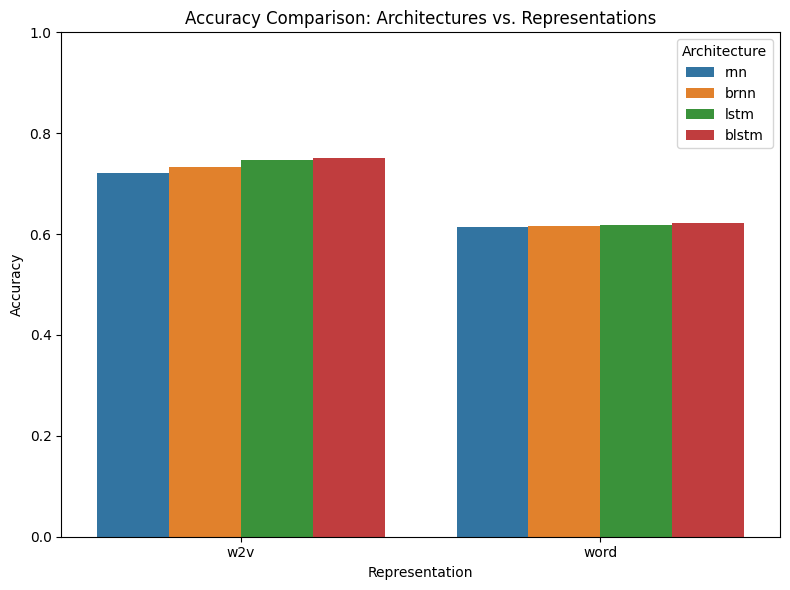

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Example results list (truncated to only relevant accuracy fields)
results = rez_sec

# Architectures in the desired order
architectures = ["rnn", "brnn", "lstm", "blstm"]

# We'll create a list of dictionaries, each describing one (architecture, representation, accuracy).
acc_data = []

# For rnn (the first item), the w2v and word accuracies use "Best accuracy score"
acc_data.append({"architecture": "rnn", "representation": "w2v",
                 "accuracy": results[0]["rnn"]["w2v"]["Best accuracy score"]})
acc_data.append({"architecture": "rnn", "representation": "word",
                 "accuracy": results[0]["rnn"]["word"]["Best accuracy score"]})

# For brnn, lstm, blstm, the w2v and word accuracies use "accuracy"
acc_data.append({"architecture": "brnn", "representation": "w2v",
                 "accuracy": results[1]["brnn"]["w2v"]["accuracy"]})
acc_data.append({"architecture": "brnn", "representation": "word",
                 "accuracy": results[1]["brnn"]["word"]["accuracy"]})

acc_data.append({"architecture": "lstm", "representation": "w2v",
                 "accuracy": results[2]["lstm"]["w2v"]["accuracy"]})
acc_data.append({"architecture": "lstm", "representation": "word",
                 "accuracy": results[2]["lstm"]["word"]["accuracy"]})

acc_data.append({"architecture": "blstm", "representation": "w2v",
                 "accuracy": results[3]["blstm"]["w2v"]["accuracy"]})
acc_data.append({"architecture": "blstm", "representation": "word",
                 "accuracy": results[3]["blstm"]["word"]["accuracy"]})

# Convert this list of dicts into a DataFrame
df = pd.DataFrame(acc_data)

# Now we can use seaborn to plot a bar chart:
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x="representation", y="accuracy", hue="architecture")

plt.title("Accuracy Comparison: Architectures vs. Representations")
plt.ylim(0, 1.0)  # Assuming accuracy is in [0,1]
plt.xlabel("Representation")
plt.ylabel("Accuracy")
plt.legend(title="Architecture")
plt.tight_layout()
plt.show()


# Rezultate

In [ ]:
# Print all results 12 45 class
results1=[{'feature': 'bow', 'dimensionality': 'nonee', 'model': 'mnb', 'accuracy': 0.7486788021139166, 'f1_score': 0.7486302541154398, 'runtime': 7.6665332317352295},
{'feature': 'bow', 'dimensionality': 'nonee', 'model': 'svm', 'accuracy': 0.7527891955372872, 'f1_score': 0.7525792470841206, 'runtime': 7.978166580200195},
{'feature': 'bow', 'dimensionality': 'pca', 'model': 'mnb', 'accuracy': 0.6717557251908397, 'f1_score': 0.6689674257359827, 'runtime': 174.0944983959198},
{'feature': 'bow', 'dimensionality': 'pca', 'model': 'svm', 'accuracy': 0.7445684086905461, 'f1_score': 0.7438200938900575, 'runtime': 123.98090100288391},
{'feature': 'bow', 'dimensionality': 'pca', 'model': 'lr', 'accuracy': 0.7363476218438051, 'f1_score': 0.7357941502408074, 'runtime': 52.22433805465698},
{'feature': 'bow', 'dimensionality': 'nonee', 'model': 'knn', 'accuracy': 0.6083382266588373, 'f1_score': 0.5643052649590139, 'runtime': 407.6216721534729},
{'feature': 'bow', 'dimensionality': 'lsa', 'model': 'mnb', 'accuracy': 0.6817381092190252, 'f1_score': 0.6780870852265453, 'runtime': 106.44340133666992},
{'feature': 'bow', 'dimensionality': 'pca', 'model': 'knn', 'accuracy': 0.61714621256606, 'f1_score': 0.5683645678062235, 'runtime': 145.30821132659912},
{'feature': 'bow', 'dimensionality': 'lsa', 'model': 'svm', 'accuracy': 0.7345860246623606, 'f1_score': 0.7342246066102199, 'runtime': 136.90037751197815},
{'feature': 'bow', 'dimensionality': 'nonee', 'model': 'rf', 'accuracy': 0.7381092190252495, 'f1_score': 0.7381173463114549, 'runtime': 619.1017451286316},
{'feature': 'tfidf', 'dimensionality': 'nonee', 'model': 'mnb', 'accuracy': 0.7445684086905461, 'f1_score': 0.7444997018752968, 'runtime': 3.067990303039551},
{'feature': 'bow', 'dimensionality': 'lsa', 'model': 'lr', 'accuracy': 0.7422196124486201, 'f1_score': 0.7417331255894631, 'runtime': 61.023773193359375},
{'feature': 'bow', 'dimensionality': 'lsa', 'model': 'knn', 'accuracy': 0.6106870229007634, 'f1_score': 0.5596966114549045, 'runtime': 127.77066326141357},
{'feature': 'tfidf', 'dimensionality': 'nonee', 'model': 'svm', 'accuracy': 0.7457428068115091, 'f1_score': 0.7457428068115091, 'runtime': 1.3247058391571045},
{'feature': 'bow', 'dimensionality': 'pca', 'model': 'rf', 'accuracy': 0.7093364650616559, 'f1_score': 0.7087110279070497, 'runtime': 708.9037618637085},
{'feature': 'tfidf', 'dimensionality': 'nonee', 'model': 'lr', 'accuracy': 0.7093364650616559, 'f1_score': 0.7092522324627272, 'runtime': 99.85187458992004},
{'feature': 'tfidf', 'dimensionality': 'pca', 'model': 'mnb', 'accuracy': 0.5689958896065767, 'f1_score': 0.47990813973080676, 'runtime': 118.3801200389862},
{'feature': 'tfidf', 'dimensionality': 'pca', 'model': 'lr', 'accuracy': 0.725778038755138, 'f1_score': 0.725786548772007, 'runtime': 130.3247516155243},
{'feature': 'tfidf', 'dimensionality': 'pca', 'model': 'svm', 'accuracy': 0.7345860246623606, 'f1_score': 0.7345940783592931, 'runtime': 115.51507091522217},
{'feature': 'bow', 'dimensionality': 'lsa', 'model': 'rf', 'accuracy': 0.6946564885496184, 'f1_score': 0.6942543380561776, 'runtime': 570.5982849597931},
{'feature': 'tfidf', 'dimensionality': 'nonee', 'model': 'rf', 'accuracy': 0.7287140340575455, 'f1_score': 0.7287205819240313, 'runtime': 375.4012608528137},
{'feature': 'tfidf', 'dimensionality': 'lsa', 'model': 'mnb', 'accuracy': 0.5654726952436876, 'f1_score': 0.47380549409408557, 'runtime': 99.33656239509583},
{'feature': 'tfidf', 'dimensionality': 'lsa', 'model': 'lr', 'accuracy': 0.725778038755138, 'f1_score': 0.7257717972496703, 'runtime': 107.14390230178833},
{'feature': 'tfidf', 'dimensionality': 'pca', 'model': 'knn', 'accuracy': 0.5278919553728714, 'f1_score': 0.40681291849388207, 'runtime': 151.34081315994263},
{'feature': 'tfidf', 'dimensionality': 'nonee', 'model': 'knn', 'accuracy': 0.5954198473282443, 'f1_score': 0.5444789709139817, 'runtime': 461.5770990848541},
{'feature': 'd2v_dm', 'dimensionality': 'nonee', 'model': 'mnb', 'accuracy': 0.6664709336465061, 'f1_score': 0.6662926218729538, 'runtime': 0.304884672164917},
{'feature': 'tfidf', 'dimensionality': 'lsa', 'model': 'svm', 'accuracy': 0.732824427480916, 'f1_score': 0.7328159521302509, 'runtime': 131.29765820503235},
{'feature': 'd2v_dm', 'dimensionality': 'nonee', 'model': 'lr', 'accuracy': 0.6946564885496184, 'f1_score': 0.6946373266692104, 'runtime': 89.29634141921997},
{'feature': 'd2v_dm', 'dimensionality': 'nonee', 'model': 'svm', 'accuracy': 0.7017028772753964, 'f1_score': 0.7016960889124905, 'runtime': 1.269709587097168},
{'feature': 'd2v_dm', 'dimensionality': 'nonee', 'model': 'knn', 'accuracy': 0.6664709336465061, 'f1_score': 0.6616433117553111, 'runtime': 25.15891671180725},
{'feature': 'd2v_dm', 'dimensionality': 'pca', 'model': 'mnb', 'accuracy': 0.6376981796829125, 'f1_score': 0.6299049507110005, 'runtime': 0.29500412940979004},
{'feature': 'tfidf', 'dimensionality': 'lsa', 'model': 'knn', 'accuracy': 0.532002348796242, 'f1_score': 0.41158292374700434, 'runtime': 168.2633810043335},
{'feature': 'd2v_dm', 'dimensionality': 'pca', 'model': 'lr', 'accuracy': 0.6987668819729889, 'f1_score': 0.6987367597933647, 'runtime': 8.58121395111084},
{'feature': 'd2v_dm', 'dimensionality': 'pca', 'model': 'svm', 'accuracy': 0.7052260716382853, 'f1_score': 0.7052295277038197, 'runtime': 0.6979837417602539},
{'feature': 'd2v_dm', 'dimensionality': 'pca', 'model': 'knn', 'accuracy': 0.6476805637110981, 'f1_score': 0.6393019372465821, 'runtime': 12.312079429626465},
{'feature': 'd2v_dm', 'dimensionality': 'lsa', 'model': 'mnb', 'accuracy': 0.6318261890780975, 'f1_score': 0.6215150165840141, 'runtime': 2.8477087020874023},
{'feature': 'd2v_dm', 'dimensionality': 'lsa', 'model': 'lr', 'accuracy': 0.6981796829125073, 'f1_score': 0.6981607421307193, 'runtime': 22.779863595962524},
{'feature': 'tfidf', 'dimensionality': 'pca', 'model': 'rf', 'accuracy': 0.715208455666471, 'f1_score': 0.7151534605459201, 'runtime': 542.190616607666},
{'feature': 'd2v_dm', 'dimensionality': 'lsa', 'model': 'svm', 'accuracy': 0.7017028772753964, 'f1_score': 0.7016960889124905, 'runtime': 3.698551893234253},
{'feature': 'd2v_dm', 'dimensionality': 'lsa', 'model': 'knn', 'accuracy': 0.6623605402231356, 'f1_score': 0.6546451471977838, 'runtime': 7.216609954833984},
{'feature': 'w2v', 'dimensionality': 'nonee', 'model': 'mnb', 'accuracy': 0.6512037580739871, 'f1_score': 0.6509763594759816, 'runtime': 0.14550328254699707},
{'feature': 'w2v', 'dimensionality': 'nonee', 'model': 'lr', 'accuracy': 0.725778038755138, 'f1_score': 0.7257576149681796, 'runtime': 19.083563804626465},
{'feature': 'd2v_dm', 'dimensionality': 'pca', 'model': 'rf', 'accuracy': 0.7087492660011744, 'f1_score': 0.7079701063205495, 'runtime': 153.21849036216736},
{'feature': 'w2v', 'dimensionality': 'nonee', 'model': 'svm', 'accuracy': 0.733998825601879, 'f1_score': 0.733998825601879, 'runtime': 1.9702067375183105},
{'feature': 'w2v', 'dimensionality': 'nonee', 'model': 'knn', 'accuracy': 0.6376981796829125, 'f1_score': 0.6106641767548062, 'runtime': 31.161241054534912},
{'feature': 'w2v', 'dimensionality': 'pca', 'model': 'mnb', 'accuracy': 0.6506165590135056, 'f1_score': 0.6502560956023765, 'runtime': 0.4762909412384033},
{'feature': 'w2v', 'dimensionality': 'pca', 'model': 'lr', 'accuracy': 0.7240164415736935, 'f1_score': 0.7239477275827588, 'runtime': 2.6651806831359863},
{'feature': 'd2v_dm', 'dimensionality': 'lsa', 'model': 'rf', 'accuracy': 0.7122724603640634, 'f1_score': 0.7116049445581595, 'runtime': 148.7070562839508},
{'feature': 'w2v', 'dimensionality': 'pca', 'model': 'svm', 'accuracy': 0.7251908396946565, 'f1_score': 0.7251328438857697, 'runtime': 0.408233642578125},
{'feature': 'w2v', 'dimensionality': 'pca', 'model': 'knn', 'accuracy': 0.6559013505578392, 'f1_score': 0.6308344219893443, 'runtime': 7.964322566986084},
{'feature': 'd2v_dm', 'dimensionality': 'nonee', 'model': 'rf', 'accuracy': 0.7128596594245449, 'f1_score': 0.7126980232972128, 'runtime': 246.1238088607788},
{'feature': 'w2v', 'dimensionality': 'lsa', 'model': 'mnb', 'accuracy': 0.6547269524368761, 'f1_score': 0.6543015585327315, 'runtime': 5.559019088745117},
{'feature': 'w2v', 'dimensionality': 'lsa', 'model': 'lr', 'accuracy': 0.726952436876101, 'f1_score': 0.7268997095955728, 'runtime': 11.193328857421875},
{'feature': 'w2v', 'dimensionality': 'lsa', 'model': 'svm', 'accuracy': 0.7287140340575455, 'f1_score': 0.7286904612830275, 'runtime': 1.7500922679901123},
{'feature': 'w2v', 'dimensionality': 'lsa', 'model': 'knn', 'accuracy': 0.6476805637110981, 'f1_score': 0.6205035368936448, 'runtime': 12.778631210327148},
{'feature': 'tfidf', 'dimensionality': 'lsa', 'model': 'rf', 'accuracy': 0.7193188490898414, 'f1_score': 0.7192944599421799, 'runtime': 486.62108993530273},
{'feature': 'bow', 'dimensionality': 'nonee', 'model': 'lr', 'accuracy': 0.7422196124486201, 'f1_score': 0.7418571727426665, 'runtime': 232.24538350105286},
{'feature': 'w2v', 'dimensionality': 'pca', 'model': 'rf', 'accuracy': 0.7017028772753964, 'f1_score': 0.701439027665655, 'runtime': 138.54185557365417},
{'feature': 'w2v', 'dimensionality': 'lsa', 'model': 'rf', 'accuracy': 0.7069876688197299, 'f1_score': 0.7066962867107449, 'runtime': 128.65682721138},
{'feature': 'w2v', 'dimensionality': 'nonee', 'model': 'rf', 'accuracy': 0.708162066940693, 'f1_score': 0.7077517422621987, 'runtime': 218.3228611946106}
]

In [ ]:
# Print all results 123 45 class
results2=[{'feature': 'bow', 'dimensionality': 'nonee', 'model': 'mnb', 'accuracy': 0.7315671082229442, 'f1_score': 0.7314593260238985, 'runtime': 17.46858286857605},
{'feature': 'bow', 'dimensionality': 'nonee', 'model': 'svm', 'accuracy': 0.7495626093476631, 'f1_score': 0.7495270538159639, 'runtime': 17.525248765945435},
{'feature': 'tfidf', 'dimensionality': 'nonee', 'model': 'mnb', 'accuracy': 0.7383154211447138, 'f1_score': 0.7367881532485264, 'runtime': 17.41380000114441},
{'feature': 'tfidf', 'dimensionality': 'nonee', 'model': 'svm', 'accuracy': 0.7390652336915771, 'f1_score': 0.7388723016724275, 'runtime': 35.17059922218323},
{'feature': 'tfidf', 'dimensionality': 'nonee', 'model': 'lr', 'accuracy': 0.7435641089727568, 'f1_score': 0.7435035486127962, 'runtime': 97.87524461746216},
{'feature': 'bow', 'dimensionality': 'lsa', 'model': 'mnb', 'accuracy': 0.6193451637090728, 'f1_score': 0.607648251392788, 'runtime': 204.2911205291748},
{'feature': 'bow', 'dimensionality': 'lsa', 'model': 'svm', 'accuracy': 0.741314671332167, 'f1_score': 0.7411998241612421, 'runtime': 214.37925124168396},
{'feature': 'bow', 'dimensionality': 'pca', 'model': 'mnb', 'accuracy': 0.6170957260684828, 'f1_score': 0.6053648480701127, 'runtime': 218.2939794063568},
{'feature': 'bow', 'dimensionality': 'lsa', 'model': 'knn', 'accuracy': 0.6190952261934516, 'f1_score': 0.5817803919184626, 'runtime': 226.06811141967773},
{'feature': 'bow', 'dimensionality': 'pca', 'model': 'svm', 'accuracy': 0.7405648587853036, 'f1_score': 0.7403470136626643, 'runtime': 239.9084267616272},
{'feature': 'bow', 'dimensionality': 'pca', 'model': 'knn', 'accuracy': 0.6258435391152212, 'f1_score': 0.5907227989930622, 'runtime': 241.78284621238708},
{'feature': 'tfidf', 'dimensionality': 'pca', 'model': 'mnb', 'accuracy': 0.612096975756061, 'f1_score': 0.5642137800156509, 'runtime': 167.74810671806335},
{'feature': 'bow', 'dimensionality': 'pca', 'model': 'lr', 'accuracy': 0.7405648587853036, 'f1_score': 0.7404104354232866, 'runtime': 124.06930565834045},
{'feature': 'bow', 'dimensionality': 'lsa', 'model': 'lr', 'accuracy': 0.7420644838790302, 'f1_score': 0.7419527444398564, 'runtime': 124.61543154716492},
{'feature': 'tfidf', 'dimensionality': 'nonee', 'model': 'knn', 'accuracy': 0.583104223944014, 'f1_score': 0.5224526218468563, 'runtime': 319.43087363243103},
{'feature': 'd2v_dm', 'dimensionality': 'nonee', 'model': 'mnb', 'accuracy': 0.6425893526618346, 'f1_score': 0.6395428285983483, 'runtime': 18.530869007110596},
{'feature': 'tfidf', 'dimensionality': 'lsa', 'model': 'lr', 'accuracy': 0.736065983504124, 'f1_score': 0.7360118983943608, 'runtime': 149.0386769771576},
{'feature': 'tfidf', 'dimensionality': 'lsa', 'model': 'mnb', 'accuracy': 0.614846288427893, 'f1_score': 0.5667381755303881, 'runtime': 165.1297869682312},
{'feature': 'd2v_dm', 'dimensionality': 'nonee', 'model': 'lr', 'accuracy': 0.6960759810047488, 'f1_score': 0.6960347794383618, 'runtime': 55.99249339103699},
{'feature': 'd2v_dm', 'dimensionality': 'nonee', 'model': 'svm', 'accuracy': 0.6960759810047488, 'f1_score': 0.696038539124649, 'runtime': 41.77191972732544},
{'feature': 'tfidf', 'dimensionality': 'pca', 'model': 'lr', 'accuracy': 0.7365658585353662, 'f1_score': 0.7365301459934485, 'runtime': 242.5451681613922},
{'feature': 'tfidf', 'dimensionality': 'pca', 'model': 'svm', 'accuracy': 0.730817295676081, 'f1_score': 0.7307007324718257, 'runtime': 228.59598326683044},
{'feature': 'd2v_dm', 'dimensionality': 'pca', 'model': 'mnb', 'accuracy': 0.6185953511622094, 'f1_score': 0.5985834863513675, 'runtime': 5.108133792877197},
{'feature': 'd2v_dm', 'dimensionality': 'pca', 'model': 'svm', 'accuracy': 0.688577855536116, 'f1_score': 0.6885799565861166, 'runtime': 0.5612578392028809},
{'feature': 'd2v_dm', 'dimensionality': 'pca', 'model': 'lr', 'accuracy': 0.6883279180204949, 'f1_score': 0.6883306437908824, 'runtime': 7.436001300811768},
{'feature': 'd2v_dm', 'dimensionality': 'lsa', 'model': 'mnb', 'accuracy': 0.6255936015996001, 'f1_score': 0.6078348296874914, 'runtime': 1.9024724960327148},
{'feature': 'd2v_dm', 'dimensionality': 'lsa', 'model': 'lr', 'accuracy': 0.6895776055986004, 'f1_score': 0.6895796999036572, 'runtime': 3.4508237838745117},
{'feature': 'd2v_dm', 'dimensionality': 'pca', 'model': 'knn', 'accuracy': 0.5928517870532367, 'f1_score': 0.5559085770562211, 'runtime': 7.654531478881836},
{'feature': 'd2v_dm', 'dimensionality': 'lsa', 'model': 'svm', 'accuracy': 0.6883279180204949, 'f1_score': 0.6883107843497536, 'runtime': 2.501047134399414},
{'feature': 'd2v_dm', 'dimensionality': 'nonee', 'model': 'knn', 'accuracy': 0.6088477880529868, 'f1_score': 0.5790966793327199, 'runtime': 16.02036142349243},
{'feature': 'tfidf', 'dimensionality': 'pca', 'model': 'knn', 'accuracy': 0.548862784303924, 'f1_score': 0.47000550434622856, 'runtime': 248.59803676605225},
{'feature': 'd2v_dm', 'dimensionality': 'lsa', 'model': 'knn', 'accuracy': 0.6033491627093227, 'f1_score': 0.5713093808898894, 'runtime': 16.702518463134766},
{'feature': 'tfidf', 'dimensionality': 'lsa', 'model': 'svm', 'accuracy': 0.7318170457385653, 'f1_score': 0.7315840326849823, 'runtime': 173.30966114997864},
{'feature': 'tfidf', 'dimensionality': 'lsa', 'model': 'knn', 'accuracy': 0.5466133466633342, 'f1_score': 0.46304040624929865, 'runtime': 179.24127745628357},
{'feature': 'd2v_dm', 'dimensionality': 'pca', 'model': 'rf', 'accuracy': 0.665083729067733, 'f1_score': 0.6646298398785931, 'runtime': 128.3309576511383},
{'feature': 'tfidf', 'dimensionality': 'nonee', 'model': 'rf', 'accuracy': 0.7268182954261435, 'f1_score': 0.7266347584083764, 'runtime': 558.4159598350525},
{'feature': 'bow', 'dimensionality': 'nonee', 'model': 'rf', 'accuracy': 0.7328167958010497, 'f1_score': 0.7327515269122367, 'runtime': 577.8166611194611},
{'feature': 'd2v_dm', 'dimensionality': 'lsa', 'model': 'rf', 'accuracy': 0.6740814796300925, 'f1_score': 0.673698337118976, 'runtime': 118.39994049072266},
{'feature': 'd2v_dm', 'dimensionality': 'nonee', 'model': 'rf', 'accuracy': 0.6738315421144714, 'f1_score': 0.6730267172687678, 'runtime': 226.55592513084412},
{'feature': 'bow', 'dimensionality': 'lsa', 'model': 'rf', 'accuracy': 0.6848287928017995, 'f1_score': 0.6832016129428259, 'runtime': 620.4283304214478},
{'feature': 'bow', 'dimensionality': 'pca', 'model': 'rf', 'accuracy': 0.688577855536116, 'f1_score': 0.6871134289340526, 'runtime': 638.5416786670685},
{'feature': 'tfidf', 'dimensionality': 'pca', 'model': 'rf', 'accuracy': 0.7073231692076981, 'f1_score': 0.7066999204463611, 'runtime': 463.50302743911743},
{'feature': 'tfidf', 'dimensionality': 'lsa', 'model': 'rf', 'accuracy': 0.7063234191452137, 'f1_score': 0.706022507107798, 'runtime': 398.4782786369324},
{'feature': 'bow', 'dimensionality': 'nonee', 'model': 'knn', 'accuracy': 0.6228442889277681, 'f1_score': 0.5967600029160376, 'runtime': 730.3103897571564},
{'feature': 'bow', 'dimensionality': 'nonee', 'model': 'lr', 'accuracy': 0.7530617345663584, 'f1_score': 0.7529700484206249, 'runtime': 837.5069720745087},
{'feature': 'w2v', 'dimensionality': 'pca', 'model': 'svm', 'accuracy': 0.7063234191452137, 'f1_score': 0.7048072126945443, 'runtime': 4.748373985290527},
{'feature': 'w2v', 'dimensionality': 'nonee', 'model': 'svm', 'accuracy': 0.7185703574106473, 'f1_score': 0.7172856121184505, 'runtime': 4.836091756820679},
{'feature': 'w2v', 'dimensionality': 'pca', 'model': 'mnb', 'accuracy': 0.6248437890527369, 'f1_score': 0.6215219839960613, 'runtime': 6.110201835632324},
{'feature': 'w2v', 'dimensionality': 'pca', 'model': 'lr', 'accuracy': 0.7063234191452137, 'f1_score': 0.7053099891320487, 'runtime': 6.122592210769653},
{'feature': 'w2v', 'dimensionality': 'nonee', 'model': 'mnb', 'accuracy': 0.6263434141464633, 'f1_score': 0.6237715605749865, 'runtime': 6.16654109954834},
{'feature': 'w2v', 'dimensionality': 'lsa', 'model': 'mnb', 'accuracy': 0.6275931017245688, 'f1_score': 0.6241701327834662, 'runtime': 7.559740781784058},
{'feature': 'w2v', 'dimensionality': 'lsa', 'model': 'svm', 'accuracy': 0.7085728567858035, 'f1_score': 0.7071618384902749, 'runtime': 7.9149205684661865},
{'feature': 'w2v', 'dimensionality': 'pca', 'model': 'knn', 'accuracy': 0.6075981004748813, 'f1_score': 0.5643633148417226, 'runtime': 10.172589778900146},
{'feature': 'w2v', 'dimensionality': 'lsa', 'model': 'lr', 'accuracy': 0.7088227943014247, 'f1_score': 0.7078351540430186, 'runtime': 10.953415632247925},
{'feature': 'w2v', 'dimensionality': 'lsa', 'model': 'knn', 'accuracy': 0.6018495376155961, 'f1_score': 0.5575950239424171, 'runtime': 11.262907028198242},
{'feature': 'w2v', 'dimensionality': 'nonee', 'model': 'lr', 'accuracy': 0.7195701074731318, 'f1_score': 0.7185434050268534, 'runtime': 13.76836895942688},
{'feature': 'w2v', 'dimensionality': 'nonee', 'model': 'knn', 'accuracy': 0.6133466633341664, 'f1_score': 0.5776140771830806, 'runtime': 14.607558727264404},
{'feature': 'w2v', 'dimensionality': 'pca', 'model': 'rf', 'accuracy': 0.7005748562859285, 'f1_score': 0.6998796517183904, 'runtime': 80.04121994972229},
{'feature': 'w2v', 'dimensionality': 'lsa', 'model': 'rf', 'accuracy': 0.6900774806298425, 'f1_score': 0.6893877207707805, 'runtime': 81.07773613929749},
{'feature': 'w2v', 'dimensionality': 'nonee', 'model': 'rf', 'accuracy': 0.7035741064733817, 'f1_score': 0.7032604942125829, 'runtime': 125.12735533714294}]

In [ ]:
# Print all results 12 45 deep
results3=[{'feature': 'bow', 'dimensionality': 'nonee', 'model': 'dnn', 'accuracy': 0.7475044131278992, 'f1_score': 0.7473560517038778, 'runtime': 126.1025071144104},
{'feature': 'bow', 'dimensionality': 'lsa', 'model': 'dnn', 'accuracy': 0.7204932570457458, 'f1_score': 0.7337807606263982, 'runtime': 127.20841336250305},
{'feature': 'bow', 'dimensionality': 'pca', 'model': 'dnn', 'accuracy': 0.7246036529541016, 'f1_score': 0.7339761769710721, 'runtime': 137.04255151748657},
{'feature': 'bow', 'dimensionality': 'pca', 'model': 'cnn', 'accuracy': 0.7175572514533997, 'f1_score': 0.7168922895821072, 'runtime': 149.1931095123291},
{'feature': 'bow', 'dimensionality': 'nonee', 'model': 'cnn', 'accuracy': 0.7398707866668701, 'f1_score': 0.7431884057971014, 'runtime': 151.57959151268005},
{'feature': 'bow', 'dimensionality': 'nonee', 'model': 'brnn', 'accuracy': 0.7246036529541016, 'f1_score': 0.7315397824842588, 'runtime': 152.61483073234558},
{'feature': 'bow', 'dimensionality': 'pca', 'model': 'brnn', 'accuracy': 0.7169700264930725, 'f1_score': 0.7200929152148664, 'runtime': 159.6964976787567},
{'feature': 'bow', 'dimensionality': 'lsa', 'model': 'cnn', 'accuracy': 0.701702892780304, 'f1_score': 0.6796973518284993, 'runtime': 166.0325996875763},
{'feature': 'bow', 'dimensionality': 'nonee', 'model': 'lstm', 'accuracy': 0.7381092309951782, 'f1_score': 0.7326139088729017, 'runtime': 171.29479384422302},
{'feature': 'bow', 'dimensionality': 'nonee', 'model': 'blstm', 'accuracy': 0.7322372198104858, 'f1_score': 0.7361111111111112, 'runtime': 171.35239839553833},
{'feature': 'bow', 'dimensionality': 'pca', 'model': 'blstm', 'accuracy': 0.7345860004425049, 'f1_score': 0.7384259259259259, 'runtime': 175.12009143829346},
{'feature': 'bow', 'dimensionality': 'lsa', 'model': 'lstm', 'accuracy': 0.7357604503631592, 'f1_score': 0.75, 'runtime': 181.0834231376648},
{'feature': 'bow', 'dimensionality': 'pca', 'model': 'lstm', 'accuracy': 0.7322372198104858, 'f1_score': 0.735191637630662, 'runtime': 183.80592393875122},
{'feature': 'bow', 'dimensionality': 'pca', 'model': 'rnn', 'accuracy': 0.7322372198104858, 'f1_score': 0.7441077441077442, 'runtime': 248.25014805793762},
{'feature': 'bow', 'dimensionality': 'lsa', 'model': 'rnn', 'accuracy': 0.7093364596366882, 'f1_score': 0.7299509001636661, 'runtime': 250.67427444458008},
{'feature': 'bow', 'dimensionality': 'nonee', 'model': 'rnn', 'accuracy': 0.7381092309951782, 'f1_score': 0.7382629107981221, 'runtime': 279.86223101615906},
{'feature': 'tfidf', 'dimensionality': 'nonee', 'model': 'dnn', 'accuracy': 0.7339988350868225, 'f1_score': 0.7174048658764816, 'runtime': 155.43188381195068},
{'feature': 'bow', 'dimensionality': 'lsa', 'model': 'brnn', 'accuracy': 0.7105108499526978, 'f1_score': 0.7225661226786719, 'runtime': 185.78819227218628},
{'feature': 'bow', 'dimensionality': 'lsa', 'model': 'blstm', 'accuracy': 0.7199060320854187, 'f1_score': 0.7282051282051282, 'runtime': 190.9411587715149},
{'feature': 'tfidf', 'dimensionality': 'nonee', 'model': 'cnn', 'accuracy': 0.7304756045341492, 'f1_score': 0.7226586102719034, 'runtime': 174.17365145683289},
{'feature': 'tfidf', 'dimensionality': 'pca', 'model': 'cnn', 'accuracy': 0.723429262638092, 'f1_score': 0.733446519524618, 'runtime': 170.1899869441986},
{'feature': 'tfidf', 'dimensionality': 'nonee', 'model': 'blstm', 'accuracy': 0.7163828611373901, 'f1_score': 0.7212925562608193, 'runtime': 175.60053658485413},
{'feature': 'tfidf', 'dimensionality': 'nonee', 'model': 'brnn', 'accuracy': 0.715795636177063, 'f1_score': 0.7030674846625767, 'runtime': 183.67725896835327},
{'feature': 'tfidf', 'dimensionality': 'pca', 'model': 'dnn', 'accuracy': 0.7263652086257935, 'f1_score': 0.7127003699136868, 'runtime': 177.42455744743347},
{'feature': 'tfidf', 'dimensionality': 'pca', 'model': 'lstm', 'accuracy': 0.7175572514533997, 'f1_score': 0.7431927389215163, 'runtime': 178.26278162002563},
{'feature': 'tfidf', 'dimensionality': 'nonee', 'model': 'lstm', 'accuracy': 0.7204932570457458, 'f1_score': 0.70062893081761, 'runtime': 210.41861176490784},
{'feature': 'tfidf', 'dimensionality': 'nonee', 'model': 'rnn', 'accuracy': 0.7169700264930725, 'f1_score': 0.7064555420219245, 'runtime': 219.25281167030334},
{'feature': 'tfidf', 'dimensionality': 'lsa', 'model': 'dnn', 'accuracy': 0.7316500544548035, 'f1_score': 0.7284610814022578, 'runtime': 135.9849076271057},
{'feature': 'tfidf', 'dimensionality': 'pca', 'model': 'brnn', 'accuracy': 0.7181444764137268, 'f1_score': 0.7115384615384616, 'runtime': 204.10245299339294},
{'feature': 'tfidf', 'dimensionality': 'pca', 'model': 'rnn', 'accuracy': 0.7152084708213806, 'f1_score': 0.7101016138673042, 'runtime': 214.41189908981323},
{'feature': 'tfidf', 'dimensionality': 'pca', 'model': 'blstm', 'accuracy': 0.7293012142181396, 'f1_score': 0.7277023036030714, 'runtime': 153.4270634651184},
{'feature': 'tfidf', 'dimensionality': 'lsa', 'model': 'cnn', 'accuracy': 0.7022900581359863, 'f1_score': 0.6801261829652997, 'runtime': 131.16791224479675},
{'feature': 'd2v_dm', 'dimensionality': 'nonee', 'model': 'lstm', 'accuracy': 0.7251908183097839, 'f1_score': 0.7402885682574917, 'runtime': 83.1180157661438},
{'feature': 'd2v_dm', 'dimensionality': 'nonee', 'model': 'dnn', 'accuracy': 0.7240164279937744, 'f1_score': 0.7130647130647131, 'runtime': 94.31925916671753},
{'feature': 'tfidf', 'dimensionality': 'lsa', 'model': 'blstm', 'accuracy': 0.7269524335861206, 'f1_score': 0.7294938917975567, 'runtime': 112.50983190536499},
{'feature': 'd2v_dm', 'dimensionality': 'nonee', 'model': 'cnn', 'accuracy': 0.7263652086257935, 'f1_score': 0.7196149217809867, 'runtime': 94.58085775375366},
{'feature': 'tfidf', 'dimensionality': 'lsa', 'model': 'brnn', 'accuracy': 0.7240164279937744, 'f1_score': 0.7292626728110599, 'runtime': 125.07182765007019},
{'feature': 'tfidf', 'dimensionality': 'lsa', 'model': 'lstm', 'accuracy': 0.7322372198104858, 'f1_score': 0.7354988399071926, 'runtime': 132.5427601337433},
{'feature': 'd2v_dm', 'dimensionality': 'nonee', 'model': 'blstm', 'accuracy': 0.7246036529541016, 'f1_score': 0.7418822234452394, 'runtime': 104.86299920082092},
{'feature': 'd2v_dm', 'dimensionality': 'pca', 'model': 'dnn', 'accuracy': 0.7187316417694092, 'f1_score': 0.7283040272263188, 'runtime': 103.05944609642029},
{'feature': 'd2v_dm', 'dimensionality': 'pca', 'model': 'cnn', 'accuracy': 0.7093364596366882, 'f1_score': 0.7278724573941726, 'runtime': 92.1877133846283},
{'feature': 'd2v_dm', 'dimensionality': 'nonee', 'model': 'brnn', 'accuracy': 0.7204932570457458, 'f1_score': 0.7292377701934016, 'runtime': 122.01365637779236},
{'feature': 'tfidf', 'dimensionality': 'lsa', 'model': 'rnn', 'accuracy': 0.715795636177063, 'f1_score': 0.705237515225335, 'runtime': 189.16842818260193},
{'feature': 'd2v_dm', 'dimensionality': 'pca', 'model': 'lstm', 'accuracy': 0.7193188667297363, 'f1_score': 0.7230590961761297, 'runtime': 95.58519196510315},
{'feature': 'd2v_dm', 'dimensionality': 'pca', 'model': 'blstm', 'accuracy': 0.7181444764137268, 'f1_score': 0.7238204833141542, 'runtime': 74.61194396018982},
{'feature': 'd2v_dm', 'dimensionality': 'pca', 'model': 'brnn', 'accuracy': 0.7163828611373901, 'f1_score': 0.7315175097276264, 'runtime': 86.97364640235901},
{'feature': 'd2v_dm', 'dimensionality': 'lsa', 'model': 'lstm', 'accuracy': 0.7110980749130249, 'f1_score': 0.7287761852260198, 'runtime': 56.785685777664185},
{'feature': 'd2v_dm', 'dimensionality': 'lsa', 'model': 'cnn', 'accuracy': 0.7058132886886597, 'f1_score': 0.6958105646630237, 'runtime': 57.50335431098938},
{'feature': 'd2v_dm', 'dimensionality': 'lsa', 'model': 'dnn', 'accuracy': 0.7228420376777649, 'f1_score': 0.7271676300578035, 'runtime': 62.202738761901855},
{'feature': 'd2v_dm', 'dimensionality': 'nonee', 'model': 'rnn', 'accuracy': 0.7081620693206787, 'f1_score': 0.7221911682504192, 'runtime': 150.79565525054932},
{'feature': 'd2v_dm', 'dimensionality': 'lsa', 'model': 'blstm', 'accuracy': 0.7251908183097839, 'f1_score': 0.7275902211874272, 'runtime': 51.205095529556274},
{'feature': 'd2v_dm', 'dimensionality': 'lsa', 'model': 'brnn', 'accuracy': 0.7122724652290344, 'f1_score': 0.712778429073857, 'runtime': 54.12691926956177},
{'feature': 'd2v_dm', 'dimensionality': 'pca', 'model': 'rnn', 'accuracy': 0.7034644484519958, 'f1_score': 0.6869187848729076, 'runtime': 129.65344834327698},
{'feature': 'd2v_dm', 'dimensionality': 'lsa', 'model': 'rnn', 'accuracy': 0.7122724652290344, 'f1_score': 0.7144522144522144, 'runtime': 107.35233902931213},
{'feature': 'w2v', 'dimensionality': 'nonee', 'model': 'cnn', 'accuracy': 0.7269524335861206, 'f1_score': 0.7341337907375644, 'runtime': 66.63744688034058},
{'feature': 'w2v', 'dimensionality': 'nonee', 'model': 'lstm', 'accuracy': 0.7304756045341492, 'f1_score': 0.7282415630550622, 'runtime': 87.60267210006714},
{'feature': 'w2v', 'dimensionality': 'pca', 'model': 'lstm', 'accuracy': 0.7210804224014282, 'f1_score': 0.7184350918790753, 'runtime': 88.63191294670105},
{'feature': 'w2v', 'dimensionality': 'pca', 'model': 'blstm', 'accuracy': 0.7193188667297363, 'f1_score': 0.7224157955865272, 'runtime': 96.40281128883362},
{'feature': 'w2v', 'dimensionality': 'nonee', 'model': 'blstm', 'accuracy': 0.7345860004425049, 'f1_score': 0.7199504337050805, 'runtime': 97.58118391036987},
{'feature': 'w2v', 'dimensionality': 'pca', 'model': 'cnn', 'accuracy': 0.6987668871879578, 'f1_score': 0.7039815349105597, 'runtime': 98.57068681716919},
{'feature': 'w2v', 'dimensionality': 'lsa', 'model': 'cnn', 'accuracy': 0.7099236845970154, 'f1_score': 0.7202718006795017, 'runtime': 100.18781852722168},
{'feature': 'w2v', 'dimensionality': 'pca', 'model': 'dnn', 'accuracy': 0.7116852402687073, 'f1_score': 0.7270705947748749, 'runtime': 103.05188775062561},
{'feature': 'w2v', 'dimensionality': 'nonee', 'model': 'dnn', 'accuracy': 0.7081620693206787, 'f1_score': 0.6836409929980903, 'runtime': 104.7043809890747},
{'feature': 'w2v', 'dimensionality': 'lsa', 'model': 'dnn', 'accuracy': 0.7105108499526978, 'f1_score': 0.6984709480122324, 'runtime': 104.91217470169067},
{'feature': 'w2v', 'dimensionality': 'lsa', 'model': 'lstm', 'accuracy': 0.7287140488624573, 'f1_score': 0.7341772151898734, 'runtime': 104.75452065467834},
{'feature': 'w2v', 'dimensionality': 'nonee', 'model': 'brnn', 'accuracy': 0.7369348406791687, 'f1_score': 0.7364705882352941, 'runtime': 106.25957870483398},
{'feature': 'w2v', 'dimensionality': 'pca', 'model': 'brnn', 'accuracy': 0.7216676473617554, 'f1_score': 0.7171837708830548, 'runtime': 106.19776678085327},
{'feature': 'w2v', 'dimensionality': 'lsa', 'model': 'brnn', 'accuracy': 0.7187316417694092, 'f1_score': 0.724237190558434, 'runtime': 47.01562786102295},
{'feature': 'w2v', 'dimensionality': 'lsa', 'model': 'blstm', 'accuracy': 0.7240164279937744, 'f1_score': 0.7123623011015912, 'runtime': 28.4257230758667},
{'feature': 'w2v', 'dimensionality': 'nonee', 'model': 'rnn', 'accuracy': 0.7116852402687073, 'f1_score': 0.7361633530360021, 'runtime': 130.70885133743286},
{'feature': 'w2v', 'dimensionality': 'pca', 'model': 'rnn', 'accuracy': 0.713446855545044, 'f1_score': 0.6899618805590851, 'runtime': 130.76158094406128},
{'feature': 'w2v', 'dimensionality': 'lsa', 'model': 'rnn', 'accuracy': 0.7093364596366882, 'f1_score': 0.701627486437613, 'runtime': 132.52211213111877}]

In [ ]:
# Print all results 123 45 deep
results4=[{'feature': 'bow', 'dimensionality': 'nonee', 'model': 'dnn', 'accuracy': 0.7450637221336365, 'f1_score': 0.745, 'runtime': 225.41493201255798},
{'feature': 'bow', 'dimensionality': 'lsa', 'model': 'dnn', 'accuracy': 0.7178205251693726, 'f1_score': 0.7095446359660407, 'runtime': 247.62817406654358},
{'feature': 'bow', 'dimensionality': 'pca', 'model': 'dnn', 'accuracy': 0.7150712609291077, 'f1_score': 0.6945337620578779, 'runtime': 260.6169819831848},
{'feature': 'bow', 'dimensionality': 'lsa', 'model': 'cnn', 'accuracy': 0.7003248929977417, 'f1_score': 0.7139107611548556, 'runtime': 286.2762656211853},
{'feature': 'bow', 'dimensionality': 'pca', 'model': 'cnn', 'accuracy': 0.7073231935501099, 'f1_score': 0.7007411193457705, 'runtime': 288.21466279029846},
{'feature': 'bow', 'dimensionality': 'nonee', 'model': 'rnn', 'accuracy': 0.742814302444458, 'f1_score': 0.7425569176882661, 'runtime': 293.15668869018555},
{'feature': 'bow', 'dimensionality': 'nonee', 'model': 'blstm', 'accuracy': 0.7370657324790955, 'f1_score': 0.7416502946954814, 'runtime': 300.8192026615143},
{'feature': 'bow', 'dimensionality': 'nonee', 'model': 'cnn', 'accuracy': 0.7368158102035522, 'f1_score': 0.7373409827887254, 'runtime': 301.0404770374298},
{'feature': 'bow', 'dimensionality': 'pca', 'model': 'brnn', 'accuracy': 0.7075731158256531, 'f1_score': 0.676974047487576, 'runtime': 301.72233629226685},
{'feature': 'bow', 'dimensionality': 'lsa', 'model': 'rnn', 'accuracy': 0.7098225355148315, 'f1_score': 0.7221823402727925, 'runtime': 307.8761188983917},
{'feature': 'bow', 'dimensionality': 'pca', 'model': 'blstm', 'accuracy': 0.7165708541870117, 'f1_score': 0.7066735644076565, 'runtime': 317.40581464767456},
{'feature': 'bow', 'dimensionality': 'lsa', 'model': 'lstm', 'accuracy': 0.7190702557563782, 'f1_score': 0.7173038229376257, 'runtime': 347.1588590145111},
{'feature': 'bow', 'dimensionality': 'pca', 'model': 'lstm', 'accuracy': 0.7163209319114685, 'f1_score': 0.7006067000791348, 'runtime': 359.30431485176086},
{'feature': 'bow', 'dimensionality': 'nonee', 'model': 'brnn', 'accuracy': 0.7275680899620056, 'f1_score': 0.7223637289862456, 'runtime': 361.5197260379791},
{'feature': 'bow', 'dimensionality': 'pca', 'model': 'rnn', 'accuracy': 0.7130717039108276, 'f1_score': 0.7157008420009906, 'runtime': 397.9454491138458},
{'feature': 'bow', 'dimensionality': 'nonee', 'model': 'lstm', 'accuracy': 0.742814302444458, 'f1_score': 0.7403482210446631, 'runtime': 423.51223278045654},
{'feature': 'tfidf', 'dimensionality': 'nonee', 'model': 'dnn', 'accuracy': 0.7380654811859131, 'f1_score': 0.7333333333333333, 'runtime': 233.93600487709045},
{'feature': 'bow', 'dimensionality': 'lsa', 'model': 'brnn', 'accuracy': 0.7140714526176453, 'f1_score': 0.714713216957606, 'runtime': 272.354923248291},
{'feature': 'bow', 'dimensionality': 'lsa', 'model': 'blstm', 'accuracy': 0.7155711054801941, 'f1_score': 0.7124810510358767, 'runtime': 296.5593523979187},
{'feature': 'tfidf', 'dimensionality': 'nonee', 'model': 'cnn', 'accuracy': 0.7325668334960938, 'f1_score': 0.7170809095716552, 'runtime': 259.063951253891},
{'feature': 'tfidf', 'dimensionality': 'pca', 'model': 'dnn', 'accuracy': 0.7213196754455566, 'f1_score': 0.7193556506418324, 'runtime': 246.6585841178894},
{'feature': 'tfidf', 'dimensionality': 'pca', 'model': 'cnn', 'accuracy': 0.7160710096359253, 'f1_score': 0.7257363592467407, 'runtime': 257.23879647254944},
{'feature': 'tfidf', 'dimensionality': 'nonee', 'model': 'brnn', 'accuracy': 0.7310672402381897, 'f1_score': 0.7118371719335833, 'runtime': 269.564510345459},
{'feature': 'tfidf', 'dimensionality': 'pca', 'model': 'rnn', 'accuracy': 0.7200700044631958, 'f1_score': 0.7037037037037037, 'runtime': 273.7795956134796},
{'feature': 'tfidf', 'dimensionality': 'lsa', 'model': 'dnn', 'accuracy': 0.7318170666694641, 'f1_score': 0.7263453200714104, 'runtime': 199.06530690193176},
{'feature': 'tfidf', 'dimensionality': 'pca', 'model': 'brnn', 'accuracy': 0.7270682454109192, 'f1_score': 0.7101910828025477, 'runtime': 240.73848366737366},
{'feature': 'tfidf', 'dimensionality': 'nonee', 'model': 'lstm', 'accuracy': 0.7370657324790955, 'f1_score': 0.7251828631138976, 'runtime': 308.21251344680786},
{'feature': 'tfidf', 'dimensionality': 'nonee', 'model': 'rnn', 'accuracy': 0.7448137998580933, 'f1_score': 0.7407971566387408, 'runtime': 313.8602247238159},
{'feature': 'tfidf', 'dimensionality': 'lsa', 'model': 'cnn', 'accuracy': 0.7178205251693726, 'f1_score': 0.713233426466853, 'runtime': 203.75261521339417},
{'feature': 'tfidf', 'dimensionality': 'pca', 'model': 'lstm', 'accuracy': 0.7173206806182861, 'f1_score': 0.7281903388608507, 'runtime': 304.96856212615967},
{'feature': 'tfidf', 'dimensionality': 'nonee', 'model': 'blstm', 'accuracy': 0.7315670847892761, 'f1_score': 0.730692076228686, 'runtime': 351.7365458011627},
{'feature': 'tfidf', 'dimensionality': 'pca', 'model': 'blstm', 'accuracy': 0.7223194241523743, 'f1_score': 0.725204056393767, 'runtime': 291.5322823524475},
{'feature': 'tfidf', 'dimensionality': 'lsa', 'model': 'rnn', 'accuracy': 0.7238190174102783, 'f1_score': 0.7046244319700615, 'runtime': 202.58224415779114},
{'feature': 'd2v_dm', 'dimensionality': 'nonee', 'model': 'dnn', 'accuracy': 0.7008247971534729, 'f1_score': 0.6788301583042662, 'runtime': 157.19839787483215},
{'feature': 'd2v_dm', 'dimensionality': 'nonee', 'model': 'cnn', 'accuracy': 0.6928268074989319, 'f1_score': 0.6540951308753167, 'runtime': 151.8940143585205},
{'feature': 'tfidf', 'dimensionality': 'lsa', 'model': 'brnn', 'accuracy': 0.7195701003074646, 'f1_score': 0.7328571428571429, 'runtime': 184.34296131134033},
{'feature': 'd2v_dm', 'dimensionality': 'pca', 'model': 'dnn', 'accuracy': 0.68157958984375, 'f1_score': 0.6405191873589164, 'runtime': 147.7406141757965},
{'feature': 'd2v_dm', 'dimensionality': 'pca', 'model': 'cnn', 'accuracy': 0.6883279085159302, 'f1_score': 0.6854981084489281, 'runtime': 151.75449132919312},
{'feature': 'tfidf', 'dimensionality': 'lsa', 'model': 'blstm', 'accuracy': 0.7288178205490112, 'f1_score': 0.7289532850362228, 'runtime': 219.91589331626892},
{'feature': 'd2v_dm', 'dimensionality': 'nonee', 'model': 'lstm', 'accuracy': 0.7010747194290161, 'f1_score': 0.7160493827160493, 'runtime': 176.71823573112488},
{'feature': 'tfidf', 'dimensionality': 'lsa', 'model': 'lstm', 'accuracy': 0.722069501876831, 'f1_score': 0.7110187110187111, 'runtime': 287.5391652584076},
{'feature': 'd2v_dm', 'dimensionality': 'nonee', 'model': 'rnn', 'accuracy': 0.7008247971534729, 'f1_score': 0.7242570836212854, 'runtime': 217.70120549201965},
{'feature': 'd2v_dm', 'dimensionality': 'nonee', 'model': 'blstm', 'accuracy': 0.6975756287574768, 'f1_score': 0.683742812336644, 'runtime': 192.14791917800903},
{'feature': 'd2v_dm', 'dimensionality': 'nonee', 'model': 'brnn', 'accuracy': 0.6970757246017456, 'f1_score': 0.7299465240641712, 'runtime': 195.3607268333435},
{'feature': 'd2v_dm', 'dimensionality': 'pca', 'model': 'lstm', 'accuracy': 0.6970757246017456, 'f1_score': 0.7046783625730995, 'runtime': 174.5192015171051},
{'feature': 'd2v_dm', 'dimensionality': 'pca', 'model': 'rnn', 'accuracy': 0.6998250484466553, 'f1_score': 0.6946351385710653, 'runtime': 208.70991897583008},
{'feature': 'd2v_dm', 'dimensionality': 'pca', 'model': 'blstm', 'accuracy': 0.6963258981704712, 'f1_score': 0.7081431659860677, 'runtime': 192.3997130393982},
{'feature': 'd2v_dm', 'dimensionality': 'pca', 'model': 'brnn', 'accuracy': 0.6980754733085632, 'f1_score': 0.7024630541871921, 'runtime': 204.43979001045227},
{'feature': 'd2v_dm', 'dimensionality': 'lsa', 'model': 'cnn', 'accuracy': 0.6938265562057495, 'f1_score': 0.6886912325285895, 'runtime': 167.81908464431763},
{'feature': 'd2v_dm', 'dimensionality': 'lsa', 'model': 'dnn', 'accuracy': 0.6835790872573853, 'f1_score': 0.6643690349946978, 'runtime': 181.73331999778748},
{'feature': 'd2v_dm', 'dimensionality': 'lsa', 'model': 'lstm', 'accuracy': 0.696075975894928, 'f1_score': 0.7110266159695817, 'runtime': 177.97004413604736},
{'feature': 'w2v', 'dimensionality': 'nonee', 'model': 'dnn', 'accuracy': 0.7318170666694641, 'f1_score': 0.736039360393604, 'runtime': 155.3130705356598},
{'feature': 'w2v', 'dimensionality': 'nonee', 'model': 'cnn', 'accuracy': 0.7263184189796448, 'f1_score': 0.7286245353159851, 'runtime': 159.79999542236328},
{'feature': 'd2v_dm', 'dimensionality': 'lsa', 'model': 'rnn', 'accuracy': 0.6938265562057495, 'f1_score': 0.7142523909493819, 'runtime': 219.16200709342957},
{'feature': 'd2v_dm', 'dimensionality': 'lsa', 'model': 'blstm', 'accuracy': 0.6945763826370239, 'f1_score': 0.6940410615923885, 'runtime': 194.48886251449585},
{'feature': 'd2v_dm', 'dimensionality': 'lsa', 'model': 'brnn', 'accuracy': 0.6985753774642944, 'f1_score': 0.7221198156682027, 'runtime': 208.03277039527893},
{'feature': 'w2v', 'dimensionality': 'nonee', 'model': 'lstm', 'accuracy': 0.7233191728591919, 'f1_score': 0.733060043404871, 'runtime': 169.05745673179626},
{'feature': 'w2v', 'dimensionality': 'nonee', 'model': 'brnn', 'accuracy': 0.7108222842216492, 'f1_score': 0.6655102630818156, 'runtime': 194.29211497306824},
{'feature': 'w2v', 'dimensionality': 'pca', 'model': 'dnn', 'accuracy': 0.7143214344978333, 'f1_score': 0.6947930574098798, 'runtime': 161.43054676055908},
{'feature': 'w2v', 'dimensionality': 'nonee', 'model': 'rnn', 'accuracy': 0.704073965549469, 'f1_score': 0.7260527533549282, 'runtime': 205.83471536636353},
{'feature': 'w2v', 'dimensionality': 'pca', 'model': 'cnn', 'accuracy': 0.7010747194290161, 'f1_score': 0.682421667551779, 'runtime': 157.61341857910156},
{'feature': 'w2v', 'dimensionality': 'nonee', 'model': 'blstm', 'accuracy': 0.7293176651000977, 'f1_score': 0.707534431541993, 'runtime': 210.01852202415466},
{'feature': 'w2v', 'dimensionality': 'pca', 'model': 'lstm', 'accuracy': 0.7160710096359253, 'f1_score': 0.7214320745463463, 'runtime': 155.68777203559875},
{'feature': 'w2v', 'dimensionality': 'pca', 'model': 'rnn', 'accuracy': 0.7130717039108276, 'f1_score': 0.6974169741697417, 'runtime': 170.90247082710266},
{'feature': 'w2v', 'dimensionality': 'pca', 'model': 'brnn', 'accuracy': 0.7135716080665588, 'f1_score': 0.6973058637083994, 'runtime': 147.3152883052826},
{'feature': 'w2v', 'dimensionality': 'lsa', 'model': 'dnn', 'accuracy': 0.7133216857910156, 'f1_score': 0.7291617473435655, 'runtime': 114.95052075386047},
{'feature': 'w2v', 'dimensionality': 'pca', 'model': 'blstm', 'accuracy': 0.7215695977210999, 'f1_score': 0.7018201284796574, 'runtime': 143.81663298606873},
{'feature': 'w2v', 'dimensionality': 'lsa', 'model': 'cnn', 'accuracy': 0.705823540687561, 'f1_score': 0.681977843825993, 'runtime': 102.58462977409363},
{'feature': 'w2v', 'dimensionality': 'lsa', 'model': 'lstm', 'accuracy': 0.7168207764625549, 'f1_score': 0.7158264359167293, 'runtime': 93.64058208465576},
{'feature': 'w2v', 'dimensionality': 'lsa', 'model': 'brnn', 'accuracy': 0.7243189215660095, 'f1_score': 0.7194098193843805, 'runtime': 82.12246298789978},
{'feature': 'w2v', 'dimensionality': 'lsa', 'model': 'rnn', 'accuracy': 0.7070732116699219, 'f1_score': 0.7049345417925479, 'runtime': 102.98091173171997},
{'feature': 'w2v', 'dimensionality': 'lsa', 'model': 'blstm', 'accuracy': 0.7195701003074646, 'f1_score': 0.722001982160555, 'runtime': 75.10036110877991}]

In [ ]:
print(len(results4))
print(len(results3))
print(len(results2))
print(len(results1))

72
72
60
60
60


In [ ]:
import pandas as pd

# Example: Combine multiple datasets into a list (replace with your actual result sets)
results_dataset1 = results3  # Assuming results3 corresponds to dataset1
results_dataset2 = results4
# Add more datasets as needed...

# Add a 'dataset' identifier to each set
for res in results_dataset1:
    res['dataset'] = 'Dataset1'
for res in results_dataset2:
    res['dataset'] = 'Dataset2'

# Combine all results into one DataFrame
combined_results = pd.DataFrame(results_dataset1 + results_dataset2)

# Group by 'dataset' and analyze
grouped = combined_results.groupby('dataset')

# Example: Compare average metrics per dataset
average_metrics = grouped[['accuracy', 'f1_score', 'runtime']].mean()

# Example: Compare configurations across datasets
comparison = combined_results.groupby(['feature', 'dimensionality', 'model', 'dataset']).mean().reset_index()

# Identify best-performing configurations
best_accuracy = combined_results.loc[combined_results.groupby(['feature', 'dimensionality', 'model'])['accuracy'].idxmax()]

# Display results
print("Average Metrics per Dataset:")
print(average_metrics)

print("\nComparison Across Datasets:")
print(comparison)

print("\nBest Configurations by Accuracy:")
print(best_accuracy)


Average Metrics per Dataset:
          accuracy  f1_score     runtime
dataset                                 
Dataset1  0.721015  0.721991  133.421231
Dataset2  0.714891  0.710912  224.434258

Comparison Across Datasets:
    feature dimensionality  model   dataset  accuracy  f1_score     runtime
0       bow            lsa  blstm  Dataset1  0.719906  0.728205  190.941159
1       bow            lsa  blstm  Dataset2  0.715571  0.712481  296.559352
2       bow            lsa   brnn  Dataset1  0.710511  0.722566  185.788192
3       bow            lsa   brnn  Dataset2  0.714071  0.714713  272.354923
4       bow            lsa    cnn  Dataset1  0.701703  0.679697  166.032600
..      ...            ...    ...       ...       ...       ...         ...
139     w2v            pca    dnn  Dataset2  0.714321  0.694793  161.430547
140     w2v            pca   lstm  Dataset1  0.721080  0.718435   88.631913
141     w2v            pca   lstm  Dataset2  0.716071  0.721432  155.687772
142     w2v       


Accuracy Differences Across Datasets:
dataset                       Dataset1  Dataset2  difference
feature dimensionality model                                
bow     lsa            blstm  0.719906  0.715571   -0.004335
                       brnn   0.710511  0.714071    0.003561
                       cnn    0.701703  0.700325   -0.001378
                       dnn    0.720493  0.717821   -0.002673
                       lstm   0.735760  0.719070   -0.016690
...                                ...       ...         ...
w2v     pca            brnn   0.721668  0.713572   -0.008096
                       cnn    0.698767  0.701075    0.002308
                       dnn    0.711685  0.714321    0.002636
                       lstm   0.721080  0.716071   -0.005009
                       rnn    0.713447  0.713072   -0.000375

[72 rows x 3 columns]


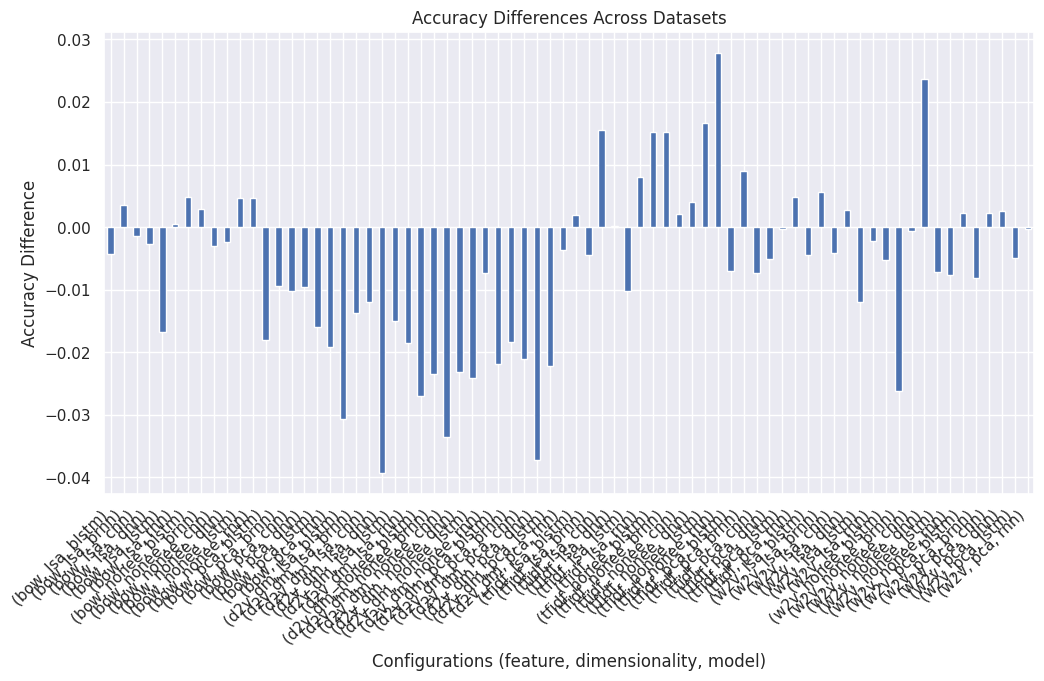

In [ ]:
import pandas as pd


# Example: Combine multiple datasets into a list (replace with your actual result sets)
results_dataset1 = results3  # Assuming results3 corresponds to dataset1
results_dataset2 = results4
# Add more datasets as needed...

# Combine all datasets into a DataFrame (as done previously)
# results_dataset1 and results_dataset2 are already defined
combined_results = pd.DataFrame(results_dataset1 + results_dataset2)

# Ensure configurations are aligned
aligned_results = combined_results.groupby(['feature', 'dimensionality', 'model'])

# Pivot for pairwise comparison
accuracy_pivot = combined_results.pivot_table(
    index=['feature', 'dimensionality', 'model'],
    columns='dataset',
    values='accuracy'
).dropna()  # Drop rows where any dataset is missing

# Compute accuracy differences
accuracy_diff = accuracy_pivot.diff(axis=1).iloc[:, -1]  # Difference between last two datasets

# Combine differences with original configurations
accuracy_comparison = accuracy_pivot.copy()
accuracy_comparison['difference'] = accuracy_diff

# Display differences
print("\nAccuracy Differences Across Datasets:")
print(accuracy_comparison)

# Visualization: Plot accuracy differences
import matplotlib.pyplot as plt

accuracy_diff.plot(kind='bar', figsize=(12, 6), title='Accuracy Differences Across Datasets')
plt.ylabel('Accuracy Difference')
plt.xlabel('Configurations (feature, dimensionality, model)')
plt.xticks(rotation=45, ha='right')
plt.show()

# 1 down 2 up


Runtime Differences Across Datasets:
dataset                         Dataset1    Dataset2  difference
feature dimensionality model                                    
bow     lsa            blstm  190.941159  296.559352  105.618194
                       brnn   185.788192  272.354923   86.566731
                       cnn    166.032600  286.276266  120.243666
                       dnn    127.208413  247.628174  120.419761
                       lstm   181.083423  347.158859  166.075436
...                                  ...         ...         ...
w2v     pca            brnn   106.197767  147.315288   41.117522
                       cnn     98.570687  157.613419   59.042732
                       dnn    103.051888  161.430547   58.378659
                       lstm    88.631913  155.687772   67.055859
                       rnn    130.761581  170.902471   40.140890

[72 rows x 3 columns]


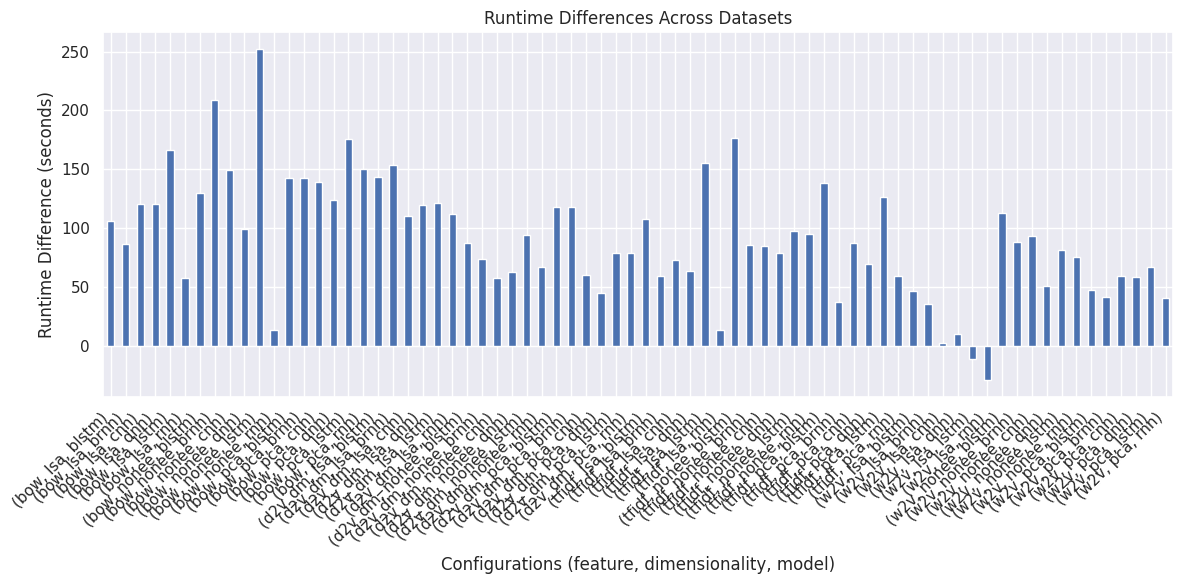

In [ ]:
import pandas as pd


# Example: Combine multiple datasets into a list (replace with your actual result sets)
results_dataset1 = results3  # Assuming results3 corresponds to dataset1
results_dataset2 = results4
# Add more datasets as needed...

# Combine all datasets into a DataFrame (as done previously)
# results_dataset1 and results_dataset2 are already defined
combined_results = pd.DataFrame(results_dataset1 + results_dataset2)

# Ensure configurations are aligned
aligned_results = combined_results.groupby(['feature', 'dimensionality', 'model'])

# Pivot for pairwise comparison (using 'runtime' instead of 'accuracy')
runtime_pivot = combined_results.pivot_table(
    index=['feature', 'dimensionality', 'model'],
    columns='dataset',
    values='runtime'  # We use 'runtime' for this comparison
).dropna()  # Drop rows where any dataset is missing

# Compute runtime differences (difference between last two datasets)
runtime_diff = runtime_pivot.diff(axis=1).iloc[:, -1]  # Difference between last two datasets

# Combine differences with original configurations
runtime_comparison = runtime_pivot.copy()
runtime_comparison['difference'] = runtime_diff

# Display differences
print("\nRuntime Differences Across Datasets:")
print(runtime_comparison)

# Visualization: Plot runtime differences
import matplotlib.pyplot as plt

runtime_diff.plot(kind='bar', figsize=(12, 6), title='Runtime Differences Across Datasets')
plt.ylabel('Runtime Difference (seconds)')
plt.xlabel('Configurations (feature, dimensionality, model)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
llm=[{'model':'racai/distilbert-base-romanian-uncased', 'eval_loss': 0.7330138683319092, 'eval_accuracy': 0.805049911920141, 'eval_f1_score': 0.8050546173133731, 'eval_runtime': 11.9959, 'eval_samples_per_second': 141.965, 'eval_steps_per_second': 4.502, 'epoch': 3.0},
{'model':'racai/distilbert-base-romanian-cased', 'eval_loss': 0.6802249550819397, 'eval_accuracy': 0.8073987081620669, 'eval_f1_score': 0.8071998542103203, 'eval_runtime': 11.9143, 'eval_samples_per_second': 142.938, 'eval_steps_per_second': 4.532, 'epoch': 3.0},
{'model':'dumitrescustefan/bert-base-romanian-uncased-v1', 'eval_loss': 0.8503040671348572, 'eval_accuracy': 0.815619495008808, 'eval_f1_score': 0.8156225466136076, 'eval_runtime': 7.7291, 'eval_samples_per_second': 220.337, 'eval_steps_per_second': 6.987, 'epoch': 3.0},
{'model':'dumitrescustefan/bert-base-romanian-cased-v1', 'eval_loss': 0.8635571002960205, 'eval_accuracy': 0.8273634762184381, 'eval_f1_score': 0.827368714685027, 'eval_runtime': 7.7448, 'eval_samples_per_second': 219.889, 'eval_steps_per_second': 6.972, 'epoch': 3.0},
{'model':'xlm-roberta-base', 'eval_loss': 0.5180391669273376, 'eval_accuracy': 0.7751027598355843, 'eval_f1_score': 0.7748707304465717, 'eval_runtime': 9.8918, 'eval_samples_per_second': 172.163, 'eval_steps_per_second': 5.459, 'epoch': 3.0},
{'model':'bert-base-multilingual-cased', 'eval_loss': 0.5538787245750427, 'eval_accuracy': 0.7463300058719906, 'eval_f1_score': 0.7462148127345606, 'eval_runtime': 9.0618, 'eval_samples_per_second': 187.931, 'eval_steps_per_second': 5.959, 'epoch': 3.0},
{'model':'bert-base-multilingual-uncased', 'eval_loss': 0.5470085144042969, 'eval_accuracy': 0.7604227833235467, 'eval_f1_score': 0.7601072498594625, 'eval_runtime': 9.0485, 'eval_samples_per_second': 188.209, 'eval_steps_per_second': 5.968, 'epoch': 3.0},
{'model':'gpt2', 'eval_loss': 0.5374465584754944, 'eval_accuracy': 0.7715795654726952, 'eval_f1_score': 0.7715866541162971, 'eval_runtime': 10.6479, 'eval_samples_per_second': 159.938, 'eval_steps_per_second': 5.071, 'epoch': 3.0},
{'model':'DGurgurov/xlm-r_romanian_sentiment', 'eval_loss': 0.6227548718452454, 'eval_accuracy': 0.8009395184967704, 'eval_f1_score': 0.8009010786083853, 'eval_runtime': 9.9309, 'eval_samples_per_second': 171.484, 'eval_steps_per_second': 5.438, 'epoch': 3.0},
{'model':'readerbench/RoGPT2-base', 'eval_loss': 1.177357792854309, 'eval_accuracy': 0.8009395184967704, 'eval_f1_score': 0.8009395184967704, 'eval_runtime': 10.6353, 'eval_samples_per_second': 160.127, 'eval_steps_per_second': 5.077, 'epoch': 3.0},
{'model':'readerbench/RoBERT-base', 'eval_loss': 0.8449975252151489, 'eval_accuracy': 0.815619495008808, 'eval_f1_score': 0.8155771341277921, 'eval_runtime': 7.7858, 'eval_samples_per_second': 218.732, 'eval_steps_per_second': 6.936, 'epoch': 3.0}]
# {'model':'dumitrescustefan/t5-v1_1-base-romanian', 'eval_loss': 0.0, 'eval_accuracy': 1.0, 'eval_f1_score': 1.0, 'eval_runtime': 16.7223, 'eval_samples_per_second': 101.84, 'eval_steps_per_second': 3.229, 'epoch': 3.0}]

# Results plot

In [ ]:
df = pd.DataFrame(results2)


In [ ]:
import pandas as pd

# Convert to a DataFrame
df = pd.DataFrame(results1)

# Create pivot tables
accuracy_table = df.pivot_table(values='accuracy', index=['feature', 'dimensionality'], columns='model')
f1_table = df.pivot_table(values='f1_score', index=['feature', 'dimensionality'], columns='model')
runtime_table = df.pivot_table(values='runtime', index=['feature', 'dimensionality'], columns='model')

# Display the results
print("Accuracy Table:")
print(accuracy_table)
print("\nF1 Score Table:")
print(f1_table)
print("\nRuntime Table:")
print(runtime_table)


Accuracy Table:
model                        knn        lr       mnb        rf       svm
feature dimensionality                                                  
bow     lsa             0.610687  0.742220  0.681738  0.694656  0.734586
        nonee           0.608338  0.742220  0.748679  0.738109  0.752789
        pca             0.617146  0.736348  0.671756  0.709336  0.744568
d2v_dm  lsa             0.662361  0.698180  0.631826  0.712272  0.701703
        nonee           0.666471  0.694656  0.666471  0.712860  0.701703
        pca             0.647681  0.698767  0.637698  0.708749  0.705226
tfidf   lsa             0.532002  0.725778  0.565473  0.719319  0.732824
        nonee           0.595420  0.709336  0.744568  0.728714  0.745743
        pca             0.527892  0.725778  0.568996  0.715208  0.734586
w2v     lsa             0.647681  0.726952  0.654727  0.706988  0.728714
        nonee           0.637698  0.725778  0.651204  0.708162  0.733999
        pca             0.655901  0

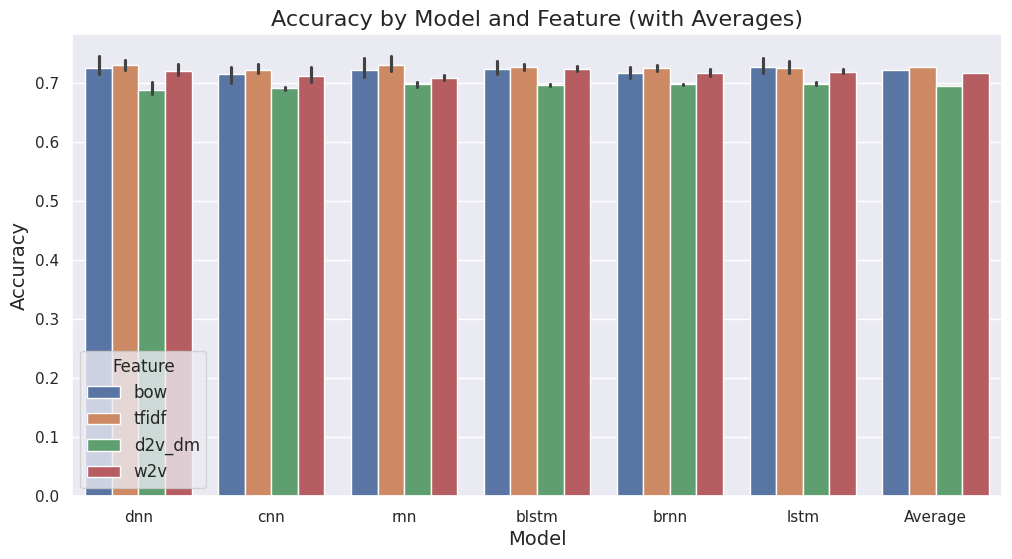

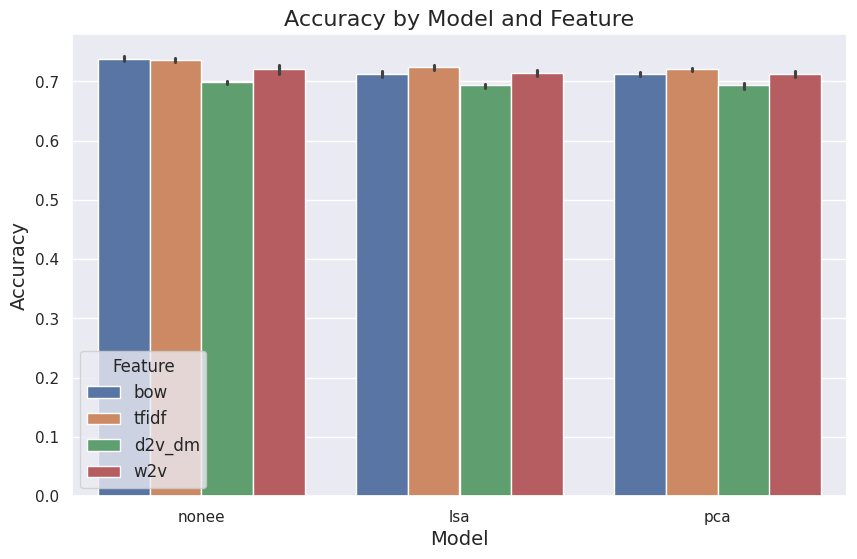

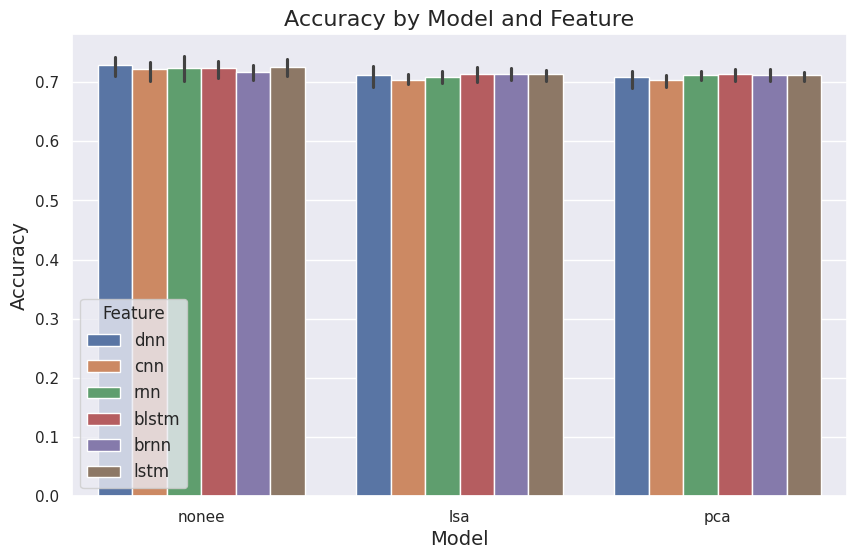

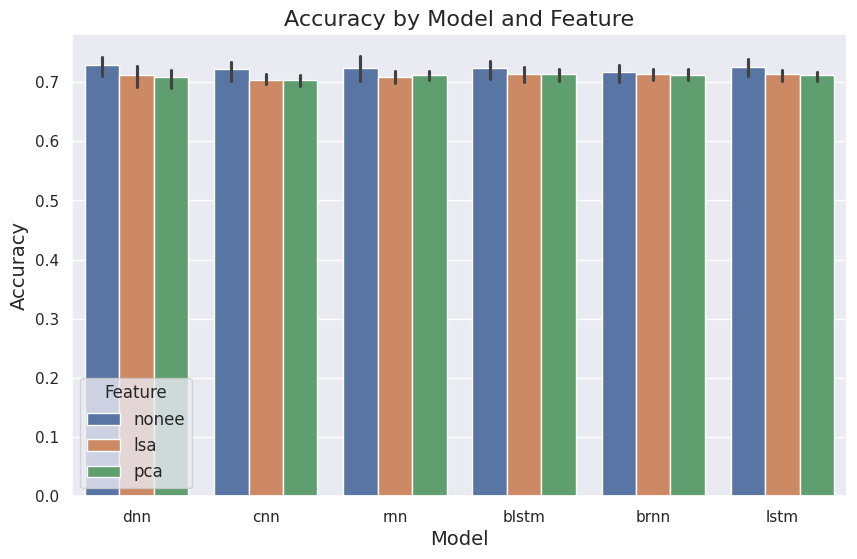

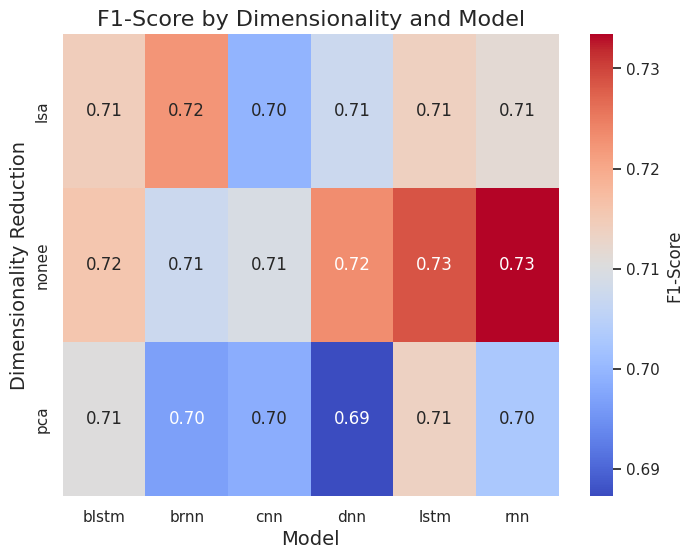

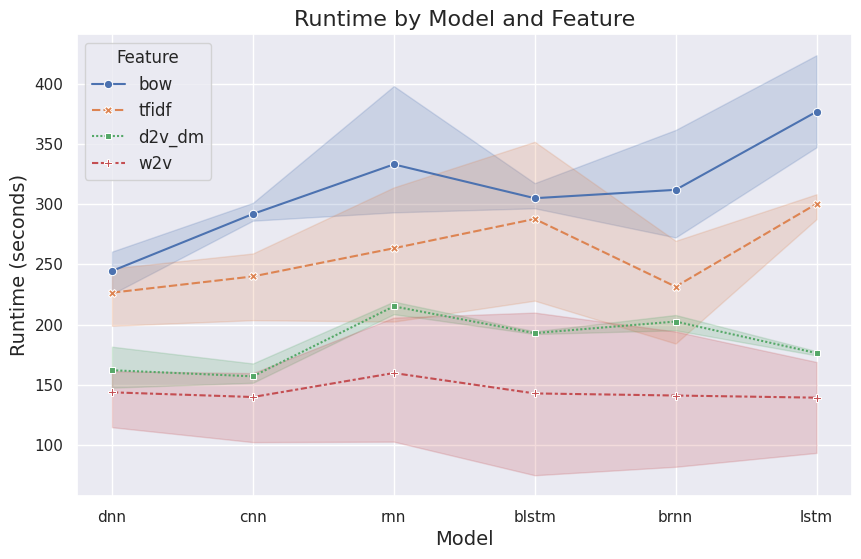

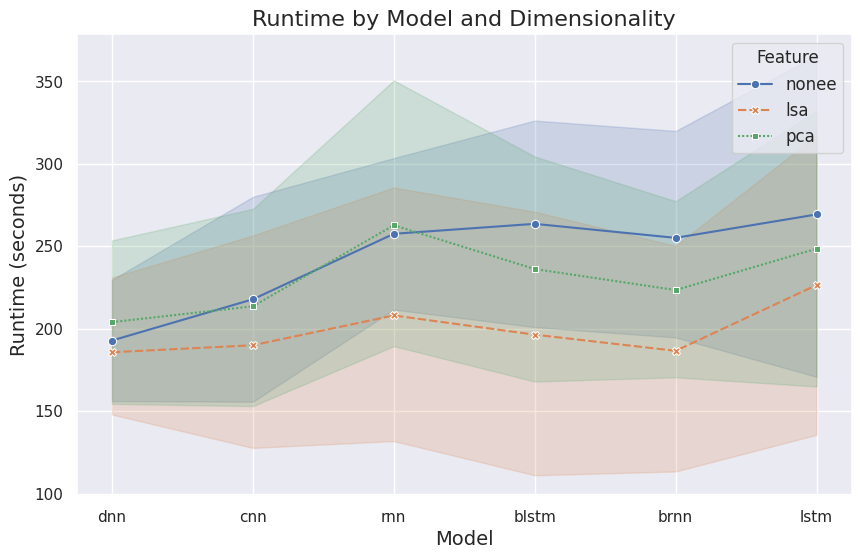

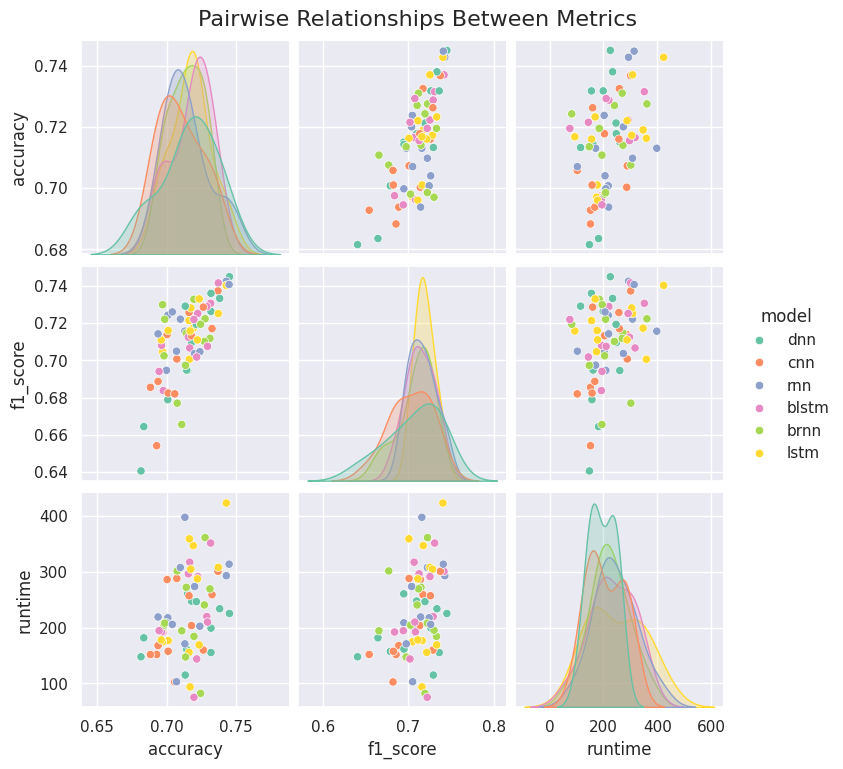

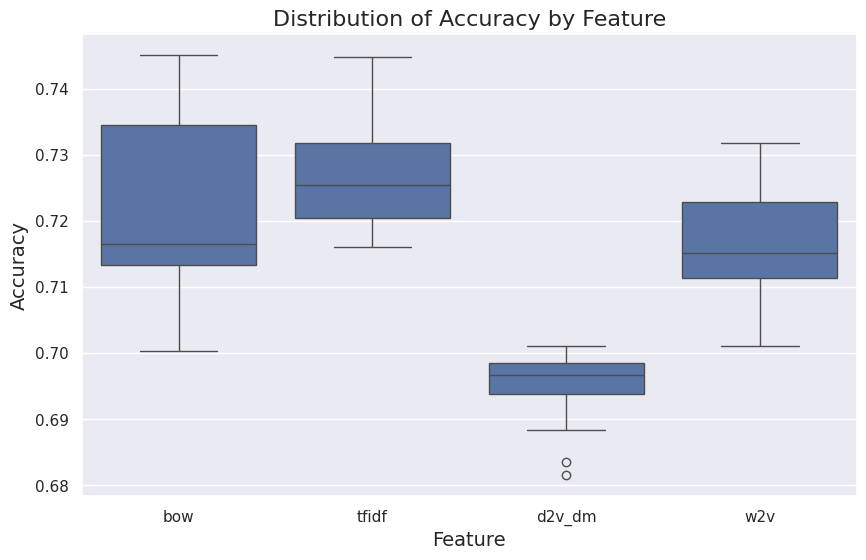

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



# Convert to a DataFrame for easier visualization
df = pd.DataFrame(results4)

# Define plot styles
sns.set_theme(style="darkgrid")

# Calculate average accuracy for each feature
avg_df = df.groupby('feature', as_index=False)['accuracy'].mean()
avg_df['model'] = 'Average'  # Add a new model category for the averages

# Append the averages to the original DataFrame
df_extended = pd.concat([df, avg_df], ignore_index=True)

# Plot the barplot with the additional "Average" block
plt.figure(figsize=(12, 6))
sns.barplot(x='model', y='accuracy', hue='feature', data=df_extended)
plt.title('Accuracy by Model and Feature (with Averages)', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.legend(title='Feature',loc='lower left', fontsize=12)
# plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.show()



# --- 1. Bar Plot: Accuracy by Model and Feature ---
plt.figure(figsize=(10, 6))
sns.barplot(x='dimensionality', y='accuracy', hue='feature', data=df)
plt.title('Accuracy by Model and Feature', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.legend(title='Feature', fontsize=12)
plt.show()

# --- 1. Bar Plot: Accuracy by Model and Feature ---
plt.figure(figsize=(10, 6))
sns.barplot(x='dimensionality', y='accuracy', hue='model', data=df)
plt.title('Accuracy by Model and Feature', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.legend(title='Feature', fontsize=12)
plt.show()

# --- 1. Bar Plot: Accuracy by Model and Feature ---
plt.figure(figsize=(10, 6))
sns.barplot(x='model', y='accuracy', hue='dimensionality', data=df)
plt.title('Accuracy by Model and Feature', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.legend(title='Feature', fontsize=12)
plt.show()

# --- 2. Heatmap: F1-Score for Models and Dimensionalities ---
heatmap_data = df.pivot_table(values='f1_score', index='dimensionality', columns='model')
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={'label': 'F1-Score'})
plt.title('F1-Score by Dimensionality and Model', fontsize=16)
plt.ylabel('Dimensionality Reduction', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.show()

# --- 3. Line Plot: Runtime vs. Model for Each Feature ---
plt.figure(figsize=(10, 6))
sns.lineplot(x='model', y='runtime', hue='feature', style='feature', markers=True, data=df)
plt.title('Runtime by Model and Feature', fontsize=16)
plt.ylabel('Runtime (seconds)', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.legend(title='Feature', fontsize=12)
plt.show()

# --- 3. Line Plot: Runtime vs. Model for Each Feature ---
plt.figure(figsize=(10, 6))
sns.lineplot(x='model', y='runtime', hue='dimensionality', style='dimensionality', markers=True, data=df)
plt.title('Runtime by Model and Dimensionality', fontsize=16)
plt.ylabel('Runtime (seconds)', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.legend(title='Feature', fontsize=12)
plt.show()

# --- 4. Pairplot: Relationships Between Metrics ---
sns.pairplot(df, hue='model', diag_kind='kde', palette='Set2', height=2.5)
plt.suptitle('Pairwise Relationships Between Metrics', y=1.02, fontsize=16)
plt.show()

# --- 5. Box Plot: Distribution of Accuracy by Feature ---
plt.figure(figsize=(10, 6))
sns.boxplot(x='feature', y='accuracy', data=df)
plt.title('Distribution of Accuracy by Feature', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Feature', fontsize=14)
plt.show()


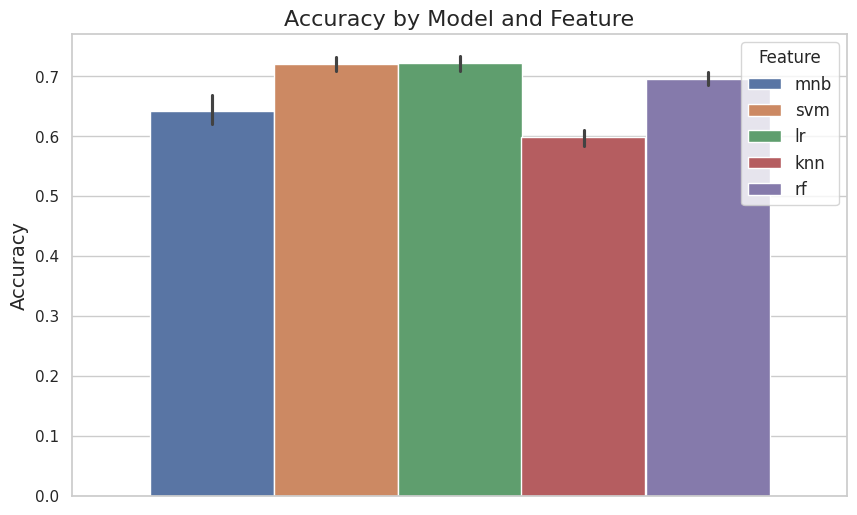

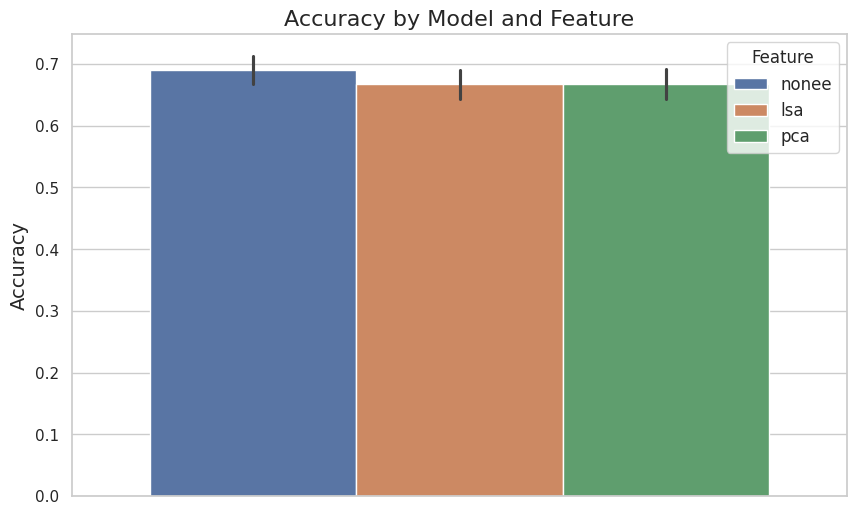

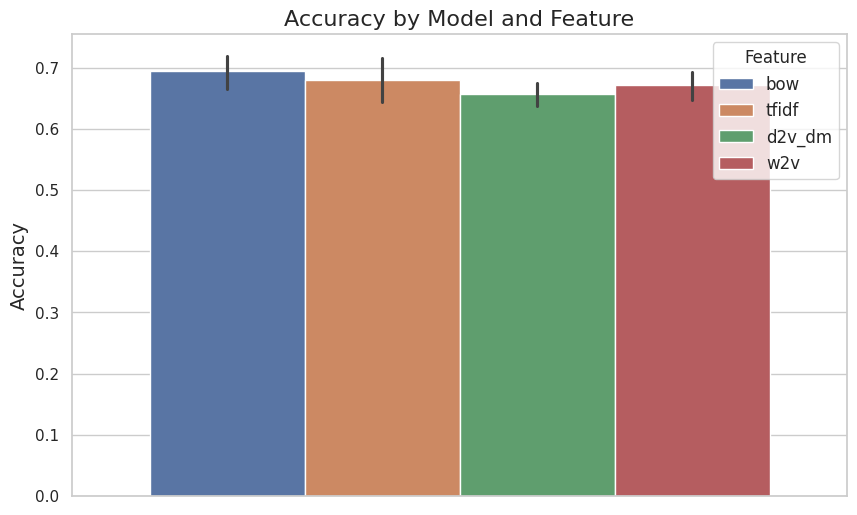

In [ ]:

# --- 1. Bar Plot: Accuracy by Model and Feature ---
plt.figure(figsize=(10, 6))
sns.barplot( y='accuracy', hue='model', data=df)
plt.title('Accuracy by Model and Feature', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
# plt.xlabel('Model', fontsize=14)
plt.legend(title='Feature', fontsize=12)
plt.show()


# --- 1. Bar Plot: Accuracy by Model and Feature ---
plt.figure(figsize=(10, 6))
sns.barplot( y='accuracy', hue='dimensionality', data=df)
plt.title('Accuracy by Model and Feature', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
# plt.xlabel('Model', fontsize=14)
plt.legend(title='Feature', fontsize=12)
plt.show()


# --- 1. Bar Plot: Accuracy by Model and Feature ---
plt.figure(figsize=(10, 6))
sns.barplot( y='accuracy', hue='feature', data=df)
plt.title('Accuracy by Model and Feature', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
# plt.xlabel('Model', fontsize=14)
plt.legend(title='Feature', fontsize=12)
plt.show()

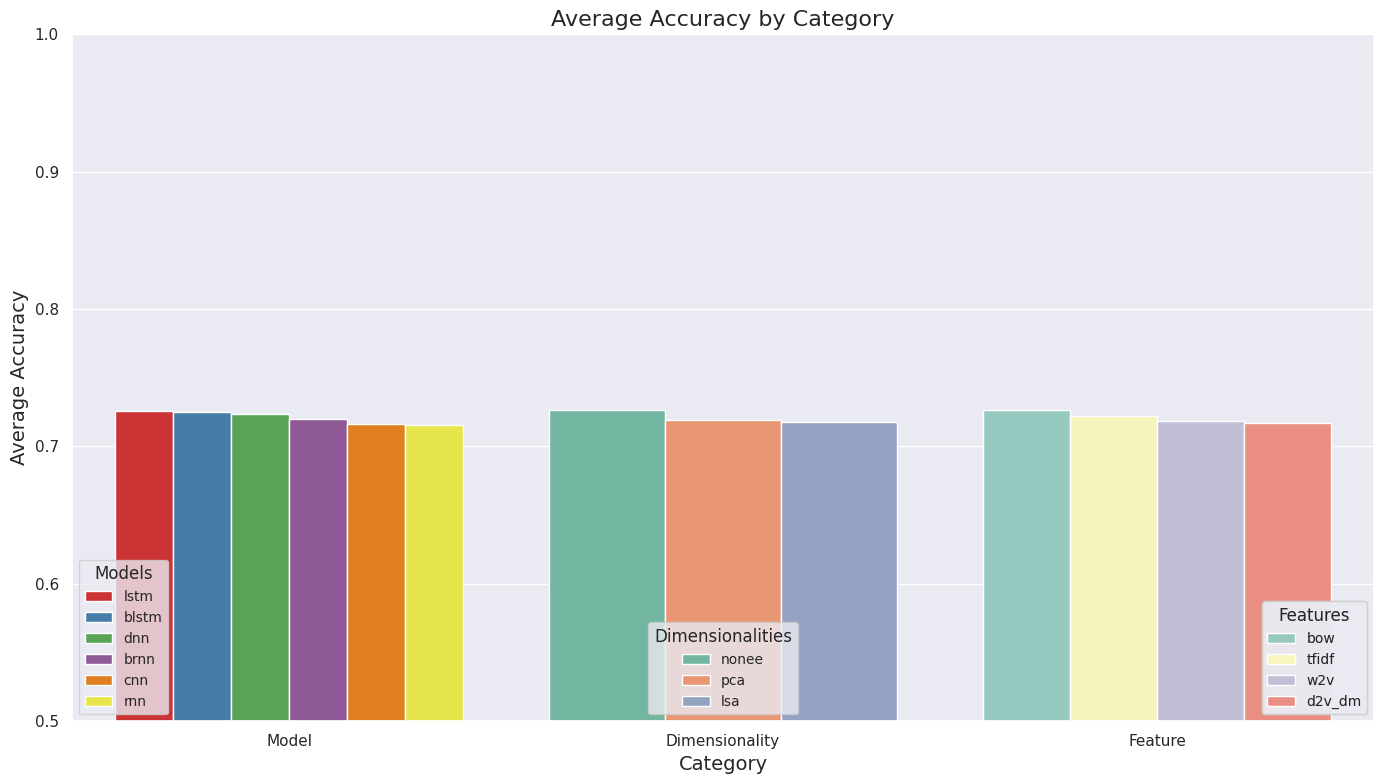

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")

# Calculate averages for each hue
avg_model = df.groupby('model', as_index=False)['accuracy'].mean()
avg_dim = df.groupby('dimensionality', as_index=False)['accuracy'].mean()
avg_feat = df.groupby('feature', as_index=False)['accuracy'].mean()

# Add a new column to indicate the category (hue type)
avg_model['category'] = 'Model'
avg_dim['category'] = 'Dimensionality'
avg_feat['category'] = 'Feature'

# Rename columns for consistency
avg_model = avg_model.rename(columns={'model': 'hue', 'accuracy': 'average_accuracy'})
avg_dim = avg_dim.rename(columns={'dimensionality': 'hue', 'accuracy': 'average_accuracy'})
avg_feat = avg_feat.rename(columns={'feature': 'hue', 'accuracy': 'average_accuracy'})

# Sort each group by average accuracy (descending)
avg_model = avg_model.sort_values(by='average_accuracy', ascending=False)
avg_dim = avg_dim.sort_values(by='average_accuracy', ascending=False)
avg_feat = avg_feat.sort_values(by='average_accuracy', ascending=False)

# Combine all into a single DataFrame
avg_combined = pd.concat([avg_model, avg_dim, avg_feat], ignore_index=True)

# Plot the averages
plt.figure(figsize=(14, 8))

# Plot each category separately for better control of legends
sns.barplot(
    x='category', y='average_accuracy', hue='hue', data=avg_model,
    dodge=True, palette=sns.color_palette("Set1", len(avg_model))
)
sns.barplot(
    x='category', y='average_accuracy', hue='hue', data=avg_dim,
    dodge=True, palette=sns.color_palette("Set2", len(avg_dim))
)
sns.barplot(
    x='category', y='average_accuracy', hue='hue', data=avg_feat,
    dodge=True, palette=sns.color_palette("Set3", len(avg_feat))
)

# Adjust title and labels
plt.title('Average Accuracy by Category', fontsize=16)
plt.ylabel('Average Accuracy', fontsize=14)
plt.xlabel('Category', fontsize=14)

# Set the y-axis range to start from 0.5 and go till 1
plt.ylim(0.5, 1)

# Manage separate legends
# Legend for Models
handles_model, labels_model = plt.gca().get_legend_handles_labels()
legend_model = plt.legend(
    handles=handles_model[:len(avg_model)], labels=labels_model[:len(avg_model)],
    loc='lower left', fontsize=10, title="Models"
)

# Legend for Dimensionalities
legend_dim = plt.legend(
    handles=handles_model[len(avg_model):len(avg_model) + len(avg_dim)],
    labels=labels_model[len(avg_model):len(avg_model) + len(avg_dim)],
    loc='lower center', fontsize=10, title="Dimensionalities"
)

# Legend for Features
legend_feat = plt.legend(
    handles=handles_model[len(avg_model) + len(avg_dim):],
    labels=labels_model[len(avg_model) + len(avg_dim):],
    loc='lower right', fontsize=10, title="Features"
)

# Add all legends back to the plot
plt.gca().add_artist(legend_model)
plt.gca().add_artist(legend_dim)
plt.gca().add_artist(legend_feat)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd


# Convert the list of dictionaries into a DataFrame
df = pd.DataFrame(results1)

# Get the best accuracy
best_accuracy = df.loc[df['accuracy'].idxmax()]

# Get the best F1 score
best_f1 = df.loc[df['f1_score'].idxmax()]

# Get the shortest runtime
shortest_runtime = df.loc[df['runtime'].idxmin()]

# Print the best values in the requested style
print(f"Best Accuracy: {best_accuracy['accuracy']:.6f}  {best_accuracy['model']} - {best_accuracy['feature']} - {best_accuracy['dimensionality']}")
print(f"Best F1 Score: {best_f1['f1_score']:.6f}  {best_f1['model']} - {best_f1['feature']} - {best_f1['dimensionality']}")
print(f"Shortest Runtime: {shortest_runtime['runtime']:.4f}  {shortest_runtime['model']} - {shortest_runtime['feature']} - {shortest_runtime['dimensionality']}")


Best Accuracy: 0.752789  svm - bow - nonee
Best F1 Score: 0.752579  svm - bow - nonee
Shortest Runtime: 0.1455  mnb - w2v - nonee


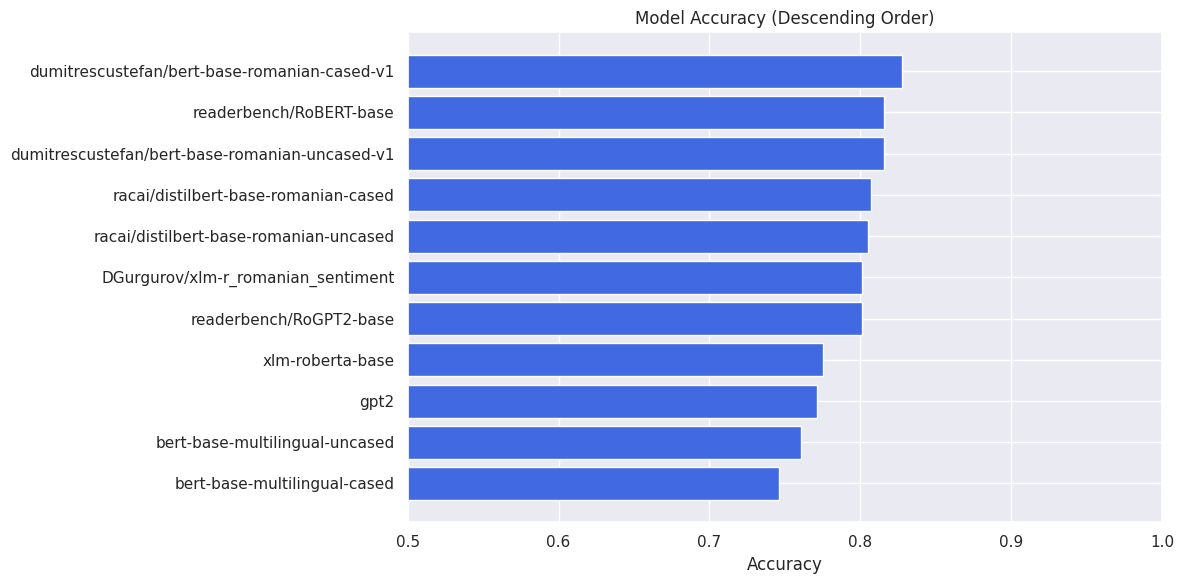

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


# Convert the list of dictionaries into a DataFrame
df = pd.DataFrame(llm)

# Sort the DataFrame by accuracy in descending order
df_sorted = df.sort_values(by='eval_accuracy', ascending=False)

# Plot Accuracy (horizontal bar chart)
plt.figure(figsize=(12, 6))
plt.barh(df_sorted['model'], df_sorted['eval_accuracy'], color='royalblue')
plt.xlabel('Accuracy')
plt.title('Model Accuracy (Descending Order)')
plt.gca().invert_yaxis()  # Reverse the order to have the highest accuracy on top

# Set the x-axis limits from 0.5 to 1
plt.xlim(0.5, 1)

# Adjust layout
plt.tight_layout()
plt.show()


# Stats

In [ ]:
raw_data = {}
for i in range(5):
    # Download and load cleaned reviews
    os.system(f'wget -q "https://raw.githubusercontent.com/ACS-SII/proiect-2024-sentiment-analysis-study/refs/heads/main/new_set/reviews_rating_{i+1}.json"')
    with open(f"reviews_rating_{i+1}.json", "r") as f:
        raw_data[i+1] = json.load(f)


In [ ]:

# Function to eliminate NaN values
def clean_data(data):
    # Use pandas to filter out NaN values
    return [item for item in data if pd.notna(item)]

# Clean each list in raw_data
for key in raw_data.keys():
    raw_data[key] = clean_data(raw_data[key])

# Print cleaned raw_data to verify
for key, value in raw_data.items():
    print(f"Key: {key}, Number of Reviews: {len(value)}")

In [ ]:

# Modified function to superpose histograms
def plot_length_distribution_superposed(data1, data2, data3, labels):
    # Calculate the lengths of each string in the datasets
    lengths1 = [len(item.split()) for item in data1 if len(item.split()) > 0]
    lengths2 = [len(item.split()) for item in data2 if len(item.split()) > 0]
    lengths3 = [len(item.split()) for item in data3 if len(item.split()) > 0]

    # Create the histogram with log-scaled bins
    bins = np.logspace(np.log10(1), np.log10(max(max(lengths1), max(lengths2), max(lengths3))), 50)

    # Plot the histograms
    plt.hist(lengths1, bins=bins, color='lightgray', alpha=0.6, label=labels[0], edgecolor='black')
    plt.hist(lengths2, bins=bins, color='green', alpha=0.6, label=labels[1], edgecolor='black')
    plt.hist(lengths3, bins=bins, color='red', alpha=0.6, label=labels[2], edgecolor='black')

    # Set the x-axis to a logarithmic scale
    plt.xscale('log')

    # Add labels, title, and legend
    plt.xlabel('Length of Strings (Log Scale)')
    plt.ylabel('Frequency')
    plt.title('Distributia dimensiunilor documentelor suprapuse')
    plt.legend()

    # Show the grid with dashed lines
    plt.grid(True, which="both", ls="--", linewidth=0.5)

    # Show the plot
    plt.show()


In [ ]:

# Data combinations
data1 = test_data[1] + test_data[2] + test_data[3] + test_data[4] + test_data[5]
data2 = test_data[4] + test_data[5]
data3 = test_data[1] + test_data[2] + test_data[3]
# Plot the superposed distributions
plot_length_distribution_superposed(data1, data2, data3,
                                    ['Documente neprocesate', 'Pozitive', 'Negative'])

In [ ]:

# Data combinations
data1 = raw_data[1] + raw_data[2] + raw_data[3] + raw_data[4] + raw_data[5]
data2 = raw_data[4] + raw_data[5]
data3 = raw_data[1] + raw_data[2] + raw_data[3]
# Plot the superposed distributions
plot_length_distribution_superposed(data1, data2, data3,
                                    ['Documente preprocesate', 'Pozitive', 'Negative'])

In [ ]:


# Modified function to superpose histograms for 5 ratings plus total
def plot_length_distribution_superposed_6(data1, data2, data3, data4, data5, total_data, labels):
    # Calculate the lengths of each string in the datasets
    lengths1 = [len(item.split()) for item in data1 if len(item.split()) > 0]
    lengths2 = [len(item.split()) for item in data2 if len(item.split()) > 0]
    lengths3 = [len(item.split()) for item in data3 if len(item.split()) > 0]
    lengths4 = [len(item.split()) for item in data4 if len(item.split()) > 0]
    lengths5 = [len(item.split()) for item in data5 if len(item.split()) > 0]
    total_lengths = [len(item.split()) for item in total_data if len(item.split()) > 0]

    # Create the histogram with log-scaled bins
    max_length = max(max(lengths1), max(lengths2), max(lengths3), max(lengths4), max(lengths5), max(total_lengths))
    bins = np.logspace(np.log10(1), np.log10(max_length), 50)

    # Plot the histograms
    plt.figure(figsize=(10, 6))  # Set the figure size

    plt.hist(lengths1, bins=bins, color='skyblue', alpha=0.6, label=labels[0], edgecolor='black')
    plt.hist(lengths2, bins=bins, color='orange', alpha=0.6, label=labels[1], edgecolor='black')
    plt.hist(lengths3, bins=bins, color='green', alpha=0.6, label=labels[2], edgecolor='black')
    plt.hist(lengths4, bins=bins, color='purple', alpha=0.6, label=labels[3], edgecolor='black')
    plt.hist(lengths5, bins=bins, color='red', alpha=0.6, label=labels[4], edgecolor='black')
    plt.hist(total_lengths, bins=bins, color='black', alpha=0.4, label=labels[5], edgecolor='black')

    # Set the x-axis to a logarithmic scale
    plt.xscale('log')

    # Add labels, title, and legend
    plt.xlabel('Length of Strings (Log Scale)')
    plt.ylabel('Frequency')
    plt.title('Comparative Length Distribution of Document Sets (1-5 Star Ratings and Total)')
    plt.legend()

    # Show the grid with dashed lines
    plt.grid(True, which="both", ls="--", linewidth=0.5)

    # Show the plot
    plt.show()



In [ ]:


# Modified function to superpose histograms for 5 ratings
def plot_length_distribution_stacked(data1, data2, data3, data4, data5, labels):
    # Calculate the lengths of each string in the datasets
    lengths1 = [len(item.split()) for item in data1 if len(item.split()) > 0]
    lengths2 = [len(item.split()) for item in data2 if len(item.split()) > 0]
    lengths3 = [len(item.split()) for item in data3 if len(item.split()) > 0]
    lengths4 = [len(item.split()) for item in data4 if len(item.split()) > 0]
    lengths5 = [len(item.split()) for item in data5 if len(item.split()) > 0]

    # Create the histogram with log-scaled bins
    max_length = max(max(lengths1), max(lengths2), max(lengths3), max(lengths4), max(lengths5))
    bins = np.logspace(np.log10(1), np.log10(max_length), 50)

    # Prepare the data for stacked histogram
    hist_data = [lengths1, lengths2, lengths3, lengths4, lengths5]

    # Create the stacked histogram
    plt.figure(figsize=(10, 8))  # Set the figure size

    plt.hist(hist_data, bins=bins, stacked=True,
             color=['skyblue', 'orange', 'green', 'purple', 'red'],
             alpha=0.6,  # Set a single alpha value for all bars
             label=labels, edgecolor='black')

    # Set the x-axis to a logarithmic scale
    plt.xscale('log')

    # Add labels, title, and legend
    plt.xlabel('Length of Strings (Log Scale)')
    plt.ylabel('Frequency')
    plt.title('Distributia lungimilor documentelor impartite pe scor')
    plt.legend()

    # Show the grid with dashed lines
    plt.grid(True, which="both", ls="--", linewidth=0.5)

    # Show the plot
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()

# Example usage (replace with your actual data)
# plot_length_distribution_stacked(data1, data2, data3, data4, data5, ['1 Star', '2 Star', '3 Star', '4 Star', '5 Star'])


In [ ]:

# Data for each rating category
data1 = test_data[1]
data2 = test_data[2]
data3 = test_data[3]
data4 = test_data[4]
data5 = test_data[5]

# Total data for all ratings combined
total_data = (test_data[1] + test_data[2] + test_data[3] + test_data[4] + test_data[5])
# Plot the superposed distributions
plot_length_distribution_superposed_6(data1, data2, data3, data4, data5, total_data,
                                      ['1 Star', '2 Star', '3 Star', '4 Star', '5 Star', 'Total'])
plot_length_distribution_stacked(data1, data2, data3, data4, data5,
                                      ['1 Star', '2 Star', '3 Star', '4 Star', '5 Star'])

In [ ]:
data1=raw_data[1]
data2=raw_data[2]
data3=raw_data[3]
data4=raw_data[4]
data5=raw_data[5]
total_data=raw_data[1]+raw_data[2]+raw_data[3]+raw_data[4]+raw_data[5]
plot_length_distribution_superposed_6(data1, data2, data3, data4, data5, total_data,
                                      ['1 Star', '2 Star', '3 Star', '4 Star', '5 Star', 'Total'])
plot_length_distribution_stacked(data1, data2, data3, data4, data5,
                                      ['1 Star', '2 Star', '3 Star', '4 Star', '5 Star'])

In [ ]:
# Presupunând că 'test_data' și 'raw_data' sunt definite și accesibile

print(f"Număr de documente test_data cu 1 stea: {len(test_data[1])}")  # Afișează numărul de recenzii cu 1 stea din 'test_data'
print(f"Număr de documente test_data cu 2 stele: {len(test_data[2])}")  # Afișează numărul de recenzii cu 2 stele din 'test_data'
print(f"Număr de documente test_data cu 3 stele: {len(test_data[3])}")  # Afișează numărul de recenzii cu 3 stele din 'test_data'
print(f"Număr de documente test_data cu 4 stele: {len(test_data[4])}")  # Afișează numărul de recenzii cu 4 stele din 'test_data'
print(f"Număr de documente test_data cu 5 stele: {len(test_data[5])}")  # Afișează numărul de recenzii cu 5 stele din 'test_data'

print(f"Număr de documente raw_data cu 1 stea: {len(raw_data[1])}")  # Afișează numărul de recenzii cu 1 stea din 'raw_data'
print(f"Număr de documente raw_data cu 2 stele: {len(raw_data[2])}")  # Afișează numărul de recenzii cu 2 stele din 'raw_data'
print(f"Număr de documente raw_data cu 3 stele: {len(raw_data[3])}")  # Afișează numărul de recenzii cu 3 stele din 'raw_data'
print(f"Număr de documente raw_data cu 4 stele: {len(raw_data[4])}")  # Afișează numărul de recenzii cu 4 stele din 'raw_data'
print(f"Număr de documente raw_data cu 5 stele: {len(raw_data[5])}")  # Afișează numărul de recenzii cu 5 stele din 'raw_data'

In [ ]:
!pip install matplotlib
import matplotlib.pyplot as plt

# Datele pentru grafic
stars = [1, 2, 3, 4, 5]
counts = [len(test_data[i]) for i in stars]

# Crearea graficului
plt.bar(stars, counts)

# Adăugarea titlului și etichetelor axelor
plt.title("Numărul de documente test_data pe stele")
plt.xlabel("Număr de stele")
plt.ylabel("Număr de documente")

# Afișarea graficului
plt.show()

In [ ]:
# Presupunând că 'test_data' și 'raw_data' sunt definite și accesibile

def calculate_sentiment_counts(data):
    """Calculează numărul total de documente, pozitive și negative."""
    total_docs = sum(len(data[i]) for i in range(1, 6))
    positive_docs = sum(len(data[i]) for i in range(1, 4))
    negative_docs = sum(len(data[i]) for i in range(4, 6))
    return total_docs, positive_docs, negative_docs

# Calculează pentru test_data
test_total, test_positive, test_negative = calculate_sentiment_counts(test_data)
print(f"test_data - Total documente: {test_total}")
print(f"test_data - Documente pozitive (1, 2, 3 stele): {test_positive}")
print(f"test_data - Documente negative (4, 5 stele): {test_negative}")

# Calculează pentru raw_data
raw_total, raw_positive, raw_negative = calculate_sentiment_counts(raw_data)
print(f"raw_data - Total documente: {raw_total}")
print(f"raw_data - Documente pozitive (1, 2, 3 stele): {raw_positive}")
print(f"raw_data - Documente negative (4, 5 stele): {raw_negative}")

In [ ]:


# # Example vocabularies (you should replace these with your actual vocs)
# voc_pos = Counter({'good': 100, 'great': 80, 'excellent': 60, 'happy': 50, 'love': 40, 'awesome': 30})
# voc_neg = Counter({'bad': 120, 'terrible': 90, 'poor': 70, 'sad': 60, 'hate': 50, 'awful': 40})
# Filter vocabularies to keep only words with at least 3 occurrences
# Assuming 'to_remove' is a list of stopwords
to_remove_set = set(rem_words(5*10))  # Convert to set for faster lookups

print(to_remove_set)

# Filter vocabularies to keep words with at least 3 occurrences and remove stopwords
voc_pos = Counter({word: count for word, count in dict_pos.items() if count >= 3 and word not in to_remove_set})
voc_neg = Counter({word: count for word, count in dict_neg.items() if count >= 3 and word not in to_remove_set})



# 1. Top frequent words
def plot_top_words(voc_pos, voc_neg, top_n=5):
    # Get top N words from each vocabulary
    top_pos = voc_pos.most_common(top_n)
    top_neg = voc_neg.most_common(top_n)

    # Words and counts for positive vocabulary
    words_pos, counts_pos = zip(*top_pos)

    # Words and counts for negative vocabulary
    words_neg, counts_neg = zip(*top_neg)

    # Bar plot for top words
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].barh(words_pos, counts_pos, color='green')
    ax[0].set_title('Top Positive Words')
    ax[0].set_xlabel('Frequency')

    ax[1].barh(words_neg, counts_neg, color='red')
    ax[1].set_title('Top Negative Words')
    ax[1].set_xlabel('Frequency')

    plt.tight_layout()
    plt.show()

# 2. Unique vs. Shared Words
def compare_unique_shared(voc_pos, voc_neg):
    pos_words = set(voc_pos.keys())
    neg_words = set(voc_neg.keys())

    # Words unique to positive and negative vocabularies
    unique_pos = pos_words - neg_words
    unique_neg = neg_words - pos_words

    # Shared words
    shared_words = pos_words & neg_words

    # Total words (count unique words only once by using the union)
    total_words = pos_words | neg_words

    print(f"Unique to positive: {len(unique_pos)} words")
    print(f"Unique to negative: {len(unique_neg)} words")
    print(f"Shared words: {len(shared_words)} words")
    print(f"Total words: {len(total_words)} words")

    return unique_pos, unique_neg, shared_words

# 3. Word Cloud (Alternative: Bar plot)
def plot_shared_words(voc_pos, voc_neg, shared_words, top_n=50):
    # Calculate the average frequency of each shared word in both vocabularies

    shared_words=voc_pos.keys() & voc_neg.keys()
    shared_avg_freq = {word: (voc_pos.get(word, 0) + voc_neg.get(word, 0)) / 2 for word in shared_words}

    # Sort the shared words by their average frequency and select the top_n words
    top_shared_words = sorted(shared_avg_freq, key=shared_avg_freq.get, reverse=True)[:top_n]

    # Get the counts for the top shared words
    shared_counts_pos = [voc_pos[word] for word in top_shared_words]
    shared_counts_neg = [voc_neg[word] for word in top_shared_words]

    x = np.arange(len(top_shared_words))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot shared word frequencies for positive and negative
    ax.bar(x - width/2, shared_counts_pos, width, label='Positive', color='green')
    ax.bar(x + width/2, shared_counts_neg, width, label='Negative', color='red')

    ax.set_xticks(x)
    ax.set_xticklabels(top_shared_words, rotation=45, ha="right")
    ax.legend()

    # titlu in engleza pentru a evita diacritice
    plt.title(f'Top {top_n} Cuvinte')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# 1. Plot top words for both vocabularies
plot_top_words(voc_pos, voc_neg, top_n=5)

# 2. Compare unique and shared words
unique_pos, unique_neg, shared_words = compare_unique_shared(voc_pos, voc_neg)

# 3. Plot shared word frequencies
plot_shared_words(voc_pos, voc_neg, shared_words)


In [ ]:
# Filter percentage_difference to include only words with at least 3 appearances
filtered_percentage_difference = {
    word: diff for word, diff in percentage_difference.items()
    if sum(sorted_merged_dict[word]) >= 3
}

# Define bins from just above 0% to just below 200%
bins = np.array([1, *np.arange(5, 200, 5)])
bin_labels = ["0%"] + [f"{bins[i]} to {bins[i+1]}%" for i in range(len(bins)-1)] + ["200%"]

# Initialize dictionaries to count positive and negative occurrences in each bin
positive_counts = {label: 0 for label in bin_labels}
negative_counts = {label: 0 for label in bin_labels}

# Separate handling for exact 0% and 200%
for word, diff in filtered_percentage_difference.items():
    abs_diff = abs(diff)

    # Special handling for exactly 0% and exactly 200%
    if abs_diff == 0:
        bin_label = "0%"
    elif abs_diff == 200:
        bin_label = "200%"
    else:
        # Use digitize for values within (0, 200)
        bin_index = np.digitize(abs_diff, bins)
        bin_label = bin_labels[bin_index]

    # Update counts based on positive or negative difference
    if diff >= 0:
        positive_counts[bin_label] += 1
    else:
        negative_counts[bin_label] += 1

# Convert counts to lists for plotting
positive_counts_values = list(positive_counts.values())
negative_counts_values = [-count for count in negative_counts.values()]  # Negative for plotting below axis

# Plot the bar chart with positive and negative counts centered on each x-axis tick
x = np.arange(len(bin_labels))  # x-axis positions for each bin

plt.figure(figsize=(14, 8))
plt.bar(x, positive_counts_values, color='skyblue', label="Positive")
plt.bar(x, negative_counts_values, color='salmon', label="Negative")
plt.xticks(x, bin_labels, rotation=90)  # Set x-ticks to bin labels and rotate for readability
plt.axhline(0, color='black', linewidth=0.5)  # Add a baseline at y=0
plt.xlabel("Percentage Difference Bins")
plt.ylabel("Word Count")
plt.title("Distribution of Percentage Differences in Word Occurrences")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


In [ ]:

# Assuming 'percentage_difference' and 'sorted_merged_dict' are defined

# Get the top 50 words and their percentage differences
top_50_words = list(percentage_difference.keys())[:50]
top_50_percentages = [percentage_difference[word] for word in top_50_words]

# Create the bar plot
plt.figure(figsize=(15, 6))  # Adjust figure size for better readability
plt.bar(top_50_words, top_50_percentages, color='skyblue')

# Customize the plot
plt.title("Percentage Difference in Word Frequency (Top 50 Words)")
plt.xlabel("Words")
plt.ylabel("Percentage Difference (%)")
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

# Display the plot
plt.show()